In [1]:
import os
os.chdir("../../../../")

import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet

import pmdarima
from scripts.python.tsmodel import *
from scripts.python.ts_utils import *

In [2]:
data_folder = os.getcwd() + "/data/tourism"
samoa_folder = data_folder + "/samoa/"

In [3]:
samoa = (pd.read_csv(samoa_folder + "samoa_byCon.csv")
           .drop("Unnamed: 0", axis=1))

samoa["Date"] = pd.to_datetime(samoa["Date"])
samoa[["Year", "Month"]].groupby("Year").count()
samoa.head(5)

,Date,Total arrivals (persons),American Samoa,Australia,Europe,New Zealand,USA,Other Countries,Cruise ships,Year,Month
0,2002-08-08,8260.0,2877.0,1115.0,429.0,2035.0,933.0,871.0,0.0,2002.0,8.0
1,2002-09-08,6708.0,2119.0,972.0,372.0,1879.0,612.0,754.0,0.0,2002.0,9.0
2,2002-10-08,5737.0,1892.0,737.0,468.0,1492.0,577.0,571.0,0.0,2002.0,10.0
3,2002-11-08,6653.0,2530.0,864.0,393.0,1675.0,483.0,708.0,0.0,2002.0,11.0
4,2002-12-08,13042.0,4678.0,1918.0,272.0,4401.0,1007.0,766.0,0.0,2002.0,12.0


In [4]:
covid = pd.read_csv(data_folder + "/owid-covid-data.csv")
covid_si = (covid[covid.continent == "Oceania"][["location", "date", "stringency_index"]]
            .reset_index()
            .drop("index", axis=1))
si_mean = covid_si.groupby("date").mean().reset_index()
si_mean["date"] = pd.to_datetime(si_mean["date"])
si_mean.head(5)

,date,stringency_index
0,2020-01-26,5.560
1,2020-01-27,5.560
2,2020-01-28,5.560
3,2020-01-29,5.560
4,2020-01-30,8.335


In [5]:
samoa = (samoa.merge(si_mean, how="left", left_on="Date", right_on="date")
         .drop("date", axis=1)
         .fillna(0)
         .rename({"Total arrivals (persons)": "Total",
                  "stringency_index": "covid"}, axis=1))
samoa.head(5)

,Date,Total,American Samoa,Australia,Europe,New Zealand,USA,Other Countries,Cruise ships,Year,Month,covid
0,2002-08-08,8260.0,2877.0,1115.0,429.0,2035.0,933.0,871.0,0.0,2002.0,8.0,0.0
1,2002-09-08,6708.0,2119.0,972.0,372.0,1879.0,612.0,754.0,0.0,2002.0,9.0,0.0
2,2002-10-08,5737.0,1892.0,737.0,468.0,1492.0,577.0,571.0,0.0,2002.0,10.0,0.0
3,2002-11-08,6653.0,2530.0,864.0,393.0,1675.0,483.0,708.0,0.0,2002.0,11.0,0.0
4,2002-12-08,13042.0,4678.0,1918.0,272.0,4401.0,1007.0,766.0,0.0,2002.0,12.0,0.0


## Preprocessing

In [6]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
samoa["minmax"] = minmax.fit_transform(samoa[["Total"]])

In [7]:
size = len(samoa)
train_size = int(round(0.9*size, 0))
test_size = size-train_size
train, test = model_selection.train_test_split(
    samoa[["Date", "Total", "covid", "minmax"]], train_size=train_size)

In [8]:
for var in ["minmax", "Total"]:
    stepwise_fit = auto_arima(train[var], exog=train["covid"], 
                              start_p=1, start_q=1,
                              max_p=5, max_q=5, m=12,
                              start_P=0, seasonal=True,
                              d=1, D=1, trace=True,
                              error_action='ignore',  # don't want to know if an order does not work
                              suppress_warnings=True,  # don't want convergence warnings
                              stepwise=True)  # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-553.791, Time=0.30 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-458.055, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-535.476, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-555.245, Time=0.21 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-490.677, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-553.283, Time=0.24 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-553.272, Time=0.85 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-538.127, Time=0.14 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-553.531, Time=1.23 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-535.333, Time=0.12 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-554.810, Time=0.30 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-553.439, Time=0.18 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-555.885, Time=0.60 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=-492.266, Time=0.10 sec
 ARIMA(1,1,2)(1,1,1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Ljung-box p-values:
[0.48525401 0.62854236 0.46053298 0.61002307 0.74403706 0.64899975
 0.44239151 0.43456334 0.48926325 0.34053264 0.40504764 0.4828664
 0.55909201 0.62376026 0.63629356 0.65257906 0.64312488 0.70646278
 0.6729179  0.71554161 0.7310761  0.71519479 0.71866314 0.75211932]


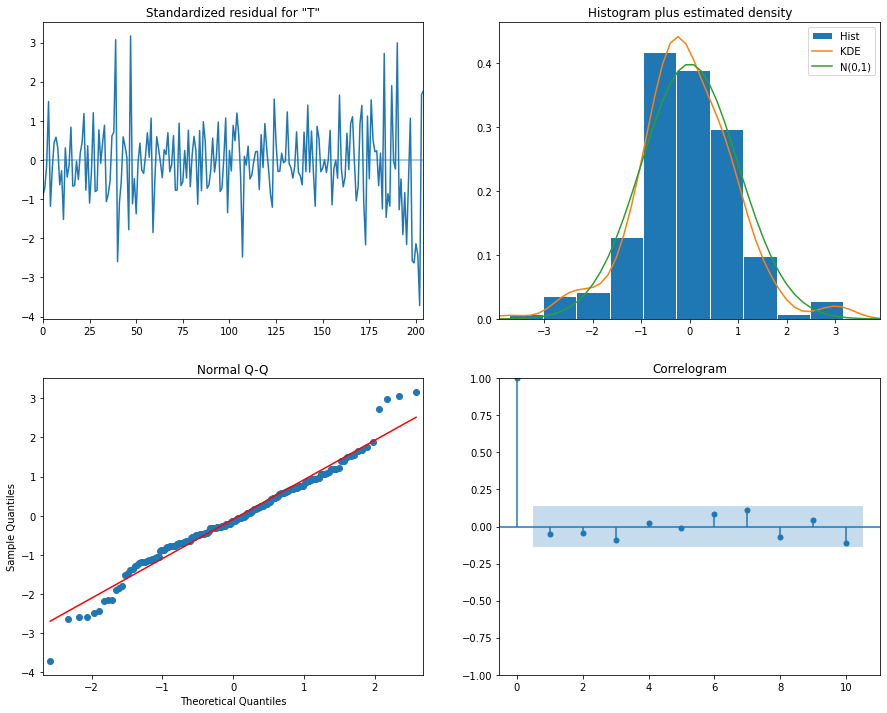

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Total   No. Observations:                  218
Model:             ARIMA(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -1784.071
Date:                            Mon, 27 Feb 2023   AIC                           3582.142
Time:                                    13:59:15   BIC                           3605.403
Sample:                                         0   HQIC                          3591.551
                                            - 218                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
covid        -55.2286      7.607     -7.261      0.000     -70.137     -40.320
ar.L1         -0.3432      0.144     -2.391      0.017      -0.625      -0.062
ar.L2         -0.6498      0.080     -8.136      0.000      -0.806      -0.493
ma.L1         -0.0490      0.158     -0.310      0.757      -0.359       0.261
ma.L2          0.5687      0.097      5.866      0.000       0.379       0.759
ma.S.L12      -0.6525      0.045    -14.406      0.000      -0.741      -0.564
sigma2      2.038e+06   1.58e+05     12.861      0.000    1.73e+06    2.35e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):                20.13
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               1.77   Skew:                            -0.00
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
# Use the best model from the stepwise searching
arma_mod = ARIMA(train["Total"], exog=train["covid"],
                 order=(2, 1, 2), seasonal_order=(0, 1, 1, 12))
arma_res = arma_mod.fit()

print("Ljung-box p-values:\n" +
      str(arma_res.test_serial_correlation(method='ljungbox')[0][1]))
arma_res.plot_diagnostics(figsize=(15, 12))
plt.show()
arma_res.summary()

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Ljung-box p-values:
[0.63603383 0.88767819 0.46761633 0.62595138 0.73179951 0.65931289
 0.413602   0.42650115 0.4908131  0.34360314 0.41056575 0.49299229
 0.55159785 0.60115936 0.59454139 0.55532639 0.60300653 0.66714604
 0.58511352 0.64045447 0.68126407 0.68879461 0.68975023 0.73229055]


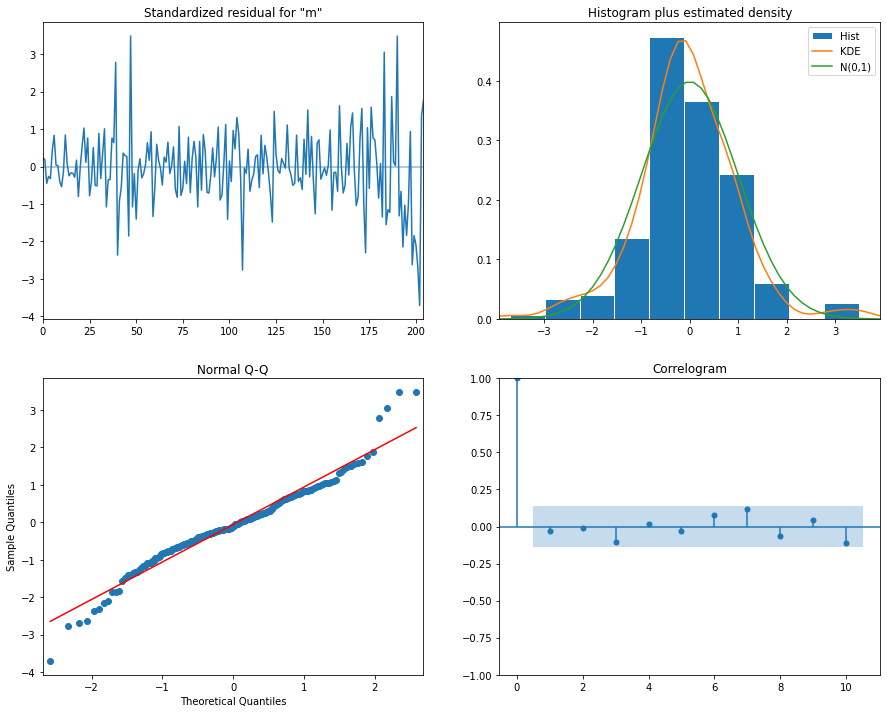

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             minmax   No. Observations:                  218
Model:             ARIMA(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                 295.208
Date:                            Mon, 27 Feb 2023   AIC                           -576.415
Time:                                    13:59:46   BIC                           -553.154
Sample:                                         0   HQIC                          -567.007
                                            - 218                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
covid         -0.0029      0.000     -7.650      0.000      -0.004      -0.002
ar.L1         -0.4323      0.156     -2.768      0.006      -0.738      -0.126
ar.L2         -0.6293      0.075     -8.381      0.000      -0.777      -0.482
ma.L1          0.0202      0.173      0.117      0.907      -0.320       0.360
ma.L2          0.4723      0.108      4.393      0.000       0.262       0.683
ma.S.L12      -0.7735      0.040    -19.571      0.000      -0.851      -0.696
sigma2         0.0031      0.000     13.646      0.000       0.003       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                40.26
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               2.40   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
minmax_mod = ARIMA(train["minmax"], exog=train["covid"],
                 order=(2, 1, 2), seasonal_order=(0, 1, 1, 12))
minmax_res = minmax_mod.fit()

print("Ljung-box p-values:\n" +
      str(minmax_res.test_serial_correlation(method='ljungbox')[0][1]))
minmax_res.plot_diagnostics(figsize=(15, 12))
plt.show()
minmax_res.summary()

In [13]:
def get_prediction_df(mod, steps: int, exog):

    pred = (mod.get_prediction(exog=exog).summary_frame(alpha=0.05)
            .rename({"mean": "train_pred"}, axis=1))
    forecast = (mod.get_forecast(
        steps=steps, exog=exog, dynamic=True).summary_frame(alpha=0.05).
        rename({"mean": "test_pred"}, axis=1))

    pred_stats = pd.concat([pred, forecast], axis=0)
    return pred_stats

In [14]:
minmax_pred = get_prediction_df(minmax_res, test_size, test["covid"])
for col in ["train_pred", "test_pred"]:
    minmax_pred[col] = minmax.inverse_transform(minmax_pred[[col]])
samoa_stats = pd.concat([samoa, minmax_pred], axis=1)

In [15]:
samoa_stats

,Date,Total,American Samoa,Australia,Europe,New Zealand,USA,Other Countries,Cruise ships,Year,Month,covid,minmax,train_pred,mean_se,mean_ci_lower,mean_ci_upper,test_pred
0,2002-08-08,8260.0,2877.0,1115.0,429.0,2035.0,933.0,871.0,0.0,2002.0,8.0,0.00000,0.335132,0.000000,1414.213565,-2771.807653,2771.807653,NaN
1,2002-09-08,6708.0,2119.0,972.0,372.0,1879.0,612.0,754.0,0.0,2002.0,9.0,0.00000,0.272163,8259.999991,1000.000003,-1959.628859,1960.299123,NaN
2,2002-10-08,5737.0,1892.0,737.0,468.0,1492.0,577.0,571.0,0.0,2002.0,10.0,0.00000,0.232767,6708.000000,1000.000003,-1959.691828,1960.236154,NaN
3,2002-11-08,6653.0,2530.0,864.0,393.0,1675.0,483.0,708.0,0.0,2002.0,11.0,0.00000,0.269931,5737.000011,1000.000003,-1959.731224,1960.196758,NaN
4,2002-12-08,13042.0,4678.0,1918.0,272.0,4401.0,1007.0,766.0,0.0,2002.0,12.0,0.00000,0.529152,6652.999996,1000.000003,-1959.694059,1960.233922,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,2022-05-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022.0,5.0,47.09500,0.000000,NaN,0.200523,-0.616635,0.169401,-5511.497526
238,2022-06-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022.0,6.0,41.35625,0.000000,NaN,0.206442,-0.551040,0.258199,-3608.816946
239,2022-07-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022.0,7.0,27.23125,0.000000,NaN,0.212246,-0.396419,0.435572,482.505652
240,2022-08-08,6228.0,692.0,1657.0,126.0,2641.0,382.0,730.0,0.0,2022.0,8.0,25.06125,0.252688,NaN,0.217984,-0.515618,0.338864,-2178.225877


In [18]:
## Set parameter range
p, d, q = range(0, 3), range(0, 2), range(0, 3)
P, D, Q, s = range(0, 3), range(0, 2), range(0, 3), [12]

## list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq, seasonal_pdq))

## Search the minimim aic 
all_res = sarimax(train["Total"], train["covid"], all_param)
all_res.sort(key=lambda x: x[1])

 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29326D+01    |proj g|=  6.04690D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   6.047D-06   1.293D+01
  F =   12.932644535771605     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:5642.63
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variable

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.40302D+00    |proj g|=  2.14315D-03

At iterate   20    f=  8.40252D+00    |proj g|=  2.11889D-02

At iterate   25    f=  8.39985D+00    |proj g|=  2.87343D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     32      1     0     0   1.108D-07   8.400D+00
  F =   8.3998409246350203     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:3668.33
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   10    f=  8.40864D+00    |proj g|=  1.88060D-03

At iterate   15    f=  8.40833D+00    |proj g|=  1.47367D-02

At iterate   20    f=  8.40798D+00    |proj g|=  1.21747D-04

At iterate   25    f=  8.40794D+00    |proj g|=  1.82695D-03

At iterate   30    f=  8.40594D+00    |proj g|=  2.56617D-02

At iterate   35    f=  8.39782D+00    |proj g|=  6.37382D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     40      1     0     0   3.101D-06   8.398D+00
  F =   8.3978229711373533     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 0)x(0, 1, 2, 12) - AIC:3669

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  9.40666D+00    |proj g|=  4.06043D-03

At iterate   30    f=  9.40515D+00    |proj g|=  1.73638D-03

At iterate   35    f=  9.40442D+00    |proj g|=  4.54706D-03

At iterate   40    f=  9.30265D+00    |proj g|=  1.41113D-02

At iterate   45    f=  9.30229D+00    |proj g|=  6.92378D-04

At iterate   50    f=  9.30067D+00    |proj g|=  1.21083D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     81      1     0     0   1.211D-02   9.301D+00
  F =   9.3006724574385764     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:4063

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  9.58106D+00    |proj g|=  3.09201D-02

At iterate   15    f=  9.57443D+00    |proj g|=  6.39415D-03

At iterate   20    f=  9.57277D+00    |proj g|=  1.32334D-02
  ys=-7.672E-03  -gs= 1.245E-02 BFGS update SKIPPED
  ys=-3.145E-02  -gs= 3.640E-02 BFGS update SKIPPED
  ys=-1.434E-08  -gs= 3.591E-09 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     67      1     3     0   1.572D-01   9.549D+00
  F =   9.5494067510472949     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 0)x(1, 0, 2, 12) - AIC:4173.54
RUNNING THE L-BFGS-B CODE



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.39953D+00    |proj g|=  3.85085D-03

At iterate   15    f=  8.39933D+00    |proj g|=  4.80269D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     20      1     0     0   1.118D-05   8.399D+00
  F =   8.3993148463983935     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 0)x(1, 1, 0, 12) - AIC:3668.1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.43595D+00    |proj g|=  2.64455D-01

At iterate    5

 This problem is unconstrained.



At iterate    5    f=  8.40707D+00    |proj g|=  1.92557D-03

At iterate   10    f=  8.39599D+00    |proj g|=  3.83488D-02

At iterate   15    f=  8.39343D+00    |proj g|=  1.09326D-02

At iterate   20    f=  8.39144D+00    |proj g|=  3.26040D-03

At iterate   25    f=  8.39139D+00    |proj g|=  9.40740D-04

At iterate   30    f=  8.38966D+00    |proj g|=  3.36674D-02

At iterate   35    f=  8.38548D+00    |proj g|=  4.96143D-04

At iterate   40    f=  8.38351D+00    |proj g|=  1.23210D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   45    f=  8.38032D+00    |proj g|=  2.84980D-03

At iterate   50    f=  8.37863D+00    |proj g|=  2.11389D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     79      2     0     0   2.114D-02   8.379D+00
  F =   8.3786323908093223     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 0)x(1, 1, 2, 12) - AIC:3663.08
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47186D+01    |proj g|=  1.05566D+01

At iterate    

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


  ys=-1.629E-02  -gs= 3.377E-02 BFGS update SKIPPED

At iterate   25    f=  9.24428D+00    |proj g|=  7.97568D-04

At iterate   30    f=  9.24289D+00    |proj g|=  1.77367D-02

At iterate   35    f=  9.13767D+00    |proj g|=  6.50052D-02

At iterate   40    f=  9.02350D+00    |proj g|=  2.56088D-02

At iterate   45    f=  8.97545D+00    |proj g|=  4.32413D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     48     76      1     1     0   8.799D-06   8.975D+00
  F =   8.9754500199573339     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 0, 0)x(2, 0, 0, 12) - AIC:3921.3


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.64201D+00    |proj g|=  6.16252D-02

At iterate    5    f=  9.55157D+00    |proj g|=  2.19446D-03

At iterate   10    f=  9.52853D+00    |proj g|=  1.17372D-01

At iterate   15    f=  9.35899D+00    |proj g|=  3.63739D-02

At iterate   20    f=  9.27557D+00    |proj g|=  3.32485D-03

At iterate   25    f=  9.27499D+00    |proj g|=  2.97930D-03

At iterate   30    f=  9.27357D+00    |proj g|=  1.49021D-03

At iterate   35    f=  9.27153D+00    |proj g|=  1.21812D-03

At iterate   40    f=  9.26935D+00    |proj g|=  3.01982D-03

At iterate   45    f=  9.23867D+00    |proj g|=  1.05074D-03

At iterate   50    f=  9.13070D+00    |proj g|=  1.38721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89159D+01    |proj g|=  3.68908D+01

At iterate    5    f=  9.60106D+00    |proj g|=  5.23037D-02

At iterate   10    f=  9.56572D+00    |proj g|=  7.40639D-03

At iterate   15    f=  9.56448D+00    |proj g|=  4.44878D-03

At iterate   20    f=  9.45567D+00    |proj g|=  2.14195D-02

At iterate   25    f=  9.44289D+00    |proj g|=  1.30278D-02

At iterate   30    f=  9.39984D+00    |proj g|=  1.36452D-02

At iterate   35    f=  9.36865D+00    |proj g|=  6.11609D-02

At iterate   40    f=  9.31961D+00    |proj g|=  6.64124D-03

At iterate   45    f=  9.31932D+00    |proj g|=  7.24436D-04


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  9.31912D+00    |proj g|=  3.47736D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     78      1     0     0   3.477D-03   9.319D+00
  F =   9.3191155965110912     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 0)x(2, 0, 2, 12) - AIC:4075.13
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42166D+00    |proj g|=  1.90834D-01

At iterate    5    f=  8.40016D+00    |proj g|=  8.93047D-05

           * *

 This problem is unconstrained.



At iterate   15    f=  8.38584D+00    |proj g|=  1.21631D-02

At iterate   20    f=  8.38548D+00    |proj g|=  1.55009D-03

At iterate   25    f=  8.38534D+00    |proj g|=  4.01428D-03

At iterate   30    f=  8.38508D+00    |proj g|=  2.33145D-04

At iterate   35    f=  8.38501D+00    |proj g|=  7.54702D-04

At iterate   40    f=  8.38006D+00    |proj g|=  2.93029D-02

At iterate   45    f=  8.37859D+00    |proj g|=  4.98969D-04


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.37856D+00    |proj g|=  5.66340D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59      1     0     0   5.663D-04   8.379D+00
  F =   8.3785597407434871     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 0)x(2, 1, 1, 12) - AIC:3663.05
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.45985D+00    |proj g|=  2.47790D-01

At iterate    5    f=  8.40743D+00    |proj g|=  5.53217D-03


 This problem is unconstrained.



At iterate   10    f=  8.40034D+00    |proj g|=  4.63842D-02

At iterate   15    f=  8.39787D+00    |proj g|=  5.50991D-03

At iterate   20    f=  8.39666D+00    |proj g|=  4.93587D-02

At iterate   25    f=  8.39486D+00    |proj g|=  3.61077D-03

At iterate   30    f=  8.39286D+00    |proj g|=  1.53844D-02

At iterate   35    f=  8.39267D+00    |proj g|=  1.06071D-04

At iterate   40    f=  8.39266D+00    |proj g|=  1.09195D-03

At iterate   45    f=  8.39199D+00    |proj g|=  7.29709D-03

At iterate   50    f=  8.39118D+00    |proj g|=  2.69269D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(0, 0, 0)x(2, 1, 2, 12) - AIC:3670.55
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04521D+01    |proj g|=  1.09573D-01

At iterate    5    f=  1.04254D+01    |proj g|=  6.17151D-05

At iterate   10    f=  1.04254D+01    |proj g|=  2.86843D-03

At iterate   15    f=  1.04203D+01    |proj g|=  3.76334D-02

At iterate   20    f=  1.02897D+01    |proj g|=  5.35789D-03

At iterate   25    f=  1.02613D+01    |proj g|=  2.75527D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     P

 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03207D+01    |proj g|=  4.06668D-02

At iterate    5    f=  1.03073D+01    |proj g|=  1.72394D-04

At iterate   10    f=  1.03073D+01    |proj g|=  1.16781D-03

At iterate   15    f=  1.03058D+01    |proj g|=  1.34150D-02

At iterate   20    f=  1.02809D+01    |proj g|=  2.54424D-02

At iterate   25    f=  1.02711D+01    |proj g|=  3.56859D-04

At iterate   30    f=  1.02711D+01    |proj g|=  1.39910D-03

At iterate   35    f=  1.02694D+01    |proj g|=  1.85887D-02

At iterate   40    f=  1.00767D+01    |proj g|=  3.10936D-01

At iterate   45    f=  9.52856D+00    |proj g|=  1.00291D-02

At iterate   50    f=  9.52815D+00    |proj g|=  6.18257D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.37463D+00    |proj g|=  2.60117D-02

At iterate    5    f=  8.37423D+00    |proj g|=  5.40170D-03

At iterate   10    f=  8.37319D+00    |proj g|=  1.12607D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     18      1     0     0   1.021D-05   8.373D+00
  F =   8.3731240362483295     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 1)x(0, 1, 0, 12) - AIC:3656.68
RUNNING THE L-B

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.38431D+00    |proj g|=  1.65627D-01

At iterate    5    f=  8.35757D+00    |proj g|=  4.16938D-04

At iterate   10    f=  8.35710D+00    |proj g|=  2.55733D-02

At iterate   15    f=  8.35384D+00    |proj g|=  5.80178D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     22      1     0     0   3.603D-05   8.354D+00
  F =   8.3538081718905630     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 1)x(0, 1, 2, 12) - AIC:3652.2

 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.94660D+00    |proj g|=  4.41756D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     88      1     0     0   4.418D-04   8.947D+00
  F =   8.9466031333205649     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 1)x(1, 0, 0, 12) - AIC:3908.72
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02932D+01    |proj g|=  3.08815D-02

At iterate    5    f=  1.02822D+01    |proj g|=  9.21109D-03

At iterate   1

 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.98610D+00    |proj g|=  7.52822D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     55      1     0     0   7.528D-02   9.986D+00
  F =   9.9861014724951183     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 1)x(1, 0, 1, 12) - AIC:4363.94
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03048D+01    |proj g|=  6.84069D-02

At iterate    5    f=  1.02817D+01    |proj g|=  3.33934D-03

At iterate   1

 This problem is unconstrained.



At iterate   20    f=  1.02801D+01    |proj g|=  1.25846D-02

At iterate   25    f=  1.02548D+01    |proj g|=  6.42817D-02

At iterate   30    f=  1.02433D+01    |proj g|=  8.74306D-04

At iterate   35    f=  1.02432D+01    |proj g|=  7.06328D-04

At iterate   40    f=  1.02411D+01    |proj g|=  8.66049D-03

At iterate   45    f=  1.01393D+01    |proj g|=  4.20414D-02

At iterate   50    f=  9.83163D+00    |proj g|=  2.75050D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     56      1     0     0   2.750D-01   9.832D+00
  F =   9.8316312257497973     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  8.35449D+00    |proj g|=  3.49788D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     23      1     0     0   3.498D-05   8.354D+00
  F =   8.3544917835441179     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 1)x(1, 1, 0, 12) - AIC:3650.56
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.37375D+00    |proj g|=  1.66271D-01

At iterate    5    f=  8.35820D+00    |proj g|=  4.26520D-04

At iterate   1

 This problem is unconstrained.



At iterate   10    f=  8.34976D+00    |proj g|=  3.27820D-02

At iterate   15    f=  8.34535D+00    |proj g|=  5.00409D-03

At iterate   20    f=  8.34391D+00    |proj g|=  6.84723D-04

At iterate   25    f=  8.34361D+00    |proj g|=  7.42078D-04

At iterate   30    f=  8.34340D+00    |proj g|=  1.60255D-03

At iterate   35    f=  8.34340D+00    |proj g|=  9.53767D-05

At iterate   40    f=  8.34339D+00    |proj g|=  9.32600D-04

At iterate   45    f=  8.34338D+00    |proj g|=  8.74987D-04

At iterate   50    f=  8.34337D+00    |proj g|=  6.62249D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     70   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(0, 0, 1)x(1, 1, 2, 12) - AIC:3649.71
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04521D+01    |proj g|=  4.09560D-01

At iterate    5    f=  1.02830D+01    |proj g|=  4.50101D-03

At iterate   10    f=  1.02828D+01    |proj g|=  2.56894D-04

At iterate   15    f=  1.02826D+01    |proj g|=  2.12897D-03

At iterate   20    f=  1.02749D+01    |proj g|=  1.25405D-02

At iterate   25    f=  1.02463D+01    |proj g|=  9.85886D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   30    f=  1.02453D+01    |proj g|=  1.34072D-04

At iterate   35    f=  1.02451D+01    |proj g|=  2.46934D-03

At iterate   40    f=  1.02293D+01    |proj g|=  2.56070D-02

At iterate   45    f=  9.24248D+00    |proj g|=  8.52154D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -0.00000D+00    |proj g|=  2.12217D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     73      1     0     0   2.122D+05  -0.000D+00
  F =  -0.0000000000000000     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 1)x(2, 0, 0, 12) - AIC:10.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04270D+01    |proj g|=  5.49678D-02

At iterate    5    f=  1.02860D+01    |proj g|=  3.25458D-03

At iterate   10  

 This problem is unconstrained.



At iterate   15    f=  1.02808D+01    |proj g|=  2.16258D-03

At iterate   20    f=  1.02803D+01    |proj g|=  1.56606D-04

At iterate   25    f=  1.02803D+01    |proj g|=  6.63809D-04

At iterate   30    f=  1.02793D+01    |proj g|=  3.35200D-03

At iterate   35    f=  1.02470D+01    |proj g|=  1.20852D-03

At iterate   40    f=  1.02468D+01    |proj g|=  8.58633D-04

At iterate   45    f=  1.02285D+01    |proj g|=  8.96058D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   50    f=  9.78042D+00    |proj g|=  1.99889D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     79      1     0     0   1.999D-01   9.780D+00
  F =   9.7804212998048019     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 1)x(2, 0, 1, 12) - AIC:4276.26
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11818D+01    |proj g|=  1.74601D+00

At iterate    5    f=  1.02810D+01    |proj g|=  4.51306D-04

At iterate   1

 This problem is unconstrained.



At iterate    5    f=  8.35817D+00    |proj g|=  4.29663D-04

At iterate   10    f=  8.35810D+00    |proj g|=  7.01326D-03

At iterate   15    f=  8.35530D+00    |proj g|=  4.23546D-02

At iterate   20    f=  8.35413D+00    |proj g|=  3.57803D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     23      1     0     0   3.578D-05   8.354D+00
  F =   8.3541279095043972     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 1)x(2, 1, 0, 12) - AIC:3652.4
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0 

 This problem is unconstrained.



At iterate   15    f=  8.35781D+00    |proj g|=  1.30222D-03

At iterate   20    f=  8.35780D+00    |proj g|=  1.82241D-03

At iterate   25    f=  8.35240D+00    |proj g|=  4.47307D-02

At iterate   30    f=  8.34776D+00    |proj g|=  7.84253D-03

At iterate   35    f=  8.34578D+00    |proj g|=  1.22141D-03

At iterate   40    f=  8.34568D+00    |proj g|=  3.58807D-04

At iterate   45    f=  8.34568D+00    |proj g|=  9.24107D-05

At iterate   50    f=  8.34567D+00    |proj g|=  7.52831D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   7.528D-04   8.346D+00
  F =   8.34567170422

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(0, 0, 1)x(2, 1, 1, 12) - AIC:3650.71
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.38756D+00    |proj g|=  1.68921D-01

At iterate    5    f=  8.36024D+00    |proj g|=  1.17399D-02


 This problem is unconstrained.



At iterate   10    f=  8.35582D+00    |proj g|=  7.59187D-03

At iterate   15    f=  8.34954D+00    |proj g|=  1.47570D-02

At iterate   20    f=  8.34768D+00    |proj g|=  1.38754D-02

At iterate   25    f=  8.34751D+00    |proj g|=  3.56748D-04

At iterate   30    f=  8.34747D+00    |proj g|=  5.89414D-03

At iterate   35    f=  8.34653D+00    |proj g|=  3.33747D-02

At iterate   40    f=  8.34549D+00    |proj g|=  2.73054D-03

At iterate   45    f=  8.34525D+00    |proj g|=  4.59354D-02

At iterate   50    f=  8.34475D+00    |proj g|=  5.91169D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     66   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(0, 0, 1)x(2, 1, 2, 12) - AIC:3652.31
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04214D+01    |proj g|=  1.88625D-01

At iterate    5    f=  1.03659D+01    |proj g|=  4.70777D-03

At iterate   10    f=  1.03658D+01    |proj g|=  6.69685D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   6.697D-05   1.037D+01
  F =   10.365803142789433     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIM

 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   45    f=  1.00149D+01    |proj g|=  2.91610D-02

At iterate   50    f=  9.72225D+00    |proj g|=  1.94383D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     61      1     0     0   1.944D-01   9.722D+00
  F =   9.7222455328930053     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 2)x(0, 0, 1, 12) - AIC:4248.9
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03197D+01    |proj g|=  4.37807D-02

At iterate    5

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   20    f=  1.02837D+01    |proj g|=  3.53688D-02

At iterate   25    f=  1.02640D+01    |proj g|=  2.01345D-02

At iterate   30    f=  1.02193D+01    |proj g|=  4.39935D-02

At iterate   35    f=  1.02135D+01    |proj g|=  4.84095D-03

At iterate   40    f=  1.02132D+01    |proj g|=  1.15910D-03

At iterate   45    f=  1.02042D+01    |proj g|=  2.26660D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f=  1.00219D+01    |proj g|=  2.91037D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   2.910D-01   1.002D+01
  F =   10.021929115380345     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 2)x(0, 0, 2, 12) - AIC:4381.56
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.37440D+00    |proj g|=  4.18759D-02

At iterate    5    f=  8.37360D+00    |proj g|=  1.19937D-03

At iterate   1

 This problem is unconstrained.



At iterate   10    f=  8.35423D+00    |proj g|=  8.66001D-03

At iterate   15    f=  8.34913D+00    |proj g|=  4.69685D-02

At iterate   20    f=  8.34666D+00    |proj g|=  7.44974D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     26      1     0     0   8.230D-05   8.347D+00
  F =   8.3466584327509636     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 2)x(0, 1, 2, 12) - AIC:3651.14
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  1.02813D+01    |proj g|=  8.93793D-03

At iterate   10    f=  1.02788D+01    |proj g|=  8.50680D-05

At iterate   15    f=  1.02788D+01    |proj g|=  8.88029D-04

At iterate   20    f=  1.02752D+01    |proj g|=  1.07378D-02

At iterate   25    f=  1.02346D+01    |proj g|=  1.44784D-02

At iterate   30    f=  1.02243D+01    |proj g|=  2.61906D-03

At iterate   35    f=  1.02031D+01    |proj g|=  2.36677D-02

At iterate   40    f=  1.01994D+01    |proj g|=  2.36396D-04

At iterate   45    f=  1.01992D+01    |proj g|=  3.07719D-03

At iterate   50    f=  1.01792D+01    |proj g|=  3.76681D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


At iterate   10    f=  1.02786D+01    |proj g|=  2.43569D-03

At iterate   15    f=  1.02785D+01    |proj g|=  2.69524D-04

At iterate   20    f=  1.02783D+01    |proj g|=  5.17644D-03

At iterate   25    f=  1.02493D+01    |proj g|=  8.23995D-02

At iterate   30    f=  1.02020D+01    |proj g|=  3.06223D-03

At iterate   35    f=  1.02010D+01    |proj g|=  2.14272D-04

At iterate   40    f=  1.02009D+01    |proj g|=  2.04409D-03

At iterate   45    f=  1.01945D+01    |proj g|=  2.00918D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  1.01850D+01    |proj g|=  4.82922D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     54      1     0     0   4.829D-03   1.019D+01
  F =   10.185033454903428     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 2)x(1, 0, 2, 12) - AIC:4454.67
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.36157D+00    |proj g|=  9.77534D-02

At iterate    5    f=  8.35504D+00    |proj g|=  5.22246D-04

At iterate   1

 This problem is unconstrained.



At iterate   20    f=  8.34704D+00    |proj g|=  1.32423D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     25      1     0     0   5.075D-05   8.347D+00
  F =   8.3470440353361361     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 2)x(1, 1, 1, 12) - AIC:3651.31
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.37931D+00    |proj g|=  1.42986D-01



 This problem is unconstrained.


At iterate    5    f=  8.35511D+00    |proj g|=  7.63393D-04

At iterate   10    f=  8.35391D+00    |proj g|=  6.55501D-02

At iterate   15    f=  8.34721D+00    |proj g|=  2.25596D-02

At iterate   20    f=  8.34282D+00    |proj g|=  6.60005D-03

At iterate   25    f=  8.34186D+00    |proj g|=  4.50098D-03

At iterate   30    f=  8.34130D+00    |proj g|=  1.44916D-03

At iterate   35    f=  8.34001D+00    |proj g|=  2.42847D-03
  ys=-3.408E-06  -gs= 3.897E-06 BFGS update SKIPPED

At iterate   40    f=  8.33994D+00    |proj g|=  7.08530D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     62      1     1 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Tried out SARIMAX(0, 0, 2)x(1, 1, 2, 12) - AIC:3650.22
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04214D+01    |proj g|=  3.39786D-01

At iterate    5    f=  1.02806D+01    |proj g|=  3.06248D-03

At iterate   10    f=  1.02805D+01    |proj g|=  2.70710D-04

At iterate   15    f=  1.02803D+01    |proj g|=  3.59761D-03

At iterate   20    f=  1.02664D+01    |proj g|=  2.20766D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   25    f=  1.02115D+01    |proj g|=  1.38883D-02

At iterate   30    f=  1.02022D+01    |proj g|=  7.84520D-04

At iterate   35    f=  1.02021D+01    |proj g|=  1.47887D-03

At iterate   40    f=  1.02004D+01    |proj g|=  2.17815D-02

At iterate   45    f=  1.00437D+01    |proj g|=  2.96370D-01


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  9.40080D+00    |proj g|=  9.29371D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63      1     0     0   9.294D-01   9.401D+00
  F =   9.4007990262440000     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 2)x(2, 0, 0, 12) - AIC:4110.75
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04309D+01    |proj g|=  5.49453D-02

At iterate    5    f=  1.02823D+01    |proj g|=  4.94236D-03

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   50    f=  1.02053D+01    |proj g|=  2.31803D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     67      1     0     0   2.318D-03   1.021D+01
  F =   10.205313264776365     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 0, 2)x(2, 0, 1, 12) - AIC:4463.52
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10289D+01    |proj g|=  1.44761D+00

At iterate    5    f=  1.02790D+01    |proj g|=  4.17896D-03

At iterate   1

 This problem is unconstrained.



At iterate    5    f=  8.35479D+00    |proj g|=  5.40426D-04

At iterate   10    f=  8.35469D+00    |proj g|=  7.50007D-03

At iterate   15    f=  8.34898D+00    |proj g|=  3.25945D-02

At iterate   20    f=  8.34664D+00    |proj g|=  3.00183D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     25      1     0     0   5.146D-05   8.347D+00
  F =   8.3466422576914177     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 2)x(2, 1, 0, 12) - AIC:3651.14
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0

 This problem is unconstrained.



At iterate   10    f=  8.35456D+00    |proj g|=  9.02473D-03

At iterate   15    f=  8.35444D+00    |proj g|=  5.35957D-04

At iterate   20    f=  8.35431D+00    |proj g|=  9.97326D-03

At iterate   25    f=  8.34989D+00    |proj g|=  4.49761D-02

At iterate   30    f=  8.34646D+00    |proj g|=  8.94759D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     36      1     0     0   5.160D-05   8.346D+00
  F =   8.3464635217502945     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 0, 2)x(2, 1, 1, 12) - AIC:3653.06
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  8.35700D+00    |proj g|=  1.76910D-02

At iterate   10    f=  8.35281D+00    |proj g|=  1.04535D-02

At iterate   15    f=  8.35097D+00    |proj g|=  2.80278D-02

At iterate   20    f=  8.34710D+00    |proj g|=  5.06196D-02

At iterate   25    f=  8.34663D+00    |proj g|=  1.27827D-03

At iterate   30    f=  8.34662D+00    |proj g|=  1.05540D-03

At iterate   35    f=  8.34657D+00    |proj g|=  1.01607D-02

At iterate   40    f=  8.34213D+00    |proj g|=  3.95553D-02

At iterate   45    f=  8.34194D+00    |proj g|=  1.04937D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     54   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.29394D+00    |proj g|=  3.52619D-03

At iterate   15    f=  9.29123D+00    |proj g|=  3.53271D-02

At iterate   20    f=  9.19349D+00    |proj g|=  1.62370D-01

At iterate   25    f=  9.13040D+00    |proj g|=  2.18849D-03

At iterate   30    f=  9.13037D+00    |proj g|=  1.51024D-03

At iterate   35    f=  9.12812D+00    |proj g|=  1.48088D-02

At iterate   40    f=  9.12554D+00    |proj g|=  4.34205D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     42     48      1     0     0   5.268D-06   9.126D+00
  F =   9.1255401883907403     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  8.30454D+00    |proj g|=  1.44135D-02

At iterate   30    f=  8.28918D+00    |proj g|=  3.62438D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     37      1     0     0   1.027D-05   8.289D+00
  F =   8.2889448179532277     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 12) - AIC:3619.98
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.33075D+00    |proj g|=  8.92862D-02

At iterate    

 This problem is unconstrained.



At iterate   15    f=  8.31744D+00    |proj g|=  2.24227D-02

At iterate   20    f=  8.31278D+00    |proj g|=  2.03927D-04

At iterate   25    f=  8.31269D+00    |proj g|=  4.46159D-03

At iterate   30    f=  8.30387D+00    |proj g|=  4.89936D-02

At iterate   35    f=  8.28884D+00    |proj g|=  2.35844D-04

At iterate   40    f=  8.28883D+00    |proj g|=  7.85850D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     47      1     0     0   6.335D-05   8.289D+00
  F =   8.2888248839716461     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 0)x(0, 1, 2, 12) - AIC:3621

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.86370D+00    |proj g|=  6.34286D-02

At iterate   10    f=  8.84160D+00    |proj g|=  1.04486D-02

At iterate   15    f=  8.84062D+00    |proj g|=  1.69513D-04

At iterate   20    f=  8.84058D+00    |proj g|=  1.15473D-03

At iterate   25    f=  8.83915D+00    |proj g|=  9.08643D-03

At iterate   30    f=  8.83749D+00    |proj g|=  1.28796D-04

At iterate   35    f=  8.83723D+00    |proj g|=  1.27254D-02

At iterate   40    f=  8.83005D+00    |proj g|=  5.87480D-02

At iterate   45    f=  8.82761D+00    |proj g|=  7.12967D-04

At iterate   50    f=  8.82757D+00    |proj g|=  5.85956D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.33583D+00    |proj g|=  5.87899D-02

At iterate    5    f=  8.32953D+00    |proj g|=  2.11682D-04

At iterate   10    f=  8.32951D+00    |proj g|=  4.02617D-03

At iterate   15    f=  8.32780D+00    |proj g|=  2.74443D-02

At iterate   20    f=  8.32663D+00    |proj g|=  1.59099D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     27      1     0     0   4.576D-07   8.326D+00
  F =   8.3264212273590399     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  8.29287D+00    |proj g|=  1.32494D-03

At iterate   10    f=  8.29215D+00    |proj g|=  1.89499D-02

At iterate   15    f=  8.28958D+00    |proj g|=  6.05445D-03

At iterate   20    f=  8.28784D+00    |proj g|=  1.60926D-03

At iterate   25    f=  8.28737D+00    |proj g|=  8.95907D-04

At iterate   30    f=  8.28652D+00    |proj g|=  3.10518D-03

At iterate   35    f=  8.28606D+00    |proj g|=  7.57765D-05

At iterate   40    f=  8.28600D+00    |proj g|=  1.77598D-03

At iterate   45    f=  8.28355D+00    |proj g|=  1.00198D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.28096D+00    |proj g|=  6.02558D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     56      1     0     0   6.026D-03   8.281D+00
  F =   8.2809642890878390     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 1, 0)x(1, 1, 2, 12) - AIC:3620.5
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.88145D+00    |proj g|=  4.40011D-02

At iterate    5    f=  8.86951D+00    |proj g|=  1.26791D-02

At iterate   10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.84287D+00    |proj g|=  4.13578D-02

At iterate   10    f=  8.83444D+00    |proj g|=  2.57936D-03

At iterate   15    f=  8.83442D+00    |proj g|=  3.28719D-04

At iterate   20    f=  8.83436D+00    |proj g|=  4.69507D-03

At iterate   25    f=  8.83289D+00    |proj g|=  1.70345D-02

At iterate   30    f=  8.83254D+00    |proj g|=  7.26400D-05

At iterate   35    f=  8.83252D+00    |proj g|=  1.87646D-03

At iterate   40    f=  8.83136D+00    |proj g|=  7.27359D-03

At iterate   45    f=  8.82800D+00    |proj g|=  5.20936D-03

At iterate   50    f=  8.82757D+00    |proj g|=  5.77971D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.83493D+00    |proj g|=  4.82738D-02

At iterate    5    f=  8.82923D+00    |proj g|=  1.97304D-02

At iterate   10    f=  8.82853D+00    |proj g|=  3.36094D-04

At iterate   15    f=  8.82807D+00    |proj g|=  4.53403D-03

At iterate   20    f=  8.82759D+00    |proj g|=  6.19962D-03

At iterate   25    f=  8.82706D+00    |proj g|=  2.75501D-03

At iterate   30    f=  8.82691D+00    |proj g|=  6.33539D-04

At iterate   35    f=  8.82683D+00    |proj g|=  1.14633D-03

At iterate   40    f=  8.82652D+00    |proj g|=  1.36483D-03

At iterate   45    f=  8.82616D+00    |proj g|=  9.57742D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Ca


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  8.31176D+00    |proj g|=  2.12282D-02

At iterate   15    f=  8.31002D+00    |proj g|=  7.95088D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   6.402D-05   8.310D+00
  F =   8.3100201662269875     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 0)x(2, 1, 0, 12) - AIC:3631.17
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.32024D+00    |proj g|=  6.17551D-02

At iterate    

 This problem is unconstrained.



At iterate   10    f=  8.29389D+00    |proj g|=  1.02588D-02

At iterate   15    f=  8.29368D+00    |proj g|=  1.32533D-04

At iterate   20    f=  8.29358D+00    |proj g|=  3.82449D-03

At iterate   25    f=  8.29210D+00    |proj g|=  5.88579D-03

At iterate   30    f=  8.29141D+00    |proj g|=  7.76090D-05

At iterate   35    f=  8.29135D+00    |proj g|=  1.34882D-03

At iterate   40    f=  8.28795D+00    |proj g|=  1.84312D-02

At iterate   45    f=  8.28570D+00    |proj g|=  3.20223D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.28566D+00    |proj g|=  5.63345D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     56      1     0     0   5.633D-05   8.286D+00
  F =   8.2856551450537363     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 1, 0)x(2, 1, 1, 12) - AIC:3622.55
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.31659D+00    |proj g|=  9.83490D-02

At iterate    5    f=  8.28962D+00    |proj g|=  9.37922D-03


 This problem is unconstrained.



At iterate   10    f=  8.28902D+00    |proj g|=  9.05980D-03

At iterate   15    f=  8.28680D+00    |proj g|=  8.29123D-03

At iterate   20    f=  8.28512D+00    |proj g|=  4.62066D-03

At iterate   25    f=  8.28480D+00    |proj g|=  1.84729D-03

At iterate   30    f=  8.28477D+00    |proj g|=  1.16967D-04

At iterate   35    f=  8.28471D+00    |proj g|=  1.85034D-03

At iterate   40    f=  8.28394D+00    |proj g|=  2.26843D-03

At iterate   45    f=  8.28371D+00    |proj g|=  7.21951D-05

At iterate   50    f=  8.28361D+00    |proj g|=  4.96918D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(0, 1, 0)x(2, 1, 2, 12) - AIC:3623.65
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.43956D+00    |proj g|=  1.16629D-01

At iterate    5    f=  9.41005D+00    |proj g|=  2.99833D-03

At iterate   10    f=  9.35594D+00    |proj g|=  6.23033D-04

At iterate   15    f=  9.35592D+00    |proj g|=  3.37129D-04

At iterate   20    f=  9.35490D+00    |proj g|=  4.42858D-03

At iterate   25    f=  9.34457D+00    |proj g|=  6.52838D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     P

 This problem is unconstrained.
 This problem is unconstrained.


Tried out SARIMAX(0, 1, 1)x(0, 0, 1, 12) - AIC:3970.32
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.19076D+00    |proj g|=  1.37785D-01

At iterate    5    f=  9.17231D+00    |proj g|=  1.87585D-04

At iterate   10    f=  9.17228D+00    |proj g|=  4.28332D-03

At iterate   15    f=  9.16874D+00    |proj g|=  4.39349D-02


 This problem is unconstrained.



At iterate   20    f=  9.12446D+00    |proj g|=  2.23800D-02

At iterate   25    f=  9.12168D+00    |proj g|=  2.21167D-03

At iterate   30    f=  9.12164D+00    |proj g|=  2.01291D-03

At iterate   35    f=  9.11850D+00    |proj g|=  2.81539D-02

At iterate   40    f=  9.06787D+00    |proj g|=  2.33488D-02

At iterate   45    f=  8.97527D+00    |proj g|=  1.99753D-02

At iterate   50    f=  8.97365D+00    |proj g|=  4.54153D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     65      1     0     0   4.542D-04   8.974D+00
  F =   8.9736549634167826     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.23325D+00    |proj g|=  2.20211D-04

At iterate   10    f=  8.23322D+00    |proj g|=  4.57359D-03

At iterate   15    f=  8.23039D+00    |proj g|=  3.82255D-02

At iterate   20    f=  8.22489D+00    |proj g|=  1.29057D-03

At iterate   25    f=  8.22487D+00    |proj g|=  1.19283D-03

At iterate   30    f=  8.22254D+00    |proj g|=  1.74231D-02

At iterate   35    f=  8.20470D+00    |proj g|=  6.57529D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     43      1     0     0   1.958D-07   8.205D+00
  F =   8.2045348830248397     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   10    f=  8.23309D+00    |proj g|=  5.69034D-03

At iterate   15    f=  8.22770D+00    |proj g|=  2.41203D-02

At iterate   20    f=  8.22485D+00    |proj g|=  1.41051D-04

At iterate   25    f=  8.22482D+00    |proj g|=  1.22550D-03

At iterate   30    f=  8.22194D+00    |proj g|=  1.91756D-02

At iterate   35    f=  8.20441D+00    |proj g|=  1.92994D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     44      1     0     0   3.121D-05   8.204D+00
  F =   8.2043935799347292     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 1)x(0, 1, 2, 12) - AIC:3587

 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  8.85949D+00    |proj g|=  3.24939D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     83      1     1     0   3.249D-03   8.859D+00
  F =   8.8594874109705781     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 1, 1)x(1, 0, 0, 12) - AIC:3870.74
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.10590D+00    |proj g|=  1.13003D-02

At iterate    5    f=  9.10529D+00    |proj g|=  7.19229D-04

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  9.10583D+00    |proj g|=  7.60391D-03

At iterate   10    f=  9.10526D+00    |proj g|=  2.32438D-04

At iterate   15    f=  9.10506D+00    |proj g|=  5.83721D-03

At iterate   20    f=  9.06218D+00    |proj g|=  9.35850D-02

At iterate   25    f=  9.01593D+00    |proj g|=  7.61172D-03
  ys=-1.462E-03  -gs= 1.445E-03 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  9.01493D+00    |proj g|=  4.09437D-03

At iterate   35    f=  9.01454D+00    |proj g|=  2.49025D-03

At iterate   40    f=  8.95609D+00    |proj g|=  7.98301D-02

At iterate   45    f=  8.94064D+00    |proj g|=  1.15593D-03

At iterate   50    f=  8.93700D+00    |proj g|=  2.36714D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50    105      2     1     0   2.367D-02   8.937D+00
  F =   8.9370037058857470     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 1, 1)x(1, 0, 2, 12) - AIC:3908.53
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   20    f=  8.25119D+00    |proj g|=  2.96566D-04

At iterate   25    f=  8.25119D+00    |proj g|=  9.74939D-04

At iterate   30    f=  8.25061D+00    |proj g|=  1.31312D-02

At iterate   35    f=  8.24062D+00    |proj g|=  6.58139D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     42      1     0     0   3.748D-07   8.240D+00
  F =   8.2404494215348940     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 1)x(1, 1, 0, 12) - AIC:3600.84
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0

 This problem is unconstrained.



At iterate   10    f=  8.23325D+00    |proj g|=  2.78993D-04

At iterate   15    f=  8.23309D+00    |proj g|=  6.89538D-03

At iterate   20    f=  8.22837D+00    |proj g|=  3.60659D-02

At iterate   25    f=  8.22483D+00    |proj g|=  1.41127D-04

At iterate   30    f=  8.22481D+00    |proj g|=  4.04958D-03

At iterate   35    f=  8.22211D+00    |proj g|=  4.66628D-02

At iterate   40    f=  8.20478D+00    |proj g|=  9.67717D-03

At iterate   45    f=  8.20436D+00    |proj g|=  4.20346D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     51      1     0     0   1.295D-06   8.204D+00
  F =   8.20435884548

 This problem is unconstrained.



At iterate    5    f=  8.23217D+00    |proj g|=  3.79858D-03

At iterate   10    f=  8.23025D+00    |proj g|=  5.75094D-03

At iterate   15    f=  8.22910D+00    |proj g|=  5.59484D-03

At iterate   20    f=  8.22829D+00    |proj g|=  6.37520D-04

At iterate   25    f=  8.22795D+00    |proj g|=  1.80098D-03

At iterate   30    f=  8.22421D+00    |proj g|=  9.19870D-04

At iterate   35    f=  8.22211D+00    |proj g|=  2.67736D-02

At iterate   40    f=  8.22068D+00    |proj g|=  3.10854D-04

At iterate   45    f=  8.21931D+00    |proj g|=  1.31489D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.19708D+00    |proj g|=  3.40530D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     68      1     0     0   3.405D-03   8.197D+00
  F =   8.1970830586111454     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 1, 1)x(1, 1, 2, 12) - AIC:3585.93
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.13887D+00    |proj g|=  4.66848D-02

At iterate    5    f=  9.11100D+00    |proj g|=  6.97747D-03

At iterate   1

 This problem is unconstrained.



At iterate   20    f=  9.05651D+00    |proj g|=  3.37372D-02

At iterate   25    f=  8.98932D+00    |proj g|=  4.57917D-03

At iterate   30    f=  8.98771D+00    |proj g|=  1.44209D-03

At iterate   35    f=  8.98545D+00    |proj g|=  1.38079D-02
  ys=-1.249E+00  -gs= 9.236E-02 BFGS update SKIPPED
  ys=-1.454E+08  -gs= 3.727E+01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     99      2     2     0   1.050D+06   7.695D-01
  F =  0.76951537512267765     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Tried out SARIMAX(0, 1, 1)x(2, 0, 0, 12) - AIC:345.51
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.13552D+00    |proj g|=  4.73963D-02

At iterate    5    f=  9.10567D+00    |proj g|=  1.08114D-03

At iterate   10    f=  9.10524D+00    |proj g|=  6.82713D-04

At iterate   15

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


Tried out SARIMAX(0, 1, 1)x(2, 0, 1, 12) - AIC:3864.53
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.11688D+00    |proj g|=  5.03368D-02

At iterate    5    f=  9.10532D+00    |proj g|=  5.51950D-03

At iterate   10    f=  9.10522D+00    |proj g|=  9.85979D-04

At iterate   15    f=  9.10467D+00    |proj g|=  6.50191D-03

At iterate   20    f=  9.10382D+00    |proj g|=  7.62278D-03

At iterate   25    f=  9.10257D+00    |proj g|=  1.93104D-03

At iterate   30    f=  9.06909D+00    |proj g|=  9.10592D-03

At iterate   35    f=  8.99449D+00    |proj g|=  1.51774D-02

At iterate   40    f=  8.98814D+00    |proj g|=  4.04541D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of

 This problem is unconstrained.



At iterate   10    f=  8.24502D+00    |proj g|=  1.56232D-02

At iterate   15    f=  8.23996D+00    |proj g|=  2.02719D-02

At iterate   20    f=  8.23931D+00    |proj g|=  3.44161D-04

At iterate   25    f=  8.23834D+00    |proj g|=  2.71025D-02

At iterate   30    f=  8.22635D+00    |proj g|=  2.78229D-02

At iterate   35    f=  8.22556D+00    |proj g|=  4.94335D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     46      1     0     0   1.353D-05   8.226D+00
  F =   8.2255592794595245     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 1)x(2, 1, 0, 12) - AIC:3596

 This problem is unconstrained.



At iterate   10    f=  8.23191D+00    |proj g|=  6.12060D-04

At iterate   15    f=  8.23190D+00    |proj g|=  1.97564D-03

At iterate   20    f=  8.23058D+00    |proj g|=  1.98938D-02

At iterate   25    f=  8.22438D+00    |proj g|=  1.21417D-02

At iterate   30    f=  8.22367D+00    |proj g|=  1.41458D-04

At iterate   35    f=  8.22363D+00    |proj g|=  7.46446D-03

At iterate   40    f=  8.21893D+00    |proj g|=  4.65895D-02

At iterate   45    f=  8.20299D+00    |proj g|=  1.38628D-03

At iterate   50    f=  8.20296D+00    |proj g|=  2.85659D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     55   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(0, 1, 1)x(2, 1, 1, 12) - AIC:3588.49
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.25316D+00    |proj g|=  6.83890D-02

At iterate    5    f=  8.23100D+00    |proj g|=  3.80479D-03


 This problem is unconstrained.



At iterate   10    f=  8.22984D+00    |proj g|=  1.20689D-02

At iterate   15    f=  8.22888D+00    |proj g|=  5.28945D-03

At iterate   20    f=  8.22793D+00    |proj g|=  1.60963D-03

At iterate   25    f=  8.22769D+00    |proj g|=  1.07796D-03

At iterate   30    f=  8.22731D+00    |proj g|=  3.96464D-03

At iterate   35    f=  8.22417D+00    |proj g|=  7.40083D-03

At iterate   40    f=  8.22401D+00    |proj g|=  5.63418D-03

At iterate   45    f=  8.22054D+00    |proj g|=  7.06615D-03

At iterate   50    f=  8.22038D+00    |proj g|=  9.91253D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     70   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(0, 1, 1)x(2, 1, 2, 12) - AIC:3598.08
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.38762D+00    |proj g|=  2.41593D-02

At iterate    5    f=  9.38500D+00    |proj g|=  1.77904D-03
Tried out SARIMAX(0, 1, 2)x(0, 0, 0, 12) - AIC:4077.76

At iterate   10    f=  9.38494D+00    |proj g|=  7.27259D-03

At iterate   15    f=  9.37759D+00    |proj g|=  8.78095D-02

At iterate   20    f=  9.33727D+00    |proj g|=  4.41372D-02

At iterate   25    f=  9.33430D+00    |proj g|=  3.80590D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   45    f=  9.07242D+00    |proj g|=  6.81101D-03

At iterate   50    f=  9.06948D+00    |proj g|=  1.64139D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     55      1     0     0   1.641D-03   9.069D+00
  F =   9.0694798517734672     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 1, 2)x(0, 0, 1, 12) - AIC:3964.29
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.18207D+00    |proj g|=  1.08998D-01

At iterate    

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f=  9.13225D+00    |proj g|=  1.25848D-02

At iterate   20    f=  9.10582D+00    |proj g|=  5.58433D-02

At iterate   25    f=  9.08419D+00    |proj g|=  1.63662D-03

At iterate   30    f=  9.08417D+00    |proj g|=  4.67742D-04

At iterate   35    f=  9.08340D+00    |proj g|=  1.34531D-02

At iterate   40    f=  9.03004D+00    |proj g|=  8.81407D-02

At iterate   45    f=  8.99712D+00    |proj g|=  1.28242D-02

At iterate   50    f=  8.95620D+00    |proj g|=  1.11934D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   1.119D-02   8.956D+00
  F =   8.95619988242

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.34167D+00    |proj g|=  7.47410D-04

At iterate   10    f=  8.34151D+00    |proj g|=  1.36481D-02

At iterate   15    f=  8.33415D+00    |proj g|=  3.59209D-02

At iterate   20    f=  8.33186D+00    |proj g|=  1.08494D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     24      1     0     0   4.397D-05   8.332D+00
  F =   8.3318583063150644     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 2)x(0, 1, 0, 12) - AIC:3640.69
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


Tried out SARIMAX(0, 1, 2)x(0, 1, 1, 12) - AIC:3587.16
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.24865D+00    |proj g|=  7.58799D-02

At iterate    5    f=  8.23938D+00    |proj g|=  4.49195D-04

At iterate   10    f=  8.23937D+00    |proj g|=  1.84979D-03

At iterate   15    f=  8.23842D+00    |proj g|=  2.22585D-02

At iterate   20    f=  8.22978D+00    |proj g|=  1.51560D-02

At iterate   25    f=  8.22915D+00    |proj g|=  2.52925D-04

At iterate   30    f=  8.22908D+00    |proj g|=  6.18612D-03

At iterate   35    f=  8.22241D+00    |proj g|=  5.77833D-02

At iterate   40    f=  8.20440D+00    |proj g|=  2.66886D-03

At iterate   45    f=  8.20438D+00    |proj g|=  2.87752D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy sea

 This problem is unconstrained.



At iterate   40    f=  8.87606D+00    |proj g|=  9.53767D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     65      1     0     0   5.881D-05   8.876D+00
  F =   8.8760565227390433     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 2)x(1, 0, 0, 12) - AIC:3879.96
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.11275D+00    |proj g|=  4.97338D-02

At iterate    5    f=  9.05677D+00    |proj g|=  6.60971D-04

At iterate   1

 This problem is unconstrained.



At iterate   30    f=  8.94372D+00    |proj g|=  1.36070D-03

At iterate   35    f=  8.94348D+00    |proj g|=  9.09369D-04

At iterate   40    f=  8.93204D+00    |proj g|=  2.08859D-02

At iterate   45    f=  8.91083D+00    |proj g|=  4.55810D-02

At iterate   50    f=  8.83302D+00    |proj g|=  9.45158D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   9.452D-02   8.833D+00
  F =   8.8330179157567876     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 1, 2)x(1, 0, 1, 12) - AIC:3863.2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  9.05725D+00    |proj g|=  9.24267D-03

At iterate   15    f=  9.05669D+00    |proj g|=  2.38279D-04

At iterate   20    f=  9.05661D+00    |proj g|=  1.83611D-03

At iterate   25    f=  9.04477D+00    |proj g|=  4.13376D-02

At iterate   30    f=  8.95679D+00    |proj g|=  2.65322D-02

At iterate   35    f=  8.94361D+00    |proj g|=  3.29192D-03

At iterate   40    f=  8.94071D+00    |proj g|=  5.14439D-03

At iterate   45    f=  8.87605D+00    |proj g|=  8.40328D-02

At iterate   50    f=  8.85902D+00    |proj g|=  7.84231D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     66   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  8.26075D+00    |proj g|=  2.73412D-03

At iterate   15    f=  8.25858D+00    |proj g|=  2.60523D-02

At iterate   20    f=  8.25445D+00    |proj g|=  7.13244D-04

At iterate   25    f=  8.25443D+00    |proj g|=  1.22697D-03

At iterate   30    f=  8.25315D+00    |proj g|=  2.21303D-02

At iterate   35    f=  8.24157D+00    |proj g|=  3.62430D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     43      1     0     0   9.241D-06   8.240D+00
  F =   8.2401497777863408     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 2)x(1, 1, 0, 12) - AIC:3602

 This problem is unconstrained.



At iterate   20    f=  8.23321D+00    |proj g|=  3.48147D-02

At iterate   25    f=  8.22912D+00    |proj g|=  5.25687D-04

At iterate   30    f=  8.22909D+00    |proj g|=  1.92196D-03

At iterate   35    f=  8.22684D+00    |proj g|=  3.11716D-02

At iterate   40    f=  8.20875D+00    |proj g|=  9.00131D-03

At iterate   45    f=  8.20443D+00    |proj g|=  7.72460D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     53      1     0     0   1.384D-05   8.204D+00
  F =   8.2043434168942913     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(0, 1, 2)x(1, 1, 1, 12) - AIC:3589

 This problem is unconstrained.



At iterate    5    f=  8.23829D+00    |proj g|=  1.73253D-03

At iterate   10    f=  8.23733D+00    |proj g|=  1.26066D-02

At iterate   15    f=  8.23551D+00    |proj g|=  1.35395D-02

At iterate   20    f=  8.23465D+00    |proj g|=  1.43158D-03

At iterate   25    f=  8.23458D+00    |proj g|=  1.71645D-04

At iterate   30    f=  8.23455D+00    |proj g|=  2.49380D-03

At iterate   35    f=  8.23076D+00    |proj g|=  3.45692D-02

At iterate   40    f=  8.22817D+00    |proj g|=  4.10606D-04

At iterate   45    f=  8.22814D+00    |proj g|=  6.56420D-04


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.22560D+00    |proj g|=  9.96696D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     67      1     0     0   9.967D-03   8.226D+00
  F =   8.2256010053259327     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 1, 2)x(1, 1, 2, 12) - AIC:3600.36
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.15312D+00    |proj g|=  5.47941D-02

At iterate    5    f=  9.06376D+00    |proj g|=  7.42473D-03

At iterate   1

 This problem is unconstrained.



At iterate   20    f=  9.03698D+00    |proj g|=  4.60700D-02

At iterate   25    f=  8.96048D+00    |proj g|=  7.71907D-02

At iterate   30    f=  8.94429D+00    |proj g|=  3.38010D-03

At iterate   35    f=  8.94400D+00    |proj g|=  1.07962D-03

At iterate   40    f=  8.93501D+00    |proj g|=  7.86673D-03
  ys=-1.844E-01  -gs= 4.391E-02 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   45    f=  8.88248D+00    |proj g|=  3.47111D-02

At iterate   50    f=  8.86356D+00    |proj g|=  6.23401D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     95      2     1     0   6.234D-02   8.864D+00
  F =   8.8635617732325027     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 1, 2)x(2, 0, 0, 12) - AIC:3876.51
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14856D+00    |proj g|=  5.38200D-02

At iterate    

 This problem is unconstrained.


At iterate   10    f=  9.05670D+00    |proj g|=  4.90417D-03

At iterate   15    f=  9.05652D+00    |proj g|=  3.93204D-03

At iterate   20    f=  9.05574D+00    |proj g|=  2.39194D-03

At iterate   25    f=  9.05490D+00    |proj g|=  3.01300D-03

At iterate   30    f=  9.05454D+00    |proj g|=  4.50674D-03

At iterate   35    f=  9.00450D+00    |proj g|=  3.25072D-02

At iterate   40    f=  8.99933D+00    |proj g|=  4.36051D-03
  ys=-9.343E-03  -gs= 1.364E-02 BFGS update SKIPPED

At iterate   45    f=  8.94693D+00    |proj g|=  2.35470D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     46     80      1     1 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  8.25050D+00    |proj g|=  5.17349D-03

At iterate   15    f=  8.24586D+00    |proj g|=  3.06543D-02

At iterate   20    f=  8.24282D+00    |proj g|=  2.12741D-04

At iterate   25    f=  8.24281D+00    |proj g|=  1.18310D-03

At iterate   30    f=  8.24122D+00    |proj g|=  2.07570D-02

At iterate   35    f=  8.22548D+00    |proj g|=  2.91682D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     42      1     0     0   6.418D-06   8.225D+00
  F =   8.2254507650184596     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(0, 1, 2)x(2, 1, 0, 12) - AIC:3598

 This problem is unconstrained.



At iterate   10    f=  8.23804D+00    |proj g|=  1.82341D-04

At iterate   15    f=  8.23803D+00    |proj g|=  2.30331D-03

At iterate   20    f=  8.23621D+00    |proj g|=  2.37650D-02

At iterate   25    f=  8.22801D+00    |proj g|=  7.91876D-03

At iterate   30    f=  8.22779D+00    |proj g|=  1.27528D-03

At iterate   35    f=  8.22778D+00    |proj g|=  1.16856D-03

At iterate   40    f=  8.22697D+00    |proj g|=  1.56051D-02

At iterate   45    f=  8.20955D+00    |proj g|=  3.77653D-02

At iterate   50    f=  8.20354D+00    |proj g|=  1.27978D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(0, 1, 2)x(2, 1, 1, 12) - AIC:3590.74
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.25537D+00    |proj g|=  6.25286D-02


 This problem is unconstrained.



At iterate    5    f=  8.23720D+00    |proj g|=  2.81045D-03

At iterate   10    f=  8.23631D+00    |proj g|=  1.47434D-02

At iterate   15    f=  8.23511D+00    |proj g|=  5.64338D-03

At iterate   20    f=  8.23441D+00    |proj g|=  7.08294D-03

At iterate   25    f=  8.23414D+00    |proj g|=  1.33256D-03

At iterate   30    f=  8.23412D+00    |proj g|=  1.47417D-03

At iterate   35    f=  8.23098D+00    |proj g|=  2.37689D-02

At iterate   40    f=  8.22807D+00    |proj g|=  3.28639D-03

At iterate   45    f=  8.22720D+00    |proj g|=  3.55499D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.22483D+00    |proj g|=  5.57473D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   5.575D-03   8.225D+00
  F =   8.2248254989009997     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(0, 1, 2)x(2, 1, 2, 12) - AIC:3602.02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.59732D+00    |proj g|=  6.14395D-04

At iterate    5    f=  9.59362D+00    |proj g|=  4.83309D-03
Tried out SARIM

 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.33986D+00    |proj g|=  9.01159D-02

At iterate    5    f=  9.31890D+00    |proj g|=  5.22895D-03

At iterate   10    f=  9.31740D+00    |proj g|=  1.69802D-04

At iterate   15    f=  9.31489D+00    |proj g|=  2.54775D-02

At iterate   20    f=  9.28468D+00    |proj g|=  6.64773D-03


 This problem is unconstrained.



At iterate   25    f=  9.28460D+00    |proj g|=  4.26753D-04

At iterate   30    f=  9.28344D+00    |proj g|=  6.21504D-03

At iterate   35    f=  9.17772D+00    |proj g|=  5.57929D-02

At iterate   40    f=  9.16926D+00    |proj g|=  6.00713D-03

At iterate   45    f=  9.16917D+00    |proj g|=  3.35828D-03
  ys=-9.703E-02  -gs= 2.472E-03 BFGS update SKIPPED

At iterate   50    f=  9.14579D+00    |proj g|=  4.24883D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     76      1     1     0   4.249D-02   9.146D+00
  F =   9.1457875501485919     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  8.32083D+00    |proj g|=  8.26291D-04

At iterate   25    f=  8.32082D+00    |proj g|=  3.07822D-04

At iterate   30    f=  8.32071D+00    |proj g|=  4.91831D-03

At iterate   35    f=  8.31786D+00    |proj g|=  2.16648D-02

At iterate   40    f=  8.31495D+00    |proj g|=  3.11553D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     42     45      1     0     0   3.796D-06   8.315D+00
  F =   8.3149469145531292     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 0, 0)x(0, 1, 1, 12) - AIC:3633.32
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  8.35058D+00    |proj g|=  6.33818D-04

At iterate   10    f=  8.35036D+00    |proj g|=  1.21647D-02

At iterate   15    f=  8.34267D+00    |proj g|=  6.49021D-02

At iterate   20    f=  8.32065D+00    |proj g|=  1.03124D-02

At iterate   25    f=  8.32014D+00    |proj g|=  1.45781D-04

At iterate   30    f=  8.32014D+00    |proj g|=  6.90378D-04

At iterate   35    f=  8.32004D+00    |proj g|=  6.85883D-03

At iterate   40    f=  8.31746D+00    |proj g|=  1.07095D-02

At iterate   45    f=  8.31606D+00    |proj g|=  2.97119D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.31441D+00    |proj g|=  2.42894D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     56      1     0     0   2.429D-03   8.314D+00
  F =   8.3144119691433200     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 0)x(0, 1, 2, 12) - AIC:3635.08
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.30401D+00    |proj g|=  1.69596D-02

At iterate    5    f=  9.26124D+00    |proj g|=  2.95925D-04

At iterate   1

 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.92508D+00    |proj g|=  1.09573D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     76      1     0     0   1.096D-02   8.925D+00
  F =   8.9250817888933565     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 0)x(1, 0, 0, 12) - AIC:3899.34
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.24476D+00    |proj g|=  3.70288D-02

At iterate    5    f=  9.23818D+00    |proj g|=  1.59761D-02

At iterate   1

 This problem is unconstrained.



At iterate   35    f=  9.16888D+00    |proj g|=  7.41656D-03

At iterate   40    f=  9.11862D+00    |proj g|=  1.39196D-01

At iterate   45    f=  8.85679D+00    |proj g|=  8.02513D-02

At iterate   50    f=  8.80747D+00    |proj g|=  7.51783D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     84      1     0     0   7.518D-03   8.807D+00
  F =   8.8074711473723966     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 0)x(1, 0, 1, 12) - AIC:3850.06
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f=  9.23741D+00    |proj g|=  8.79199D-04

At iterate   20    f=  9.23725D+00    |proj g|=  1.59453D-03

At iterate   25    f=  9.21820D+00    |proj g|=  3.04042D-02

At iterate   30    f=  9.20187D+00    |proj g|=  1.98715D-03

At iterate   35    f=  9.18747D+00    |proj g|=  2.04465D-02

At iterate   40    f=  9.17861D+00    |proj g|=  7.65486D-03

At iterate   45    f=  9.16881D+00    |proj g|=  1.61250D-03

At iterate   50    f=  9.16866D+00    |proj g|=  5.33963D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     73      1     0     0   5.340D-03   9.169D+00
  F =   9.16865872366

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.35818D+00    |proj g|=  9.22526D-02

At iterate    5    f=  8.35146D+00    |proj g|=  6.17915D-04

At iterate   10    f=  8.35110D+00    |proj g|=  2.18564D-02

At iterate   15    f=  8.34301D+00    |proj g|=  6.30281D-02

At iterate   20    f=  8.33773D+00    |proj g|=  5.41990D-04

At iterate   25    f=  8.33733D+00    |proj g|=  2.06695D-03

At iterate   30    f=  8.33602D+00    |proj g|=  2.01835D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   25    f=  8.31994D+00    |proj g|=  2.62138D-04

At iterate   30    f=  8.31994D+00    |proj g|=  2.17052D-04

At iterate   35    f=  8.31990D+00    |proj g|=  3.84362D-03

At iterate   40    f=  8.31728D+00    |proj g|=  1.59495D-02

At iterate   45    f=  8.31433D+00    |proj g|=  5.11248D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     54      1     0     0   4.738D-05   8.314D+00
  F =   8.3141734026890077     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(1, 0, 0)x(1, 1, 1, 12) - AIC:3634.98
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  8.35133D+00    |proj g|=  8.08004D-04

At iterate   10    f=  8.34687D+00    |proj g|=  3.81146D-02

At iterate   15    f=  8.34418D+00    |proj g|=  2.15384D-02

At iterate   20    f=  8.34038D+00    |proj g|=  1.21227D-02

At iterate   25    f=  8.33717D+00    |proj g|=  3.85007D-03

At iterate   30    f=  8.33019D+00    |proj g|=  5.10618D-02
  ys=-5.834E-02  -gs= 6.167E-03 BFGS update SKIPPED

At iterate   35    f=  8.32169D+00    |proj g|=  4.02429D-03
  ys=-6.480E-05  -gs= 2.962E-04 BFGS update SKIPPED

At iterate   40    f=  8.32163D+00    |proj g|=  3.17127D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43    147      3     2     0   5.455D-03   8.322D+00
  F =   8.3216118449188681     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Tried out SARIMAX(1, 0, 0)x(1, 1, 2, 12) - AIC:3640.22
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.59732D+00    |proj g|=  8.18671D-01

At iterate    5    f=  9.24457D+00    |proj g|=  6.00359D-03

At iterate   10    f=  9.24225D+00    |proj g|=  4.38186D-03

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   25    f=  9.17508D+00    |proj g|=  6.15589D-03

At iterate   30    f=  9.17120D+00    |proj g|=  3.51968D-04

At iterate   35    f=  9.16734D+00    |proj g|=  1.41415D-02

At iterate   40    f=  9.03338D+00    |proj g|=  5.01775D-02

At iterate   45    f=  8.86094D+00    |proj g|=  4.16915D-02

At iterate   50    f=  8.84056D+00    |proj g|=  1.26563D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     68      1     0     0   1.266D-03   8.841D+00
  F =   8.8405619554791972     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 0)x(2, 0, 0, 12) - AIC:3864

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f=  9.24072D+00    |proj g|=  2.48998D-02

At iterate   20    f=  9.23706D+00    |proj g|=  2.19016D-04

At iterate   25    f=  9.23686D+00    |proj g|=  8.92475D-04

At iterate   30    f=  9.22608D+00    |proj g|=  7.50563D-03

At iterate   35    f=  9.21087D+00    |proj g|=  2.43324D-03

At iterate   40    f=  9.19157D+00    |proj g|=  3.53508D-02

At iterate   45    f=  9.18044D+00    |proj g|=  1.09409D-03

At iterate   50    f=  9.17807D+00    |proj g|=  1.48974D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     68      1     0     0   1.490D-02   9.178D+00
  F =   9.17807257777

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09954D+01    |proj g|=  3.36215D+00

At iterate    5    f=  9.23988D+00    |proj g|=  1.34397D-02

At iterate   10    f=  9.23732D+00    |proj g|=  5.68469D-03

At iterate   15    f=  9.23692D+00    |proj g|=  8.52420D-04

At iterate   20    f=  9.23666D+00    |proj g|=  4.45940D-03

At iterate   25    f=  9.23636D+00    |proj g|=  3.35733D-03

At iterate   30    f=  9.23531D+00    |proj g|=  3.08291D-03
  ys=-6.969E-01  -gs= 8.133E-02 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  9.19396D+00    |proj g|=  1.21941D-02

At iterate   40    f=  9.19241D+00    |proj g|=  8.61585D-03
  ys=-4.094E-08  -gs= 9.447E-09 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44    142      3     2     0   2.228D-02   9.192D+00
  F =   9.1920731638352571     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Tried out SARIMAX(1, 0, 0)x(2, 0, 2, 12) - AIC:4021.74
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.35881D+00    |proj g|=  9.18901D-02

At iterate    5    f=  8.35086D+00    |proj g|=  6.55136D-04


 This problem is unconstrained.



At iterate   10    f=  8.35062D+00    |proj g|=  1.24823D-02

At iterate   15    f=  8.34108D+00    |proj g|=  6.31045D-02

At iterate   20    f=  8.32823D+00    |proj g|=  4.53546D-03

At iterate   25    f=  8.32815D+00    |proj g|=  6.18309D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     29      1     0     0   6.183D-05   8.328D+00
  F =   8.3281495023278378     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(1, 0, 0)x(2, 1, 0, 12) - AIC:3641.07
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0

 This problem is unconstrained.



At iterate   10    f=  8.35065D+00    |proj g|=  8.59770D-03

At iterate   15    f=  8.35053D+00    |proj g|=  1.25039D-03

At iterate   20    f=  8.34914D+00    |proj g|=  2.52137D-02

At iterate   25    f=  8.33127D+00    |proj g|=  1.91472D-02

At iterate   30    f=  8.31862D+00    |proj g|=  8.55466D-03

At iterate   35    f=  8.31793D+00    |proj g|=  3.42619D-04

At iterate   40    f=  8.31793D+00    |proj g|=  3.70096D-04

At iterate   45    f=  8.31787D+00    |proj g|=  5.76322D-03

At iterate   50    f=  8.31388D+00    |proj g|=  3.23670D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     56   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 0, 0)x(2, 1, 1, 12) - AIC:3636.85
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.37508D+00    |proj g|=  1.54070D-01

At iterate    5    f=  8.35299D+00    |proj g|=  1.98149D-02


 This problem is unconstrained.



At iterate   10    f=  8.34921D+00    |proj g|=  3.56213D-03

At iterate   15    f=  8.34553D+00    |proj g|=  5.99927D-03

At iterate   20    f=  8.34468D+00    |proj g|=  6.48369D-03

At iterate   25    f=  8.34445D+00    |proj g|=  4.94044D-04

At iterate   30    f=  8.34438D+00    |proj g|=  7.53234D-03

At iterate   35    f=  8.34226D+00    |proj g|=  2.50066D-02

At iterate   40    f=  8.34069D+00    |proj g|=  4.16811D-03
  ys=-6.843E-05  -gs= 6.880E-04 BFGS update SKIPPED

At iterate   45    f=  8.33845D+00    |proj g|=  6.27505D-02

At iterate   50    f=  8.33638D+00    |proj g|=  5.64660D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 0, 0)x(2, 1, 2, 12) - AIC:3648.66
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.51562D+00    |proj g|=  1.20198D-01

At iterate    5    f=  9.49493D+00    |proj g|=  1.40012D-02

At iterate   10    f=  9.49328D+00    |proj g|=  1.19943D-03

At iterate   15    f=  9.41640D+00    |proj g|=  1.70715D-02

At iterate   20    f=  9.40938D+00    |proj g|=  1.74015D-04

At iterate   25    f=  9.39874D+00    |proj g|=  7.12515D-03

At iterate   30    f=  9.39026D+00    |proj g|=  1.94026D-03

At iterate   35    f=  9.38962D+00    |proj g|=  6.71777D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm 

 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   35    f=  9.24609D+00    |proj g|=  2.08076D-03

At iterate   40    f=  9.24551D+00    |proj g|=  1.69710D-04

At iterate   45    f=  9.24523D+00    |proj g|=  3.93405D-03

At iterate   50    f=  9.18847D+00    |proj g|=  9.92925D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     55      1     0     0   9.929D-02   9.188D+00
  F =   9.1884686052803985     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 1)x(0, 0, 1, 12) - AIC:4016.17
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f=  9.25136D+00    |proj g|=  1.56084D-03

At iterate   20    f=  9.24708D+00    |proj g|=  3.05314D-02

At iterate   25    f=  9.19525D+00    |proj g|=  1.50452D-02

At iterate   30    f=  9.19056D+00    |proj g|=  3.87492D-03

At iterate   35    f=  9.18934D+00    |proj g|=  5.75644D-04

At iterate   40    f=  9.18923D+00    |proj g|=  5.58059D-03

At iterate   45    f=  9.17139D+00    |proj g|=  5.85432D-02

At iterate   50    f=  9.09101D+00    |proj g|=  5.48909D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   5.489D-02   9.091D+00
  F =   9.09100846286

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.37346D+00    |proj g|=  2.06832D-02

At iterate    5    f=  8.37320D+00    |proj g|=  2.06523D-03

At iterate   10    f=  8.37320D+00    |proj g|=  2.26066D-03

At iterate   15    f=  8.37279D+00    |proj g|=  2.48064D-02

At iterate   20    f=  8.37058D+00    |proj g|=  3.23118D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     27      1     0     0   1.133D-05   8.371D+00
  F =   8.3705319790581640     

CONVERG

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  8.32211D+00    |proj g|=  5.27339D-02

At iterate   15    f=  8.29505D+00    |proj g|=  8.50117D-03

At iterate   20    f=  8.29435D+00    |proj g|=  1.91271D-03

At iterate   25    f=  8.29073D+00    |proj g|=  3.40176D-03

At iterate   30    f=  8.27917D+00    |proj g|=  5.50328D-03

At iterate   35    f=  8.27176D+00    |proj g|=  3.31808D-02

At iterate   40    f=  8.26865D+00    |proj g|=  4.04975D-04

At iterate   45    f=  8.26864D+00    |proj g|=  1.26603D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.26803D+00    |proj g|=  1.35755D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   1.358D-02   8.268D+00
  F =   8.2680348257221965     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 1)x(0, 1, 2, 12) - AIC:3616.86
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.24573D+00    |proj g|=  1.70442D-02

At iterate    5    f=  9.20549D+00    |proj g|=  1.27066D-03

At iterate   1

 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.96023D+00    |proj g|=  4.24882D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62      1     0     0   4.249D-02   8.960D+00
  F =   8.9602252142424703     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 1)x(1, 0, 0, 12) - AIC:3916.66
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.19023D+00    |proj g|=  3.86023D-02

At iterate    5    f=  9.18241D+00    |proj g|=  3.63029D-03

At iterate   1

 This problem is unconstrained.



At iterate   45    f=  9.10682D+00    |proj g|=  3.74490D-03

At iterate   50    f=  9.05488D+00    |proj g|=  7.59708D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63      1     0     0   7.597D-02   9.055D+00
  F =   9.0548787444769729     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 1)x(1, 0, 1, 12) - AIC:3959.93
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.23679D+00    |proj g|=  1.37638D-01

At iterate    

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f=  9.18069D+00    |proj g|=  1.09687D-03

At iterate   20    f=  9.18042D+00    |proj g|=  5.41898D-04

At iterate   25    f=  9.18005D+00    |proj g|=  5.56656D-03

At iterate   30    f=  9.14631D+00    |proj g|=  1.27241D-02

At iterate   35    f=  9.13672D+00    |proj g|=  3.33650D-03

At iterate   40    f=  9.13380D+00    |proj g|=  9.81244D-03

At iterate   45    f=  9.11919D+00    |proj g|=  1.20663D-02

At iterate   50    f=  9.11224D+00    |proj g|=  2.12106D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     69      1     0     0   2.121D-02   9.112D+00
  F =   9.11224037697

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  8.33396D+00    |proj g|=  1.05578D-02

At iterate   15    f=  8.33305D+00    |proj g|=  4.61506D-03

At iterate   20    f=  8.31357D+00    |proj g|=  5.69686D-02

At iterate   25    f=  8.30028D+00    |proj g|=  5.68115D-03

At iterate   30    f=  8.30021D+00    |proj g|=  9.53829D-05

At iterate   35    f=  8.30017D+00    |proj g|=  1.71919D-03

At iterate   40    f=  8.29654D+00    |proj g|=  1.46174D-02

At iterate   45    f=  8.29205D+00    |proj g|=  6.66301D-04

At iterate   50    f=  8.29205D+00    |proj g|=  8.62807D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     60   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f=  8.29600D+00    |proj g|=  2.46991D-02

At iterate   20    f=  8.29419D+00    |proj g|=  6.28572D-04

At iterate   25    f=  8.29199D+00    |proj g|=  1.28006D-02

At iterate   30    f=  8.27901D+00    |proj g|=  1.90696D-02

At iterate   35    f=  8.26922D+00    |proj g|=  2.16813D-02

At iterate   40    f=  8.26849D+00    |proj g|=  1.40087D-04

At iterate   45    f=  8.26710D+00    |proj g|=  1.49436D-02

At iterate   50    f=  8.26026D+00    |proj g|=  8.56442D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63      1     0     0   8.564D-03   8.260D+00
  F =   8.26025969347

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  8.35197D+00    |proj g|=  1.13942D-02

At iterate   10    f=  8.33156D+00    |proj g|=  9.01304D-02

At iterate   15    f=  8.29591D+00    |proj g|=  1.60254D-02

At iterate   20    f=  8.29446D+00    |proj g|=  6.43562D-04

At iterate   25    f=  8.29403D+00    |proj g|=  1.03686D-02

At iterate   30    f=  8.28709D+00    |proj g|=  2.77704D-02

At iterate   35    f=  8.27891D+00    |proj g|=  8.26986D-03

At iterate   40    f=  8.27379D+00    |proj g|=  3.32225D-02

At iterate   45    f=  8.26986D+00    |proj g|=  7.27127D-04


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.26983D+00    |proj g|=  1.43617D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   1.436D-04   8.270D+00
  F =   8.2698287958781123     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 1)x(1, 1, 2, 12) - AIC:3619.65
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.51562D+00    |proj g|=  7.66737D-01

At iterate    5    f=  9.18888D+00    |proj g|=  3.09240D-03

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   25    f=  9.18144D+00    |proj g|=  3.60182D-02

At iterate   30    f=  9.14302D+00    |proj g|=  5.24009D-02

At iterate   35    f=  9.11598D+00    |proj g|=  1.61245D-03

At iterate   40    f=  9.11560D+00    |proj g|=  3.28244D-03

At iterate   45    f=  9.10484D+00    |proj g|=  1.42128D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  9.09823D+00    |proj g|=  1.54191D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     56      1     0     0   1.542D-02   9.098D+00
  F =   9.0982294678536473     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 1)x(2, 0, 0, 12) - AIC:3978.83
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.32621D+00    |proj g|=  6.06351D-02

At iterate    5    f=  9.19087D+00    |proj g|=  1.21296D-02

At iterate   1


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   50    f=  9.12611D+00    |proj g|=  1.53264D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50    103      2     1     0   1.533D-03   9.126D+00
  F =   9.1261098790548321     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 1)x(2, 0, 1, 12) - AIC:3992.98
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08292D+01    |proj g|=  3.15928D+00

At iterate    5    f=  9.18439D+00    |proj g|=  1.09158D-02

At iterate   1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  8.35083D+00    |proj g|=  2.15945D-02

At iterate   10    f=  8.32731D+00    |proj g|=  6.63148D-02

At iterate   15    f=  8.31169D+00    |proj g|=  4.04071D-03

At iterate   20    f=  8.31159D+00    |proj g|=  1.26370D-03

At iterate   25    f=  8.31105D+00    |proj g|=  2.00719D-02

At iterate   30    f=  8.30207D+00    |proj g|=  3.08214D-02

At iterate   35    f=  8.28916D+00    |proj g|=  1.64446D-02

At iterate   40    f=  8.28377D+00    |proj g|=  6.12918D-04

At iterate   45    f=  8.28377D+00    |proj g|=  6.35420D-04

At iterate   50    f=  8.28308D+00    |proj g|=  1.06146D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 0, 1)x(2, 1, 0, 12) - AIC:3623.42
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.36510D+00    |proj g|=  1.34956D-01

At iterate    5    f=  8.35145D+00    |proj g|=  1.49252D-02


 This problem is unconstrained.



At iterate   10    f=  8.32644D+00    |proj g|=  6.64444D-02

At iterate   15    f=  8.30558D+00    |proj g|=  3.66330D-02

At iterate   20    f=  8.29459D+00    |proj g|=  2.83859D-03

At iterate   25    f=  8.29431D+00    |proj g|=  8.65150D-04

At iterate   30    f=  8.29409D+00    |proj g|=  5.91811D-03

At iterate   35    f=  8.28349D+00    |proj g|=  5.21247D-02

At iterate   40    f=  8.26853D+00    |proj g|=  1.46292D-02

At iterate   45    f=  8.26778D+00    |proj g|=  1.38939D-04


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.26778D+00    |proj g|=  5.15162D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     0     0   5.152D-04   8.268D+00
  F =   8.2677783036678374     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 1)x(2, 1, 1, 12) - AIC:3618.75
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.37681D+00    |proj g|=  1.53028D-01

At iterate    5    f=  8.35349D+00    |proj g|=  1.92855D-02


 This problem is unconstrained.



At iterate   10    f=  8.34670D+00    |proj g|=  5.38069D-03

At iterate   15    f=  8.34131D+00    |proj g|=  1.29512D-01

At iterate   20    f=  8.30424D+00    |proj g|=  3.75502D-02

At iterate   25    f=  8.29431D+00    |proj g|=  5.46075D-03

At iterate   30    f=  8.29426D+00    |proj g|=  1.45778D-03

At iterate   35    f=  8.29265D+00    |proj g|=  8.27480D-03

At iterate   40    f=  8.28819D+00    |proj g|=  1.63467D-02

At iterate   45    f=  8.27702D+00    |proj g|=  3.08497D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.26858D+00    |proj g|=  2.39117D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     67      1     0     0   2.391D-03   8.269D+00
  F =   8.2685773952549280     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 1)x(2, 1, 2, 12) - AIC:3621.1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.47395D+00    |proj g|=  2.88306D-02

At iterate    5    f=  9.47250D+00    |proj g|=  1.93603D-03

At iterate   10

 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   20    f=  9.27380D+00    |proj g|=  8.94816D-04

At iterate   25    f=  9.27369D+00    |proj g|=  4.47164D-03

At iterate   30    f=  9.26104D+00    |proj g|=  4.90415D-02

At iterate   35    f=  9.22216D+00    |proj g|=  2.47292D-02

At iterate   40    f=  9.21321D+00    |proj g|=  5.55266D-03

At iterate   45    f=  9.20828D+00    |proj g|=  3.96468D-03

At iterate   50    f=  9.20743D+00    |proj g|=  3.78325D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     0     0   3.783D-04   9.207D+00
  F =   9.2074252801552809     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  9.22056D+00    |proj g|=  3.38724D-04

At iterate   10    f=  9.22039D+00    |proj g|=  8.42529D-03

At iterate   15    f=  9.21399D+00    |proj g|=  5.47604D-02

At iterate   20    f=  9.20837D+00    |proj g|=  9.50712D-04

At iterate   25    f=  9.20821D+00    |proj g|=  6.20544D-03

At iterate   30    f=  9.19365D+00    |proj g|=  5.30410D-02

At iterate   35    f=  9.15285D+00    |proj g|=  1.86452D-02

At iterate   40    f=  9.14863D+00    |proj g|=  7.10154D-04

At iterate   45    f=  9.14729D+00    |proj g|=  1.52762D-03

At iterate   50    f=  9.14715D+00    |proj g|=  2.02227D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  8.37332D+00    |proj g|=  2.28815D-03

At iterate   10    f=  8.37198D+00    |proj g|=  2.10900D-02

At iterate   15    f=  8.37088D+00    |proj g|=  1.06038D-02

At iterate   20    f=  8.37043D+00    |proj g|=  1.87298D-02

At iterate   25    f=  8.36839D+00    |proj g|=  8.87667D-03

At iterate   30    f=  8.36527D+00    |proj g|=  6.91784D-03

At iterate   35    f=  8.36170D+00    |proj g|=  9.98832D-04

At iterate   40    f=  8.36110D+00    |proj g|=  2.41414D-03

At iterate   45    f=  8.36092D+00    |proj g|=  1.77182D-03

At iterate   50    f=  8.36083D+00    |proj g|=  7.85496D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  8.35177D+00    |proj g|=  8.73948D-03

At iterate   10    f=  8.33309D+00    |proj g|=  1.42817D-01

At iterate   15    f=  8.29402D+00    |proj g|=  1.68417D-02

At iterate   20    f=  8.28661D+00    |proj g|=  2.55187D-03

At iterate   25    f=  8.28650D+00    |proj g|=  3.37640D-03

At iterate   30    f=  8.28240D+00    |proj g|=  3.19611D-02

At iterate   35    f=  8.27412D+00    |proj g|=  8.49492D-03

At iterate   40    f=  8.27004D+00    |proj g|=  1.20087D-03

At iterate   45    f=  8.27002D+00    |proj g|=  3.77627D-04

At iterate   50    f=  8.26936D+00    |proj g|=  8.54241D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  8.35053D+00    |proj g|=  5.44309D-03

At iterate   10    f=  8.34238D+00    |proj g|=  8.23775D-02

At iterate   15    f=  8.29463D+00    |proj g|=  3.13174D-02

At iterate   20    f=  8.28501D+00    |proj g|=  3.81421D-03

At iterate   25    f=  8.28487D+00    |proj g|=  2.11872D-03

At iterate   30    f=  8.28253D+00    |proj g|=  2.96848D-02

At iterate   35    f=  8.27016D+00    |proj g|=  5.80444D-03

At iterate   40    f=  8.26988D+00    |proj g|=  1.09357D-03

At iterate   45    f=  8.26988D+00    |proj g|=  3.54132D-04

At iterate   50    f=  8.26978D+00    |proj g|=  3.09674D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 0, 2)x(0, 1, 2, 12) - AIC:3619.62
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.26135D+00    |proj g|=  1.00217D-01

At iterate    5    f=  9.18337D+00    |proj g|=  6.51796D-02

At iterate   10    f=  9.16872D+00    |proj g|=  7.02138D-04

At iterate   15    f=  9.16859D+00    |proj g|=  3.83161D-03


 This problem is unconstrained.



At iterate   20    f=  9.16076D+00    |proj g|=  3.71792D-02

At iterate   25    f=  9.15317D+00    |proj g|=  5.75175D-03

At iterate   30    f=  9.15291D+00    |proj g|=  4.00229D-03

At iterate   35    f=  9.14085D+00    |proj g|=  4.98490D-02

At iterate   40    f=  9.10132D+00    |proj g|=  9.27490D-03

At iterate   45    f=  9.09317D+00    |proj g|=  2.41265D-02

At iterate   50    f=  9.09068D+00    |proj g|=  3.01641D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     67      1     0     0   3.016D-03   9.091D+00
  F =   9.0906752334629886     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f=  9.14578D+00    |proj g|=  4.13729D-03

At iterate   20    f=  9.13651D+00    |proj g|=  3.70728D-02

At iterate   25    f=  9.12925D+00    |proj g|=  1.41678D-03

At iterate   30    f=  9.12920D+00    |proj g|=  2.11198D-03

At iterate   35    f=  9.12535D+00    |proj g|=  1.22801D-02

At iterate   40    f=  9.09392D+00    |proj g|=  4.66277D-03

At iterate   45    f=  9.09190D+00    |proj g|=  3.95550D-03

At iterate   50    f=  9.08688D+00    |proj g|=  2.43427D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     75      1     0     0   2.434D-02   9.087D+00
  F =   9.08687973869

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  9.14597D+00    |proj g|=  3.17842D-03

At iterate   15    f=  9.14577D+00    |proj g|=  3.60758D-03

At iterate   20    f=  9.13354D+00    |proj g|=  3.01026D-02

At iterate   25    f=  9.12924D+00    |proj g|=  3.99425D-04

At iterate   30    f=  9.12910D+00    |proj g|=  3.38591D-03

At iterate   35    f=  9.12069D+00    |proj g|=  4.71985D-02

At iterate   40    f=  9.06232D+00    |proj g|=  2.45644D-02

At iterate   45    f=  9.05984D+00    |proj g|=  1.07108D-03

At iterate   50    f=  9.05933D+00    |proj g|=  2.49817D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  8.35145D+00    |proj g|=  7.75242D-03

At iterate   10    f=  8.34027D+00    |proj g|=  9.01884D-02

At iterate   15    f=  8.32037D+00    |proj g|=  5.07619D-03

At iterate   20    f=  8.32019D+00    |proj g|=  1.11048D-03

At iterate   25    f=  8.31955D+00    |proj g|=  1.14504D-02

At iterate   30    f=  8.30941D+00    |proj g|=  4.92787D-02

At iterate   35    f=  8.30147D+00    |proj g|=  1.85035D-02

At iterate   40    f=  8.30078D+00    |proj g|=  9.81869D-05

At iterate   45    f=  8.30077D+00    |proj g|=  1.67481D-03

At iterate   50    f=  8.30004D+00    |proj g|=  1.86832D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


Tried out SARIMAX(1, 0, 2)x(1, 1, 0, 12) - AIC:3630.82
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.36327D+00    |proj g|=  1.28256D-01

At iterate    5    f=  8.35113D+00    |proj g|=  1.04772D-02

At iterate   10    f=  8.33328D+00    |proj g|=  5.15671D-02

At iterate   15    f=  8.29030D+00    |proj g|=  7.40695D-02

At iterate   20    f=  8.28491D+00    |proj g|=  2.01021D-03

At iterate   25    f=  8.28481D+00    |proj g|=  2.13150D-03

At iterate   30    f=  8.28096D+00    |proj g|=  2.29934D-02

At iterate   35    f=  8.27009D+00    |proj g|=  6.49027D-03

At iterate   40    f=  8.26988D+00    |proj g|=  2.43281D-03

At iterate   45    f=  8.26987D+00    |proj g|=  4.97756D-04

At iterate   50    f=  8.26965D+00    |proj g|=  3.78170D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluatio

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.37495D+00    |proj g|=  1.55361D-01

At iterate    5    f=  8.35127D+00    |proj g|=  7.45749D-03

At iterate   10    f=  8.34362D+00    |proj g|=  1.13138D-01

At iterate   15    f=  8.29527D+00    |proj g|=  4.14551D-02

At iterate   20    f=  8.28508D+00    |proj g|=  3.48282D-03

At iterate   25    f=  8.28489D+00    |proj g|=  9.63063D-04

At iterate   30    f=  8.28438D+00    |proj g|=  1.55597D-02

At iterate   35    f=  8.27855D+00    |proj g|=  2.27287D-02

At iterate   40    f=  8.27394D+00    |proj g|=  2.11260D-02

At iterate   45    f=  8.26973D+00    |proj g|=  5.37592D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.26958D+00    |proj g|=  5.43820D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   5.438D-04   8.270D+00
  F =   8.2695764733978745     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 0, 2)x(1, 1, 2, 12) - AIC:3621.54
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.47395D+00    |proj g|=  6.78836D-01

At iterate    5    f=  9.15028D+00    |proj g|=  5.48592D-03

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   20    f=  9.13489D+00    |proj g|=  9.01348D-03

At iterate   25    f=  9.13398D+00    |proj g|=  3.01668D-04

At iterate   30    f=  9.13315D+00    |proj g|=  1.08930D-02

At iterate   35    f=  9.09511D+00    |proj g|=  6.55455D-02

At iterate   40    f=  9.06914D+00    |proj g|=  7.46194D-03

At iterate   45    f=  9.06525D+00    |proj g|=  2.67095D-03

At iterate   50    f=  9.06407D+00    |proj g|=  8.18124D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     70      1     0     0   8.181D-04   9.064D+00
  F =   9.0640695607986466     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  9.15312D+00    |proj g|=  4.72799D-03

At iterate   15    f=  9.14452D+00    |proj g|=  4.45076D-03

At iterate   20    f=  9.14408D+00    |proj g|=  5.16525D-04

At iterate   25    f=  9.13869D+00    |proj g|=  3.72480D-02

At iterate   30    f=  9.13021D+00    |proj g|=  1.43929D-03

At iterate   35    f=  9.13009D+00    |proj g|=  1.03840D-03

At iterate   40    f=  9.13003D+00    |proj g|=  2.06166D-03

At iterate   45    f=  9.12239D+00    |proj g|=  2.14684D-02

At iterate   50    f=  9.07456D+00    |proj g|=  1.43854D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     67   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate    5    f=  9.14674D+00    |proj g|=  1.45281D-02

At iterate   10    f=  9.14546D+00    |proj g|=  8.22033D-04

At iterate   15    f=  9.14536D+00    |proj g|=  3.48686D-03

At iterate   20    f=  9.14197D+00    |proj g|=  1.06485D-02

At iterate   25    f=  9.13283D+00    |proj g|=  3.02104D-03

At iterate   30    f=  9.13049D+00    |proj g|=  3.25602D-03

At iterate   35    f=  9.12907D+00    |proj g|=  1.38011D-03

At iterate   40    f=  9.12903D+00    |proj g|=  7.16299D-04

At iterate   45    f=  9.12329D+00    |proj g|=  1.63858D-02

At iterate   50    f=  9.06636D+00    |proj g|=  2.78859D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


Tried out SARIMAX(1, 0, 2)x(2, 0, 2, 12) - AIC:3970.93
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.35911D+00    |proj g|=  8.84994D-02

At iterate    5    f=  8.35055D+00    |proj g|=  1.07838D-02

At iterate   10    f=  8.33685D+00    |proj g|=  1.21614D-01

At iterate   15    f=  8.30320D+00    |proj g|=  2.37328D-02

At iterate   20    f=  8.29995D+00    |proj g|=  5.57030D-04

At iterate   25    f=  8.29982D+00    |proj g|=  4.91467D-03

At iterate   30    f=  8.29480D+00    |proj g|=  3.96601D-02

At iterate   35    f=  8.28683D+00    |proj g|=  6.85493D-03

At iterate   40    f=  8.28477D+00    |proj g|=  2.31741D-03

At iterate   45    f=  8.28475D+00    |proj g|=  1.17700D-04

At iterate   50    f=  8.28473D+00    |proj g|=  2.37533D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluatio

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 0, 2)x(2, 1, 0, 12) - AIC:3626.14
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.36365D+00    |proj g|=  1.26206D-01

At iterate    5    f=  8.35107D+00    |proj g|=  8.36523D-03


 This problem is unconstrained.



At iterate   10    f=  8.33562D+00    |proj g|=  1.02650D-01

At iterate   15    f=  8.30733D+00    |proj g|=  2.13226D-02

At iterate   20    f=  8.28603D+00    |proj g|=  1.59978D-02

At iterate   25    f=  8.28488D+00    |proj g|=  6.29502D-04

At iterate   30    f=  8.28479D+00    |proj g|=  1.36190D-03

At iterate   35    f=  8.28392D+00    |proj g|=  1.13809D-02

At iterate   40    f=  8.27030D+00    |proj g|=  9.39587D-03

At iterate   45    f=  8.26984D+00    |proj g|=  2.75289D-04

At iterate   50    f=  8.26983D+00    |proj g|=  1.01271D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 0, 2)x(2, 1, 1, 12) - AIC:3621.65
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.37475D+00    |proj g|=  1.54643D-01


 This problem is unconstrained.



At iterate    5    f=  8.35332D+00    |proj g|=  1.24835D-02

At iterate   10    f=  8.34562D+00    |proj g|=  1.08242D-02

At iterate   15    f=  8.32497D+00    |proj g|=  1.53727D-01

At iterate   20    f=  8.28912D+00    |proj g|=  2.80891D-02

At iterate   25    f=  8.28525D+00    |proj g|=  7.68138D-03

At iterate   30    f=  8.28490D+00    |proj g|=  6.24925D-04

At iterate   35    f=  8.28453D+00    |proj g|=  1.65883D-02

At iterate   40    f=  8.27804D+00    |proj g|=  4.62919D-02

At iterate   45    f=  8.27179D+00    |proj g|=  4.22781D-03

At iterate   50    f=  8.27029D+00    |proj g|=  1.24135D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 0, 2)x(2, 1, 2, 12) - AIC:3623.85
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.50706D+00    |proj g|=  2.26440D-03

At iterate    5    f=  9.50703D+00    |proj g|=  4.74510D-03

At iterate   10    f=  9.50651D+00    |proj g|=  3.55988D-03
Tried out SARIMAX(1, 1, 0)x(0, 0, 0, 12) - AIC:4150.84

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     19      1     0     0   3.060D-06   9.507D+00
  F =   9.5065026616081045     

CONVERGENCE: NORM_OF_

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.22671D+00    |proj g|=  1.77909D-04

At iterate   10    f=  9.22668D+00    |proj g|=  2.92970D-03

At iterate   15    f=  9.22339D+00    |proj g|=  3.22870D-02

At iterate   20    f=  9.17692D+00    |proj g|=  2.58851D-02

At iterate   25    f=  9.13775D+00    |proj g|=  1.24269D-01

At iterate   30    f=  9.12529D+00    |proj g|=  5.29323D-04

At iterate   35    f=  9.12505D+00    |proj g|=  1.48392D-02

At iterate   40    f=  9.10779D+00    |proj g|=  9.43950D-02

At iterate   45    f=  9.05967D+00    |proj g|=  5.69650D-02

At iterate   50    f=  9.05535D+00    |proj g|=  6.66867D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.36729D+00    |proj g|=  4.41705D-04

At iterate   10    f=  8.36723D+00    |proj g|=  8.61755D-03

At iterate   15    f=  8.36674D+00    |proj g|=  5.77446D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     20      1     0     0   5.855D-06   8.367D+00
  F =   8.3667346033018486     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 0)x(0, 1, 0, 12) - AIC:3653.9
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate   10    f=  8.25040D+00    |proj g|=  1.18080D-03

At iterate   15    f=  8.24973D+00    |proj g|=  1.58126D-02

At iterate   20    f=  8.23941D+00    |proj g|=  1.90008D-02

At iterate   25    f=  8.23845D+00    |proj g|=  1.07577D-03

At iterate   30    f=  8.23790D+00    |proj g|=  2.22907D-02

At iterate   35    f=  8.22849D+00    |proj g|=  5.26606D-02

At iterate   40    f=  8.22618D+00    |proj g|=  2.51770D-04

At iterate   45    f=  8.22609D+00    |proj g|=  9.39652D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     53      1     0     0   1.357D-06   8.226D+00
  F =   8.22609096181

 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 1, 0)x(1, 0, 0, 12) - AIC:3881.48
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.15342D+00    |proj g|=  8.82023D-03

At iterate    5    f=  9.15302D+00    |proj g|=  9.40145D-04

At iterate   10    f=  9.15280D+00    |proj g|=  4.31963D-03

At iterate   15    f=  9.13089D+00    |proj g|=  6.71148D-02

At iterate   20    f=  8.84611D+00    |proj g|=  4.06595D-02

At iterate   25    f=  8.82612D+00    |proj g|=  3.81573D-03

At iterate   30    f=  8.82573D+00    |proj g|=  9.30129D-03

At iterate   35    f=  8.81332D+00    |proj g|=  9.51529D-02

At iterate   40    f=  8.77675D+00    |proj g|=  2.11046D-02

At iterate   45    f=  8.77486D+00    |proj g|=  2.05832D-02


 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.76967D+00    |proj g|=  2.29029D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     56      1     0     0   2.290D-02   8.770D+00
  F =   8.7696671902931822     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 0)x(1, 0, 1, 12) - AIC:3833.57
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.15601D+00    |proj g|=  1.80949D-02

At iterate    5    f=  9.15330D+00    |proj g|=  4.49954D-03

At iterate   1

 This problem is unconstrained.



At iterate   20    f=  9.13505D+00    |proj g|=  6.17136D-02

At iterate   25    f=  8.89515D+00    |proj g|=  4.59877D-02

At iterate   30    f=  8.84867D+00    |proj g|=  4.29596D-02

At iterate   35    f=  8.84579D+00    |proj g|=  1.72252D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     60      1     0     0   1.902D-03   8.846D+00
  F =   8.8457899752869427     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(1, 1, 0)x(1, 0, 2, 12) - AIC:3868.76
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0

 This problem is unconstrained.



At iterate   25    f=  8.26300D+00    |proj g|=  9.78903D-04

At iterate   30    f=  8.26268D+00    |proj g|=  1.29805D-02

At iterate   35    f=  8.26118D+00    |proj g|=  4.18526D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     41      1     0     0   5.065D-05   8.261D+00
  F =   8.2611810030079376     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(1, 1, 0)x(1, 1, 0, 12) - AIC:3609.87
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   20    f=  8.24560D+00    |proj g|=  2.41115D-02

At iterate   25    f=  8.23844D+00    |proj g|=  1.52487D-03

At iterate   30    f=  8.23836D+00    |proj g|=  1.11594D-03

At iterate   35    f=  8.23706D+00    |proj g|=  2.66377D-02

At iterate   40    f=  8.22620D+00    |proj g|=  8.66002D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     49      1     0     0   9.699D-06   8.226D+00
  F =   8.2260795278239414     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 0)x(1, 1, 1, 12) - AIC:3596.57
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate   10    f=  8.24845D+00    |proj g|=  1.72747D-02

At iterate   15    f=  8.24599D+00    |proj g|=  5.35008D-03

At iterate   20    f=  8.24503D+00    |proj g|=  5.51924D-04

At iterate   25    f=  8.24500D+00    |proj g|=  3.25784D-04

At iterate   30    f=  8.24456D+00    |proj g|=  1.26402D-02

At iterate   35    f=  8.23618D+00    |proj g|=  6.54022D-03

At iterate   40    f=  8.23179D+00    |proj g|=  2.22595D-02
  ys=-8.660E-05  -gs= 7.902E-04 BFGS update SKIPPED

At iterate   45    f=  8.22978D+00    |proj g|=  3.64159D-04


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.22932D+00    |proj g|=  1.37793D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     1     0   1.378D-02   8.229D+00
  F =   8.2293155269177323     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 0)x(1, 1, 2, 12) - AIC:3599.98
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.18552D+00    |proj g|=  4.64187D-02

At iterate    5    f=  9.15859D+00    |proj g|=  7.44122D-03

At iterate   1

 This problem is unconstrained.



At iterate   20    f=  8.97782D+00    |proj g|=  6.16518D-02

At iterate   25    f=  8.90765D+00    |proj g|=  6.91114D-03

At iterate   30    f=  8.81754D+00    |proj g|=  9.77427D-03

At iterate   35    f=  8.81728D+00    |proj g|=  3.99709D-03

At iterate   40    f=  8.81240D+00    |proj g|=  5.75734D-02

At iterate   45    f=  8.79912D+00    |proj g|=  3.49316D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     86      1     0     0   7.737D-06   8.799D+00
  F =   8.7990413386773909     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(1, 1, 0)x(2, 0, 0, 12) - AIC:3846

 This problem is unconstrained.



At iterate    5    f=  9.15342D+00    |proj g|=  1.06453D-03

At iterate   10    f=  9.15298D+00    |proj g|=  4.27898D-04

At iterate   15    f=  9.15294D+00    |proj g|=  2.08203D-03

At iterate   20    f=  9.14468D+00    |proj g|=  4.46975D-02

At iterate   25    f=  8.98211D+00    |proj g|=  3.17487D-02

At iterate   30    f=  8.92800D+00    |proj g|=  1.36063D-02

At iterate   35    f=  8.92189D+00    |proj g|=  3.20709D-03

At iterate   40    f=  8.91697D+00    |proj g|=  1.74166D-03
  ys=-3.071E-02  -gs= 2.422E-03 BFGS update SKIPPED
  ys=-8.952E+05  -gs= 1.395E+00 BFGS update SKIPPED
LU decomposition error.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16390D+00    |proj g|=  4.99414D-02

At iterate    5    f=  9.15303D+00    |proj g|=  3.99414D-03

At iterate   10    f=  9.15297D+00    |proj g|=  7.99688D-04

At iterate   15    f= 

 This problem is unconstrained.



At iterate   20    f=  9.15178D+00    |proj g|=  2.31103D-03

At iterate   25    f=  9.15083D+00    |proj g|=  2.71321D-03

At iterate   30    f=  9.14851D+00    |proj g|=  1.06112D-02

At iterate   35    f= -0.00000D+00    |proj g|=  8.49249D+03
  ys=-2.393E+07  -gs= 5.340E+03 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36    119      2     1     0   8.492D+03  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Tried out SARIMAX(1, 1, 0)x(2, 0, 2, 12) - AIC:14.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.26668D+00    |proj g|=  4.54504D-02

At iterate    5    f=  8.26232D+00    |proj g|=  1.15809D-03


 This problem is unconstrained.



At iterate   10    f=  8.26158D+00    |proj g|=  2.44167D-02

At iterate   15    f=  8.24838D+00    |proj g|=  5.48432D-02

At iterate   20    f=  8.24560D+00    |proj g|=  1.99364D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     26      1     0     0   1.994D-05   8.246D+00
  F =   8.2456001689799105     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(1, 1, 0)x(2, 1, 0, 12) - AIC:3605.08
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   10    f=  8.24863D+00    |proj g|=  3.65160D-03

At iterate   15    f=  8.24861D+00    |proj g|=  1.51006D-04

At iterate   20    f=  8.24858D+00    |proj g|=  2.70711D-03

At iterate   25    f=  8.24597D+00    |proj g|=  1.43493D-02

At iterate   30    f=  8.24032D+00    |proj g|=  2.99203D-03

At iterate   35    f=  8.23367D+00    |proj g|=  6.17715D-03

At iterate   40    f=  8.23346D+00    |proj g|=  3.20895D-04

At iterate   45    f=  8.23343D+00    |proj g|=  4.00186D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.23067D+00    |proj g|=  3.64426D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     0     0   3.644D-02   8.231D+00
  F =   8.2306652675061454     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 0)x(2, 1, 1, 12) - AIC:3600.57
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.26560D+00    |proj g|=  6.43351D-02

At iterate    5    f=  8.24829D+00    |proj g|=  8.54418D-03


 This problem is unconstrained.



At iterate   10    f=  8.24673D+00    |proj g|=  1.65654D-02

At iterate   15    f=  8.24566D+00    |proj g|=  5.54177D-03

At iterate   20    f=  8.24462D+00    |proj g|=  1.36092D-03

At iterate   25    f=  8.24450D+00    |proj g|=  1.59423D-04

At iterate   30    f=  8.24445D+00    |proj g|=  2.55379D-03

At iterate   35    f=  8.23984D+00    |proj g|=  1.37607D-02

At iterate   40    f=  8.23804D+00    |proj g|=  4.12999D-03

At iterate   45    f=  8.23188D+00    |proj g|=  8.97743D-03

At iterate   50    f=  8.23157D+00    |proj g|=  3.41915D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     69   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 1, 0)x(2, 1, 2, 12) - AIC:3602.97
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.40202D+00    |proj g|=  1.01058D-01

At iterate    5    f=  9.39348D+00    |proj g|=  8.05317D-03

At iterate   10    f=  9.39320D+00    |proj g|=  4.93123D-04

At iterate   15    f=  9.38844D+00    |proj g|=  3.90622D-02

At iterate   20    f=  9.35949D+00    |proj g|=  1.14282D-01

At iterate   25    f=  9.34588D+00    |proj g|=  6.70015D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     P

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  9.15318D+00    |proj g|=  9.27128D-02

At iterate   40    f=  9.07850D+00    |proj g|=  3.02591D-02

At iterate   45    f=  9.07470D+00    |proj g|=  8.90851D-03

At iterate   50    f=  9.07380D+00    |proj g|=  1.41264D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     57      1     0     0   1.413D-04   9.074D+00
  F =   9.0737989234020056     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 1)x(0, 0, 1, 12) - AIC:3966.18
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f=  9.16251D+00    |proj g|=  3.66915D-03

At iterate   20    f=  9.14156D+00    |proj g|=  5.30427D-02

At iterate   25    f=  9.11173D+00    |proj g|=  3.12797D-03

At iterate   30    f=  9.11121D+00    |proj g|=  1.86861D-03

At iterate   35    f=  9.11118D+00    |proj g|=  1.73903D-03

At iterate   40    f=  9.10875D+00    |proj g|=  2.55914D-02

At iterate   45    f=  9.01730D+00    |proj g|=  1.71872D-02

At iterate   50    f=  8.97243D+00    |proj g|=  1.00559D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     0     0   1.006D-02   8.972D+00
  F =   8.97243136896

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.


Tried out SARIMAX(1, 1, 1)x(0, 0, 2, 12) - AIC:3923.98
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.34259D+00    |proj g|=  4.15875D-02

At iterate    5    f=  8.34088D+00    |proj g|=  3.41869D-04

At iterate   10    f=  8.34080D+00    |proj g|=  9.33792D-03

At iterate   15    f=  8.33467D+00    |proj g|=  4.33998D-02

At iterate   20    f=  8.33081D+00    |proj g|=  3.61871D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     27      1     0     0   2.307D-

 This problem is unconstrained.



At iterate   10    f=  8.23295D+00    |proj g|=  7.65439D-04

At iterate   15    f=  8.23233D+00    |proj g|=  1.18988D-02

At iterate   20    f=  8.22449D+00    |proj g|=  1.24142D-03

At iterate   25    f=  8.22448D+00    |proj g|=  1.02927D-03

At iterate   30    f=  8.22404D+00    |proj g|=  1.21319D-02

At iterate   35    f=  8.20537D+00    |proj g|=  1.56150D-02

At iterate   40    f=  8.20448D+00    |proj g|=  3.15248D-03

At iterate   45    f=  8.20438D+00    |proj g|=  2.46670D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     49      1     0     0   1.348D-06   8.204D+00
  F =   8.20438353187

 This problem is unconstrained.



At iterate   45    f=  8.84078D+00    |proj g|=  7.93507D-03

At iterate   50    f=  8.84038D+00    |proj g|=  3.65093D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     68      1     0     0   3.651D-05   8.840D+00
  F =   8.8403755728498581     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 1)x(1, 0, 0, 12) - AIC:3864.4
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.10967D+00    |proj g|=  5.39259D-02

At iterate    5

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   35    f=  8.97139D+00    |proj g|=  1.38906D-03

At iterate   40    f=  8.95841D+00    |proj g|=  4.78583D-02

At iterate   45    f=  8.80121D+00    |proj g|=  6.17866D-02

At iterate   50    f=  8.74783D+00    |proj g|=  2.30970D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   2.310D-02   8.748D+00
  F =   8.7478342472089334     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 1)x(1, 0, 1, 12) - AIC:3826.06
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  9.09413D+00    |proj g|=  8.08924D-04

At iterate   15    f=  9.09402D+00    |proj g|=  2.33923D-04

At iterate   20    f=  9.09385D+00    |proj g|=  3.50041D-03

At iterate   25    f=  9.03338D+00    |proj g|=  3.43344D-02

At iterate   30    f=  8.98767D+00    |proj g|=  6.24911D-03

At iterate   35    f=  8.97980D+00    |proj g|=  1.06694D-02

At iterate   40    f=  8.97256D+00    |proj g|=  2.75060D-03

At iterate   45    f=  8.97148D+00    |proj g|=  5.95992D-04


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  8.97075D+00    |proj g|=  5.76372D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     0     0   5.764D-03   8.971D+00
  F =   8.9707466503707582     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 1)x(1, 0, 2, 12) - AIC:3925.25
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.26602D+00    |proj g|=  7.00424D-02

At iterate    5    f=  8.25601D+00    |proj g|=  3.04237D-03

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  8.23447D+00    |proj g|=  1.75603D-02

At iterate   10    f=  8.23295D+00    |proj g|=  2.08725D-04

At iterate   15    f=  8.23293D+00    |proj g|=  4.46188D-03

At iterate   20    f=  8.22757D+00    |proj g|=  3.68657D-02

At iterate   25    f=  8.22448D+00    |proj g|=  8.14556D-04

At iterate   30    f=  8.22446D+00    |proj g|=  1.89350D-04

At iterate   35    f=  8.22434D+00    |proj g|=  4.34781D-03

At iterate   40    f=  8.21877D+00    |proj g|=  8.03958D-03

At iterate   45    f=  8.20441D+00    |proj g|=  6.04383D-03

At iterate   50    f=  8.20435D+00    |proj g|=  3.69603D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.25540D+00    |proj g|=  1.03206D-01

At iterate    5    f=  8.23191D+00    |proj g|=  3.68361D-03

At iterate   10    f=  8.23160D+00    |proj g|=  9.68634D-03

At iterate   15    f=  8.22918D+00    |proj g|=  7.01333D-03

At iterate   20    f=  8.22799D+00    |proj g|=  1.27407D-03

At iterate   25    f=  8.22781D+00    |proj g|=  1.05721D-03

At iterate   30    f=  8.22767D+00    |proj g|=  2.98065D-03

At iterate   35    f=  8.22385D+00    |proj g|=  4.58188D-03

At iterate   40    f=  8.22381D+00    |proj g|=  1.68983D-03

At iterate   45    f=  8.22112D+00    |proj g|=  1.14519D-02

At iterate   50    f=  8.22065D+00    |proj g|=  7.67083D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 1, 1)x(1, 1, 2, 12) - AIC:3598.2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14571D+00    |proj g|=  5.94568D-02

At iterate    5    f=  9.10924D+00    |proj g|=  2.93117D-02

At iterate   10    f=  9.10079D+00    |proj g|=  1.00194D-02

At iterate   15    f=  9.09968D+00    |proj g|=  2.30427D-04

At iterate   20    f=  9.09942D+00    |proj g|=  6.46077D-03


 This problem is unconstrained.



At iterate   25    f=  9.07182D+00    |proj g|=  3.67910D-02

At iterate   30    f=  9.02397D+00    |proj g|=  3.44747D-02

At iterate   35    f=  8.97453D+00    |proj g|=  5.69483D-03

At iterate   40    f=  8.97231D+00    |proj g|=  8.75991D-03

At iterate   45    f=  8.97202D+00    |proj g|=  1.43706D-03

At iterate   50    f=  8.97007D+00    |proj g|=  2.53582D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     57      1     0     0   2.536D-02   8.970D+00
  F =   8.9700671701250503     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 1)x(2, 0, 0, 12) - AIC:3922

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f=  9.09404D+00    |proj g|=  2.73199D-03

At iterate   20    f=  9.09399D+00    |proj g|=  3.45699D-04

At iterate   25    f=  9.09375D+00    |proj g|=  5.27065D-03

At iterate   30    f=  9.07889D+00    |proj g|=  1.79432D-02

At iterate   35    f=  9.02688D+00    |proj g|=  2.59403D-02

At iterate   40    f=  8.97843D+00    |proj g|=  7.18174D-03

At iterate   45    f=  8.97554D+00    |proj g|=  8.81903D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  8.97149D+00    |proj g|=  1.13178D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     67      1     0     0   1.132D-03   8.971D+00
  F =   8.9714906639200578     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 1)x(2, 0, 1, 12) - AIC:3925.57
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12195D+00    |proj g|=  5.68345D-02

At iterate    5    f=  9.09852D+00    |proj g|=  2.78311D-02

At iterate   1


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.00116D+00    |proj g|=  1.77172D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50    152      2     3     0   1.772D-01   9.001D+00
  F =   9.0011594276168694     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 1)x(2, 0, 2, 12) - AIC:3940.51
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.25493D+00    |proj g|=  7.35738D-02

At iterate    5    f=  8.24508D+00    |proj g|=  2.01541D-03


 This problem is unconstrained.



At iterate   10    f=  8.24507D+00    |proj g|=  1.01425D-03

At iterate   15    f=  8.24472D+00    |proj g|=  1.34254D-02

At iterate   20    f=  8.23913D+00    |proj g|=  7.48992D-03

At iterate   25    f=  8.23900D+00    |proj g|=  1.16892D-04

At iterate   30    f=  8.23898D+00    |proj g|=  1.99940D-03

At iterate   35    f=  8.23778D+00    |proj g|=  2.09285D-02

At iterate   40    f=  8.22618D+00    |proj g|=  2.44687D-02

At iterate   45    f=  8.22550D+00    |proj g|=  1.68114D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     52      1     0     0   2.218D-06   8.225D+00
  F =   8.22549762977

 This problem is unconstrained.



At iterate   10    f=  8.23171D+00    |proj g|=  5.40695D-03

At iterate   15    f=  8.23158D+00    |proj g|=  1.96643D-04

At iterate   20    f=  8.23147D+00    |proj g|=  3.15811D-03

At iterate   25    f=  8.22549D+00    |proj g|=  2.96278D-02

At iterate   30    f=  8.22328D+00    |proj g|=  1.39599D-04

At iterate   35    f=  8.22325D+00    |proj g|=  1.67968D-03

At iterate   40    f=  8.22114D+00    |proj g|=  8.73656D-03

At iterate   45    f=  8.20586D+00    |proj g|=  3.92796D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.20487D+00    |proj g|=  9.30675D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     55      1     0     0   9.307D-03   8.205D+00
  F =   8.2048700372158923     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 1)x(2, 1, 1, 12) - AIC:3591.32
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.25362D+00    |proj g|=  7.06420D-02

At iterate    5    f=  8.23093D+00    |proj g|=  1.12988D-02


 This problem is unconstrained.



At iterate   10    f=  8.23059D+00    |proj g|=  1.97480D-03

At iterate   15    f=  8.22958D+00    |proj g|=  1.03595D-02

At iterate   20    f=  8.22786D+00    |proj g|=  2.18295D-03

At iterate   25    f=  8.22744D+00    |proj g|=  1.15051D-03

At iterate   30    f=  8.22741D+00    |proj g|=  2.03639D-04

At iterate   35    f=  8.22722D+00    |proj g|=  2.94514D-03

At iterate   40    f=  8.22415D+00    |proj g|=  1.57642D-02

At iterate   45    f=  8.22355D+00    |proj g|=  7.66642D-04


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.22043D+00    |proj g|=  5.95888D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     65      1     0     0   5.959D-03   8.220D+00
  F =   8.2204318006633113     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 1)x(2, 1, 2, 12) - AIC:3600.11
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.38083D+00    |proj g|=  3.20562D-03

At iterate    5    f=  9.38050D+00    |proj g|=  5.91028D-03

At iterate   1

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  9.14661D+00    |proj g|=  3.67555D-03

At iterate   35    f=  9.14479D+00    |proj g|=  1.54949D-04

At iterate   40    f=  9.14478D+00    |proj g|=  2.10508D-03

At iterate   45    f=  9.14374D+00    |proj g|=  2.41434D-02

At iterate   50    f=  9.11723D+00    |proj g|=  8.14404D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   8.144D-02   9.117D+00
  F =   9.1172288879959194     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 2)x(0, 0, 1, 12) - AIC:3987.11
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  9.12700D+00    |proj g|=  4.51712D-03

At iterate   15    f=  9.12694D+00    |proj g|=  2.05213D-04

At iterate   20    f=  9.12683D+00    |proj g|=  3.09089D-03

At iterate   25    f=  9.09665D+00    |proj g|=  7.57346D-02

At iterate   30    f=  9.07924D+00    |proj g|=  6.13982D-03

At iterate   35    f=  9.07839D+00    |proj g|=  1.00874D-03

At iterate   40    f=  9.07838D+00    |proj g|=  5.12944D-04

At iterate   45    f=  9.07729D+00    |proj g|=  1.50323D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  9.01970D+00    |proj g|=  5.05302D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   5.053D-02   9.020D+00
  F =   9.0197009861269297     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 2)x(0, 0, 2, 12) - AIC:3946.59
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.34208D+00    |proj g|=  2.80638D-02

At iterate    5    f=  8.34143D+00    |proj g|=  5.13022D-03

At iterate   1

 This problem is unconstrained.



At iterate   20    f=  8.23710D+00    |proj g|=  2.14098D-04

At iterate   25    f=  8.23610D+00    |proj g|=  1.75422D-02

At iterate   30    f=  8.22965D+00    |proj g|=  1.68705D-02

At iterate   35    f=  8.22913D+00    |proj g|=  1.92649D-04

At iterate   40    f=  8.22750D+00    |proj g|=  1.75387D-02
  ys=-5.814E-04  -gs= 3.020E-04 BFGS update SKIPPED

At iterate   45    f=  8.22711D+00    |proj g|=  2.75544D-03

At iterate   50    f=  8.22707D+00    |proj g|=  7.26335D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     65      1     1     0   7.263D-04   8.227D+00
  F =   8.2270671492039131     

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  8.23827D+00    |proj g|=  3.28741D-03

At iterate   10    f=  8.23795D+00    |proj g|=  6.34268D-03

At iterate   15    f=  8.23723D+00    |proj g|=  3.43285D-03

At iterate   20    f=  8.23710D+00    |proj g|=  2.15234D-04

At iterate   25    f=  8.23706D+00    |proj g|=  1.27253D-03

At iterate   30    f=  8.23423D+00    |proj g|=  2.27876D-02

At iterate   35    f=  8.22908D+00    |proj g|=  2.14074D-04

At iterate   40    f=  8.22907D+00    |proj g|=  2.26597D-03

At iterate   45    f=  8.22780D+00    |proj g|=  1.79190D-02

At iterate   50    f=  8.22649D+00    |proj g|=  9.57531D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 1, 2)x(0, 1, 2, 12) - AIC:3600.75
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12367D+00    |proj g|=  9.08915D-02

At iterate    5    f=  9.07742D+00    |proj g|=  6.21030D-03

At iterate   10    f=  9.07708D+00    |proj g|=  3.57884D-03

At iterate   15    f=  9.07581D+00    |proj g|=  9.86135D-03

At iterate   20    f=  9.07502D+00    |proj g|=  3.03740D-04

At iterate   25    f=  9.07496D+00    |proj g|=  1.12177D-03

At iterate   30    f=  9.02556D+00    |proj g|=  2.40301D-02

At iterate   35    f=  9.00942D+00    |proj g|=  1.10967D-03

At iterate   40    f=  9.00808D+00    |proj g|=  5.57142D-03


 This problem is unconstrained.



At iterate   45    f=  8.94008D+00    |proj g|=  1.32734D-02

At iterate   50    f=  8.92739D+00    |proj g|=  1.57049D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     74      1     0     0   1.570D-03   8.927D+00
  F =   8.9273935021232766     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 2)x(1, 0, 0, 12) - AIC:3904.34
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.09028D+00    |proj g|=  7.98345D-02

At iterate    

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   25    f=  9.05067D+00    |proj g|=  1.14915D-03
  ys=-4.027E-02  -gs= 8.173E-03 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     95      2     1     0   1.590D+00   9.027D+00
  F =   9.0274014288919151     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Tried out SARIMAX(1, 1, 2)x(1, 0, 1, 12) - AIC:3949.95
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.09134D+00    |proj g|=  7.77024D-02

At iterate    5    f=  9.05347D+00    |proj g|=  6.28538D-03

At iterate   10    f=  9.05182D+00    |proj g|=  5.34973D-04

At iterate   1

 This problem is unconstrained.



At iterate   20    f=  8.25829D+00    |proj g|=  6.46610D-03

At iterate   25    f=  8.25676D+00    |proj g|=  3.08456D-03

At iterate   30    f=  8.25492D+00    |proj g|=  7.33958D-04

At iterate   35    f=  8.25063D+00    |proj g|=  7.87134D-03

At iterate   40    f=  8.24949D+00    |proj g|=  5.39353D-04

At iterate   45    f=  8.24947D+00    |proj g|=  4.59914D-04

At iterate   50    f=  8.24891D+00    |proj g|=  4.34014D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   4.340D-03   8.249D+00
  F =   8.2489140536908394     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  8.23991D+00    |proj g|=  3.17034D-02

At iterate   10    f=  8.23820D+00    |proj g|=  1.49654D-03

At iterate   15    f=  8.23757D+00    |proj g|=  1.02479D-02

At iterate   20    f=  8.23710D+00    |proj g|=  9.11509D-04

At iterate   25    f=  8.23709D+00    |proj g|=  3.94951D-04

At iterate   30    f=  8.23556D+00    |proj g|=  1.85534D-02

At iterate   35    f=  8.22911D+00    |proj g|=  6.56112D-04

At iterate   40    f=  8.22905D+00    |proj g|=  1.77346D-03

At iterate   45    f=  8.22671D+00    |proj g|=  7.64378D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  8.22498D+00    |proj g|=  5.68354D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   5.684D-04   8.225D+00
  F =   8.2249787512377619     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 2)x(1, 1, 1, 12) - AIC:3600.09
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.25680D+00    |proj g|=  1.00193D-01

At iterate    5    f=  8.23729D+00    |proj g|=  3.01351D-03

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 1, 2)x(1, 1, 2, 12) - AIC:3601.62
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12870D+00    |proj g|=  8.91000D-02

At iterate    5    f=  9.06231D+00    |proj g|=  3.22528D-02

At iterate   10    f=  9.05832D+00    |proj g|=  2.53631D-04

At iterate   15    f=  9.05786D+00    |proj g|=  5.34059D-03


 This problem is unconstrained.



At iterate   20    f=  9.05706D+00    |proj g|=  3.12625D-03

At iterate   25    f=  9.05629D+00    |proj g|=  4.88272D-04

At iterate   30    f=  8.99871D+00    |proj g|=  2.39566D-02

At iterate   35    f=  8.96356D+00    |proj g|=  4.86271D-02

At iterate   40    f=  8.95490D+00    |proj g|=  6.68062D-03

At iterate   45    f=  8.95453D+00    |proj g|=  2.58315D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  8.94353D+00    |proj g|=  1.03583D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     71      1     0     0   1.036D-02   8.944D+00
  F =   8.9435317619438965     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 2)x(2, 0, 0, 12) - AIC:3913.38
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12453D+00    |proj g|=  8.69792D-02

At iterate    5    f=  9.05253D+00    |proj g|=  1.60329D-03

At iterate   1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  9.05188D+00    |proj g|=  4.73194D-03

At iterate   10    f=  9.05178D+00    |proj g|=  2.21774D-03

At iterate   15    f=  9.05113D+00    |proj g|=  3.23130D-03

At iterate   20    f=  9.05097D+00    |proj g|=  1.86539D-03

At iterate   25    f=  9.05044D+00    |proj g|=  2.99479D-03

At iterate   30    f=  9.05004D+00    |proj g|=  4.34448D-03

At iterate   35    f=  9.04956D+00    |proj g|=  3.29179D-03

At iterate   40    f=  9.04672D+00    |proj g|=  1.02817D-02

At iterate   45    f=  9.01097D+00    |proj g|=  1.62847D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  8.99506D+00    |proj g|=  2.33100D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     65      1     0     0   2.331D-02   8.995D+00
  F =   8.9950603463981977     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(1, 1, 2)x(2, 0, 2, 12) - AIC:3939.85
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.25586D+00    |proj g|=  4.33275D-02

At iterate    5    f=  8.24988D+00    |proj g|=  6.23996D-04

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 1, 2)x(2, 1, 0, 12) - AIC:3606.42
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.25737D+00    |proj g|=  5.17834D-02

At iterate    5    f=  8.24628D+00    |proj g|=  4.79195D-02


 This problem is unconstrained.



At iterate   10    f=  8.23693D+00    |proj g|=  3.40090D-03

At iterate   15    f=  8.23676D+00    |proj g|=  7.43328D-03

At iterate   20    f=  8.23590D+00    |proj g|=  5.28605D-03

At iterate   25    f=  8.23580D+00    |proj g|=  4.48445D-04

At iterate   30    f=  8.23578D+00    |proj g|=  8.44306D-04

At iterate   35    f=  8.23529D+00    |proj g|=  8.59729D-03

At iterate   40    f=  8.23003D+00    |proj g|=  1.02554D-02

At iterate   45    f=  8.22604D+00    |proj g|=  1.37878D-03

At iterate   50    f=  8.22602D+00    |proj g|=  1.51437D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 1, 2)x(2, 1, 1, 12) - AIC:3602.55
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.25477D+00    |proj g|=  6.36405D-02


 This problem is unconstrained.



At iterate    5    f=  8.23685D+00    |proj g|=  1.87845D-02

At iterate   10    f=  8.23600D+00    |proj g|=  4.78949D-03

At iterate   15    f=  8.23402D+00    |proj g|=  1.16935D-02

At iterate   20    f=  8.23291D+00    |proj g|=  4.92455D-03

At iterate   25    f=  8.23241D+00    |proj g|=  1.93409D-03

At iterate   30    f=  8.23208D+00    |proj g|=  3.06845D-03

At iterate   35    f=  8.23178D+00    |proj g|=  3.47098D-03

At iterate   40    f=  8.23157D+00    |proj g|=  5.63305D-04

At iterate   45    f=  8.23106D+00    |proj g|=  1.07260D-02

At iterate   50    f=  8.22822D+00    |proj g|=  6.49566D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 1, 2)x(2, 1, 2, 12) - AIC:3605.5
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.55709D+00    |proj g|=  1.64204D-03

At iterate    5    f=  9.55707D+00    |proj g|=  3.73945D-03

At iterate   10    f=  9.55704D+00    |proj g|=  2.14590D-03

At iterate   15    f=  9.55655D+00    |proj g|=  2.67937D-02

At iterate   20    f=  9.54830D+00    |proj g|=  1.35530D-02

At iterate   25    f=  9.54799D+00    |proj g|=  4.06161D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Pr

 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   45    f=  9.25006D+00    |proj g|=  1.00808D-01

At iterate   50    f=  9.23977D+00    |proj g|=  2.31413D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     60      1     0     0   2.314D-04   9.240D+00
  F =   9.2397663556662089     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 0)x(0, 0, 1, 12) - AIC:4038.54
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.29604D+00    |proj g|=  8.61699D-02

At iterate    

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   20    f=  9.27355D+00    |proj g|=  2.94809D-02

At iterate   25    f=  9.24657D+00    |proj g|=  2.75275D-02

At iterate   30    f=  9.24459D+00    |proj g|=  3.05258D-04

At iterate   35    f=  9.24454D+00    |proj g|=  1.85107D-03

At iterate   40    f=  9.24039D+00    |proj g|=  8.01003D-03

At iterate   45    f=  9.21745D+00    |proj g|=  4.59149D-03

At iterate   50    f=  9.18560D+00    |proj g|=  9.13656D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     56      1     0     0   9.137D-02   9.186D+00
  F =   9.1856049756812688     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.35032D+00    |proj g|=  9.35608D-03

At iterate   15    f=  8.31619D+00    |proj g|=  9.75340D-02

At iterate   20    f=  8.29121D+00    |proj g|=  7.43312D-03

At iterate   25    f=  8.28785D+00    |proj g|=  2.39823D-02

At iterate   30    f=  8.28635D+00    |proj g|=  1.24762D-04

At iterate   35    f=  8.28627D+00    |proj g|=  4.76993D-03

At iterate   40    f=  8.27876D+00    |proj g|=  4.05548D-02

At iterate   45    f=  8.27127D+00    |proj g|=  1.13898D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     57      1     0     0   4.803D-06   8.271D+00
  F =   8.27125087217

 This problem is unconstrained.



At iterate    5    f=  8.34913D+00    |proj g|=  7.39210D-04

At iterate   10    f=  8.34900D+00    |proj g|=  6.47796D-03

At iterate   15    f=  8.33687D+00    |proj g|=  9.59022D-02

At iterate   20    f=  8.28752D+00    |proj g|=  1.43808D-02

At iterate   25    f=  8.28512D+00    |proj g|=  1.82086D-03

At iterate   30    f=  8.28510D+00    |proj g|=  2.44147D-04

At iterate   35    f=  8.28494D+00    |proj g|=  6.21697D-03

At iterate   40    f=  8.27864D+00    |proj g|=  3.53482D-02

At iterate   45    f=  8.27042D+00    |proj g|=  3.59508D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.27009D+00    |proj g|=  2.23135D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     55      1     0     0   2.231D-05   8.270D+00
  F =   8.2700883513369554     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 0)x(0, 1, 2, 12) - AIC:3617.76
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.26347D+00    |proj g|=  1.68610D-02

At iterate    5    f=  9.22394D+00    |proj g|=  7.75195D-03

At iterate   1

 This problem is unconstrained.



At iterate   35    f=  9.17524D+00    |proj g|=  4.56119D-04

At iterate   40    f=  9.17483D+00    |proj g|=  4.35516D-03

At iterate   45    f=  9.11772D+00    |proj g|=  9.11822D-02

At iterate   50    f=  8.99878D+00    |proj g|=  9.40066D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     80      1     1     0   9.401D-02   8.999D+00
  F =   8.9987783254515179     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 0)x(1, 0, 0, 12) - AIC:3933.47
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   30    f=  9.14590D+00    |proj g|=  1.21034D-03

At iterate   35    f=  9.14566D+00    |proj g|=  3.32397D-04

At iterate   40    f=  9.14547D+00    |proj g|=  3.03164D-03

At iterate   45    f=  9.08544D+00    |proj g|=  6.28328D-02

At iterate   50    f=  8.78986D+00    |proj g|=  1.13116D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     56      1     0     0   1.131D-01   8.790D+00
  F =   8.7898583205690421     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 0)x(1, 0, 1, 12) - AIC:3844.38
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  9.20085D+00    |proj g|=  1.22021D-02

At iterate   15    f=  9.20040D+00    |proj g|=  8.51545D-04

At iterate   20    f=  9.20031D+00    |proj g|=  6.84734D-04

At iterate   25    f=  9.19988D+00    |proj g|=  7.42321D-03

At iterate   30    f=  9.16970D+00    |proj g|=  1.11230D-02

At iterate   35    f=  9.16323D+00    |proj g|=  5.05641D-03

At iterate   40    f=  9.14697D+00    |proj g|=  1.39083D-02

At iterate   45    f=  9.14520D+00    |proj g|=  1.17412D-03

At iterate   50    f=  9.14508D+00    |proj g|=  2.89038D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   20    f=  8.31298D+00    |proj g|=  3.22053D-02

At iterate   25    f=  8.30958D+00    |proj g|=  7.48084D-04

At iterate   30    f=  8.30958D+00    |proj g|=  3.56124D-04

At iterate   35    f=  8.30943D+00    |proj g|=  2.61775D-03

At iterate   40    f=  8.30409D+00    |proj g|=  4.95348D-03

At iterate   45    f=  8.30345D+00    |proj g|=  1.53713D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     50      1     0     0   7.927D-06   8.303D+00
  F =   8.3034542788560799     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Tried out SARIMAX(2, 0, 0)x(1, 1, 0, 12) - AIC:3630

 This problem is unconstrained.



At iterate    5    f=  8.34963D+00    |proj g|=  1.81887D-03

At iterate   10    f=  8.34955D+00    |proj g|=  1.78631D-03

At iterate   15    f=  8.34866D+00    |proj g|=  3.00552D-02

At iterate   20    f=  8.30067D+00    |proj g|=  6.53038D-02

At iterate   25    f=  8.28509D+00    |proj g|=  5.69367D-03

At iterate   30    f=  8.28470D+00    |proj g|=  1.24499D-04

At iterate   35    f=  8.28463D+00    |proj g|=  3.31060D-03

At iterate   40    f=  8.28042D+00    |proj g|=  4.60409D-02

At iterate   45    f=  8.27033D+00    |proj g|=  3.97703D-03

At iterate   50    f=  8.26969D+00    |proj g|=  2.42878D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  8.34985D+00    |proj g|=  8.95960D-04

At iterate   10    f=  8.34931D+00    |proj g|=  1.81671D-02

At iterate   15    f=  8.34443D+00    |proj g|=  1.27603D-02

At iterate   20    f=  8.34027D+00    |proj g|=  6.88773D-03

At iterate   25    f=  8.33743D+00    |proj g|=  4.60752D-03
  ys=-1.822E-01  -gs= 3.359E-02 BFGS update SKIPPED
  ys=-1.538E-02  -gs= 6.171E-02 BFGS update SKIPPED

At iterate   30    f=  8.30737D+00    |proj g|=  8.81266D-02

At iterate   35    f=  8.28714D+00    |proj g|=  4.47149D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38    100      1     2     0   7


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Tried out SARIMAX(2, 0, 0)x(1, 1, 2, 12) - AIC:3627.14
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.55709D+00    |proj g|=  8.13677D-01

At iterate    5    f=  9.20726D+00    |proj g|=  6.82418D-03

At iterate   10    f=  9.20561D+00    |proj g|=  8.14134D-03

At iterate   15    f=  9.20502D+00    |proj g|=  2.24639D-04


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   20    f=  9.20458D+00    |proj g|=  7.49824D-03

At iterate   25    f=  9.16917D+00    |proj g|=  3.58021D-02

At iterate   30    f=  9.16302D+00    |proj g|=  9.42291D-03

At iterate   35    f=  9.15054D+00    |proj g|=  9.96389D-03

At iterate   40    f=  9.15023D+00    |proj g|=  1.29906D-03

At iterate   45    f=  9.14785D+00    |proj g|=  2.36089D-02

At iterate   50    f=  8.99153D+00    |proj g|=  1.90047D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     60      1     0     0   1.900D-01   8.992D+00
  F =   8.9915317206945691     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  9.20700D+00    |proj g|=  3.60613D-03

At iterate   15    f=  9.20267D+00    |proj g|=  2.30662D-02

At iterate   20    f=  9.20006D+00    |proj g|=  4.27900D-03

At iterate   25    f=  9.19998D+00    |proj g|=  8.51412D-04

At iterate   30    f=  9.19944D+00    |proj g|=  5.46189D-03

At iterate   35    f=  9.17139D+00    |proj g|=  9.65260D-03

At iterate   40    f=  9.17077D+00    |proj g|=  1.25122D-03

At iterate   45    f=  9.15371D+00    |proj g|=  1.96980D-02

At iterate   50    f=  9.14378D+00    |proj g|=  1.76513D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     74   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   10    f=  9.20053D+00    |proj g|=  5.43470D-03

At iterate   15    f=  9.19996D+00    |proj g|=  2.61251D-04

At iterate   20    f=  9.19973D+00    |proj g|=  6.26760D-03

At iterate   25    f=  9.19891D+00    |proj g|=  2.68864D-03

At iterate   30    f=  9.18576D+00    |proj g|=  1.92331D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  9.16411D+00    |proj g|=  3.74918D-03

At iterate   40    f=  9.16374D+00    |proj g|=  5.22997D-03

At iterate   45    f=  9.16357D+00    |proj g|=  2.08899D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  9.16160D+00    |proj g|=  1.53379D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     77      2     0     0   1.534D-02   9.162D+00
  F =   9.1615956324944730     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 0)x(2, 0, 2, 12) - AIC:4010.46
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.35982D+00    |proj g|=  9.55078D-02

At iterate    5    f=  8.34929D+00    |proj g|=  7.60281D-04

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 0, 0)x(2, 1, 0, 12) - AIC:3624.79
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.36481D+00    |proj g|=  1.35275D-01

At iterate    5    f=  8.34948D+00    |proj g|=  2.38759D-03


 This problem is unconstrained.



At iterate   10    f=  8.34926D+00    |proj g|=  1.21604D-02

At iterate   15    f=  8.34900D+00    |proj g|=  8.36256D-04

At iterate   20    f=  8.34798D+00    |proj g|=  1.13272D-02

At iterate   25    f=  8.31537D+00    |proj g|=  3.54794D-02

At iterate   30    f=  8.30991D+00    |proj g|=  2.41366D-04

At iterate   35    f=  8.30989D+00    |proj g|=  2.19798D-03

At iterate   40    f=  8.30881D+00    |proj g|=  2.61594D-02

At iterate   45    f=  8.30514D+00    |proj g|=  6.78498D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.30350D+00    |proj g|=  7.63567D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   7.636D-03   8.303D+00
  F =   8.3034963193878220     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 0)x(2, 1, 1, 12) - AIC:3634.32
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.37657D+00    |proj g|=  1.56883D-01

At iterate    5    f=  8.35127D+00    |proj g|=  2.99348D-02


 This problem is unconstrained.



At iterate   10    f=  8.34826D+00    |proj g|=  4.29465D-03

At iterate   15    f=  8.34742D+00    |proj g|=  2.92969D-02

At iterate   20    f=  8.34553D+00    |proj g|=  1.23399D-02

At iterate   25    f=  8.34471D+00    |proj g|=  5.13865D-03

At iterate   30    f=  8.34457D+00    |proj g|=  4.98003D-04

At iterate   35    f=  8.34455D+00    |proj g|=  4.18502D-03

At iterate   40    f=  8.34387D+00    |proj g|=  1.79244D-02

At iterate   45    f=  8.34121D+00    |proj g|=  3.93788D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.34030D+00    |proj g|=  1.16871D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   1.169D-02   8.340D+00
  F =   8.3403017164637880     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 0)x(2, 1, 2, 12) - AIC:3652.37
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49380D+01    |proj g|=  1.12439D+01

At iterate    5    f=  9.60591D+00    |proj g|=  2.76411D-02

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary sta


At iterate   25    f=  9.29584D+00    |proj g|=  2.63134D-03

At iterate   30    f=  9.27253D+00    |proj g|=  8.67711D-02

At iterate   35    f=  9.22941D+00    |proj g|=  6.76177D-03

At iterate   40    f=  9.22747D+00    |proj g|=  1.71719D-04

At iterate   45    f=  9.22655D+00    |proj g|=  1.08570D-02

At iterate   50    f=  9.22564D+00    |proj g|=  4.68670D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   4.687D-04   9.226D+00
  F =   9.2256392206276399     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 1)x(0, 0, 1, 12) - AIC:4034

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  9.26069D+00    |proj g|=  1.98916D-02

At iterate   10    f=  9.24030D+00    |proj g|=  2.52780D-02

At iterate   15    f=  9.23425D+00    |proj g|=  5.17885D-03

At iterate   20    f=  9.23385D+00    |proj g|=  3.07437D-04

At iterate   25    f=  9.23360D+00    |proj g|=  4.33466D-03

At iterate   30    f=  9.21263D+00    |proj g|=  8.21398D-02

At iterate   35    f=  9.17014D+00    |proj g|=  8.81741D-03

At iterate   40    f=  9.16944D+00    |proj g|=  4.82980D-03

At iterate   45    f=  9.16928D+00    |proj g|=  2.77520D-03

At iterate   50    f=  9.16811D+00    |proj g|=  4.72884D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization faile


At iterate   40    f=  8.36371D+00    |proj g|=  1.68143D-04

At iterate   45    f=  8.36346D+00    |proj g|=  8.00861D-03

At iterate   50    f=  8.36329D+00    |proj g|=  1.62839D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63      1     0     0   1.628D-04   8.363D+00
  F =   8.3632946013602023     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 1)x(0, 1, 0, 12) - AIC:3656.4
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  8.30137D+00    |proj g|=  2.41559D-02

At iterate   20    f=  8.28493D+00    |proj g|=  1.78758D-02

At iterate   25    f=  8.28407D+00    |proj g|=  6.49295D-04

At iterate   30    f=  8.27821D+00    |proj g|=  2.95041D-03

At iterate   35    f=  8.26797D+00    |proj g|=  5.96078D-03

At iterate   40    f=  8.26790D+00    |proj g|=  1.43598D-04

At iterate   45    f=  8.26786D+00    |proj g|=  1.55501D-03

At iterate   50    f=  8.26620D+00    |proj g|=  1.26407D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   1.264D-02   8.266D+00
  F =   8.26620449955

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  8.35011D+00    |proj g|=  1.55160D-03

At iterate   10    f=  8.34780D+00    |proj g|=  6.48607D-02

At iterate   15    f=  8.32093D+00    |proj g|=  6.28018D-02

At iterate   20    f=  8.28859D+00    |proj g|=  2.82161D-02

At iterate   25    f=  8.28298D+00    |proj g|=  5.64911D-03

At iterate   30    f=  8.28275D+00    |proj g|=  1.39627D-03

At iterate   35    f=  8.27880D+00    |proj g|=  2.54410D-02

At iterate   40    f=  8.26803D+00    |proj g|=  1.12003D-02

At iterate   45    f=  8.26770D+00    |proj g|=  2.56064D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.26769D+00    |proj g|=  2.37098D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   2.371D-04   8.268D+00
  F =   8.2676883377609531     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 1)x(0, 1, 2, 12) - AIC:3618.71
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.59595D+00    |proj g|=  8.31881D-01

At iterate    5    f=  9.21518D+00    |proj g|=  2.99258D-02

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   45    f=  9.11608D+00    |proj g|=  1.81812D-03

At iterate   50    f=  9.11424D+00    |proj g|=  8.47059D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     65      1     0     0   8.471D-03   9.114D+00
  F =   9.1142414303320471     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 1)x(1, 0, 0, 12) - AIC:3985.81
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.59962D+00    |proj g|=  9.45187D-01

At iterate    

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   35    f=  9.08988D+00    |proj g|=  1.13036D-02

At iterate   40    f=  9.08732D+00    |proj g|=  2.71736D-03

At iterate   45    f=  9.08722D+00    |proj g|=  5.86986D-04

At iterate   50    f=  9.08691D+00    |proj g|=  5.01488D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   5.015D-03   9.087D+00
  F =   9.0869089749025012     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 1)x(1, 0, 1, 12) - AIC:3975.89
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  9.15850D+00    |proj g|=  3.43635D-03

At iterate   15    f=  9.15836D+00    |proj g|=  1.38619D-03

At iterate   20    f=  9.15826D+00    |proj g|=  9.61490D-04

At iterate   25    f=  9.15783D+00    |proj g|=  4.97260D-03

At iterate   30    f=  9.12839D+00    |proj g|=  2.13126D-02

At iterate   35    f=  9.10106D+00    |proj g|=  4.69601D-02

At iterate   40    f=  9.08792D+00    |proj g|=  1.86414D-03

At iterate   45    f=  9.08692D+00    |proj g|=  7.89584D-03

At iterate   50    f=  9.08647D+00    |proj g|=  6.83916D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     59   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  8.34441D+00    |proj g|=  7.17358D-02

At iterate   15    f=  8.32567D+00    |proj g|=  2.65836D-02

At iterate   20    f=  8.31892D+00    |proj g|=  2.11392D-03

At iterate   25    f=  8.31866D+00    |proj g|=  4.69176D-03

At iterate   30    f=  8.31488D+00    |proj g|=  1.18491D-02

At iterate   35    f=  8.30934D+00    |proj g|=  6.04343D-02

At iterate   40    f=  8.30157D+00    |proj g|=  6.40474D-03

At iterate   45    f=  8.29964D+00    |proj g|=  8.00548D-04

At iterate   50    f=  8.29964D+00    |proj g|=  5.87843D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     65   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  8.35063D+00    |proj g|=  3.23455D-03

At iterate   10    f=  8.35015D+00    |proj g|=  1.05953D-02

At iterate   15    f=  8.33538D+00    |proj g|=  6.78806D-02

At iterate   20    f=  8.31044D+00    |proj g|=  7.60829D-02

At iterate   25    f=  8.28556D+00    |proj g|=  1.68184D-02

At iterate   30    f=  8.28328D+00    |proj g|=  6.29448D-04

At iterate   35    f=  8.28273D+00    |proj g|=  2.93336D-03

At iterate   40    f=  8.27528D+00    |proj g|=  2.44826D-02

At iterate   45    f=  8.26766D+00    |proj g|=  1.70057D-03

At iterate   50    f=  8.26761D+00    |proj g|=  1.42747D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  8.35085D+00    |proj g|=  1.57008D-03

At iterate   10    f=  8.33967D+00    |proj g|=  9.35010D-02

At iterate   15    f=  8.30041D+00    |proj g|=  4.70916D-02

At iterate   20    f=  8.28557D+00    |proj g|=  9.24094D-03

At iterate   25    f=  8.28443D+00    |proj g|=  6.55636D-04

At iterate   30    f=  8.28332D+00    |proj g|=  1.69176D-02

At iterate   35    f=  8.27588D+00    |proj g|=  5.29302D-03

At iterate   40    f=  8.27534D+00    |proj g|=  4.32905D-03

At iterate   45    f=  8.27228D+00    |proj g|=  1.47568D-02

At iterate   50    f=  8.27006D+00    |proj g|=  4.44034D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 0, 1)x(1, 1, 2, 12) - AIC:3621.75
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49380D+01    |proj g|=  1.12439D+01

At iterate    5    f=  9.17286D+00    |proj g|=  1.65072D-02

At iterate   10    f=  9.16770D+00    |proj g|=  1.08658D-02

At iterate   15    f=  9.16353D+00    |proj g|=  1.55972D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   20    f=  9.16341D+00    |proj g|=  2.30288D-04

At iterate   25    f=  9.16249D+00    |proj g|=  4.68206D-03

At iterate   30    f=  9.13284D+00    |proj g|=  7.37065D-02

At iterate   35    f=  9.10352D+00    |proj g|=  1.60136D-02

At iterate   40    f=  9.09316D+00    |proj g|=  4.44671D-03

At iterate   45    f=  9.09224D+00    |proj g|=  2.54817D-03

At iterate   50    f=  9.09064D+00    |proj g|=  1.82791D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   1.828D-03   9.091D+00
  F =   9.0906418274948955     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  9.18352D+00    |proj g|=  2.53228D-02

At iterate   10    f=  9.17181D+00    |proj g|=  6.03331D-03

At iterate   15    f=  9.16609D+00    |proj g|=  9.54499D-03

At iterate   20    f=  9.16223D+00    |proj g|=  1.40852D-03

At iterate   25    f=  9.16100D+00    |proj g|=  5.93413D-03

At iterate   30    f=  9.15804D+00    |proj g|=  4.72169D-03

At iterate   35    f=  9.15789D+00    |proj g|=  4.13827D-04

At iterate   40    f=  9.15670D+00    |proj g|=  5.44073D-03

At iterate   45    f=  9.10331D+00    |proj g|=  1.06823D-02

At iterate   50    f=  9.09283D+00    |proj g|=  2.10011D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This prob


At iterate    5    f=  9.17904D+00    |proj g|=  3.57434D-02

At iterate   10    f=  9.16337D+00    |proj g|=  8.74508D-03

At iterate   15    f=  9.15926D+00    |proj g|=  6.55986D-03

At iterate   20    f=  9.15787D+00    |proj g|=  2.68973D-03

At iterate   25    f=  9.15782D+00    |proj g|=  6.98480D-04

At iterate   30    f=  9.15743D+00    |proj g|=  3.20694D-03

At iterate   35    f=  9.15704D+00    |proj g|=  4.05830D-03

At iterate   40    f=  9.15635D+00    |proj g|=  4.59407D-03

At iterate   45    f=  9.13205D+00    |proj g|=  2.63671D-02

At iterate   50    f=  9.12102D+00    |proj g|=  2.81151D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


Tried out SARIMAX(2, 0, 1)x(2, 0, 2, 12) - AIC:3994.76
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42165D+00    |proj g|=  3.64839D-01

At iterate    5    f=  8.35032D+00    |proj g|=  2.04463D-03

At iterate   10    f=  8.33609D+00    |proj g|=  7.58541D-02

At iterate   15    f=  8.30131D+00    |proj g|=  2.07128D-02

At iterate   20    f=  8.29890D+00    |proj g|=  5.60387D-04

At iterate   25    f=  8.29882D+00    |proj g|=  4.93806D-03

At iterate   30    f=  8.29460D+00    |proj g|=  4.88535D-02

At iterate   35    f=  8.28743D+00    |proj g|=  6.97367D-03

At iterate   40    f=  8.28519D+00    |proj g|=  6.32144D-03

At iterate   45    f=  8.28380D+00    |proj g|=  1.69447D-02

At iterate   50    f=  8.28346D+00    |proj g|=  3.44740D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluatio

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 0, 1)x(2, 1, 0, 12) - AIC:3625.59
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.43593D+00    |proj g|=  3.99024D-01

At iterate    5    f=  8.35051D+00    |proj g|=  3.01586D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  8.33517D+00    |proj g|=  5.01052D-02

At iterate   15    f=  8.32608D+00    |proj g|=  3.68217D-02

At iterate   20    f=  8.31904D+00    |proj g|=  2.50569D-03

At iterate   25    f=  8.31897D+00    |proj g|=  4.95228D-04

At iterate   30    f=  8.31833D+00    |proj g|=  1.36780D-02

At iterate   35    f=  8.30822D+00    |proj g|=  1.91960D-02

At iterate   40    f=  8.30154D+00    |proj g|=  2.13919D-02

At iterate   45    f=  8.29984D+00    |proj g|=  2.31613D-04


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.29983D+00    |proj g|=  1.12578D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     59      1     0     0   1.126D-03   8.300D+00
  F =   8.2998276297038593     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 1)x(2, 1, 1, 12) - AIC:3634.72
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.46056D+00    |proj g|=  4.51580D-01

At iterate    5    f=  8.35279D+00    |proj g|=  1.80230D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  8.34881D+00    |proj g|=  6.49477D-03

At iterate   15    f=  8.34788D+00    |proj g|=  2.82976D-02

At iterate   20    f=  8.34572D+00    |proj g|=  4.05211D-03

At iterate   25    f=  8.34518D+00    |proj g|=  1.85950D-02

At iterate   30    f=  8.34165D+00    |proj g|=  5.54962D-02

At iterate   35    f=  8.33853D+00    |proj g|=  7.40093D-02

At iterate   40    f=  8.33717D+00    |proj g|=  1.88686D-02

At iterate   45    f=  8.33496D+00    |proj g|=  8.47655D-03

At iterate   50    f=  8.33472D+00    |proj g|=  4.18738D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 0, 1)x(2, 1, 2, 12) - AIC:3651.94
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.46490D+00    |proj g|=  1.48586D-02

At iterate    5    f=  9.46458D+00    |proj g|=  1.12657D-03

At iterate   10    f=  9.46449D+00    |proj g|=  9.18662D-03

At iterate   15    f=  9.46296D+00    |proj g|=  8.35109D-03

At iterate   20    f=  9.46278D+00    |proj g|=  1.50507D-03

At iterate   25    f=  9.45978D+00    |proj g|=  2.80091D-02

At iterate   30    f=  9.42907D+00    |proj g|=  5.07703D-02

At iterate   35    f=  9.39617D+00    |proj g|=  1.30113D-03

At iterate   40    f=  9.39585D+00    |proj g|=  1.68172D-03

At iterate   45    f=  9.39403D+00    |proj g|=  2.14548D-03

At iterate   50    f=  9.39264D+00    |proj g|=  9.52270D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluatio

 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   20    f=  9.27590D+00    |proj g|=  3.27471D-02

At iterate   25    f=  9.27396D+00    |proj g|=  3.91487D-04

At iterate   30    f=  9.27363D+00    |proj g|=  4.15992D-03

At iterate   35    f=  9.22186D+00    |proj g|=  9.76958D-03

At iterate   40    f=  9.21974D+00    |proj g|=  1.62331D-03

At iterate   45    f=  9.21302D+00    |proj g|=  2.35324D-03
  ys=-1.220E-04  -gs= 1.428E-04 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     78      1     1     0   2.038D-03   9.213D+00
  F =   9.2128889620313821     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  9.21157D+00    |proj g|=  2.54265D-03

At iterate   20    f=  9.21149D+00    |proj g|=  9.30744D-04

At iterate   25    f=  9.19927D+00    |proj g|=  3.36805D-02

At iterate   30    f=  9.16623D+00    |proj g|=  3.64246D-02

At iterate   35    f=  9.14884D+00    |proj g|=  5.71294D-03

At iterate   40    f=  9.14611D+00    |proj g|=  5.16265D-03

At iterate   45    f=  9.14514D+00    |proj g|=  2.08119D-04

At iterate   50    f=  9.14513D+00    |proj g|=  5.59660D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   5.597D-04   9.145D+00
  F =   9.14512503087

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.36429D+00    |proj g|=  5.79854D-04

At iterate   15    f=  8.36380D+00    |proj g|=  6.20605D-03

At iterate   20    f=  8.36151D+00    |proj g|=  2.33487D-03

At iterate   25    f=  8.36079D+00    |proj g|=  2.08172D-03

At iterate   30    f=  8.36073D+00    |proj g|=  1.44431D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     36      1     0     0   2.498D-04   8.361D+00
  F =   8.3607275735662476     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 0, 2)x(0, 1, 0, 12) - AIC:3657.28
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  8.33491D+00    |proj g|=  9.66562D-02

At iterate   10    f=  8.28969D+00    |proj g|=  4.05424D-02

At iterate   15    f=  8.28532D+00    |proj g|=  4.19530D-03

At iterate   20    f=  8.28521D+00    |proj g|=  6.06503D-03

At iterate   25    f=  8.28383D+00    |proj g|=  1.48512D-02

At iterate   30    f=  8.28351D+00    |proj g|=  1.36206D-03

At iterate   35    f=  8.27997D+00    |proj g|=  2.68326D-02

At iterate   40    f=  8.26916D+00    |proj g|=  2.64177D-03

At iterate   45    f=  8.26913D+00    |proj g|=  3.42951D-04

At iterate   50    f=  8.26913D+00    |proj g|=  8.50434D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 0, 2)x(0, 1, 2, 12) - AIC:3621.34
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.23525D+00    |proj g|=  1.24023D-01

At iterate    5    f=  9.17749D+00    |proj g|=  1.08850D-01

At iterate   10    f=  9.15704D+00    |proj g|=  1.10485D-02

At iterate   15    f=  9.14966D+00    |proj g|=  4.95499D-03

At iterate   20    f=  9.14927D+00    |proj g|=  2.42060D-04

At iterate   25    f=  9.14868D+00    |proj g|=  2.57042D-03

At iterate   30    f=  9.14149D+00    |proj g|=  8.02094D-03


 This problem is unconstrained.



At iterate   35    f=  9.09578D+00    |proj g|=  1.70565D-02

At iterate   40    f=  9.08721D+00    |proj g|=  1.90073D-03

At iterate   45    f=  9.08462D+00    |proj g|=  1.35615D-03

At iterate   50    f=  9.08386D+00    |proj g|=  4.27092D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     67      1     0     0   4.271D-03   9.084D+00
  F =   9.0838626722849529     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 2)x(1, 0, 0, 12) - AIC:3974.56
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   20    f=  9.12425D+00    |proj g|=  3.83484D-03

At iterate   25    f=  9.11999D+00    |proj g|=  9.89204D-03

At iterate   30    f=  9.09633D+00    |proj g|=  3.41315D-02

At iterate   35    f=  9.08464D+00    |proj g|=  2.92796D-03

At iterate   40    f=  9.08389D+00    |proj g|=  1.33275D-03

At iterate   45    f=  9.08295D+00    |proj g|=  9.40786D-03

At iterate   50    f=  9.07875D+00    |proj g|=  6.93442D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64      1     0     0   6.934D-03   9.079D+00
  F =   9.0787489045989034     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  9.13755D+00    |proj g|=  3.47418D-03

At iterate   10    f=  9.12859D+00    |proj g|=  2.30690D-02

At iterate   15    f=  9.12460D+00    |proj g|=  6.40503D-04

At iterate   20    f=  9.12457D+00    |proj g|=  1.12055D-03

At iterate   25    f=  9.12424D+00    |proj g|=  1.82877D-03

At iterate   30    f=  9.11566D+00    |proj g|=  2.88847D-02

At iterate   35    f=  9.06484D+00    |proj g|=  1.58654D-02

At iterate   40    f=  9.05781D+00    |proj g|=  2.56599D-03

At iterate   45    f=  9.05477D+00    |proj g|=  5.06663D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  9.05340D+00    |proj g|=  1.14389D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58      1     0     0   1.144D-03   9.053D+00
  F =   9.0534037442361637     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 2)x(1, 0, 2, 12) - AIC:3965.28
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.52444D+00    |proj g|=  2.87936D-01

At iterate    5    f=  8.33563D+00    |proj g|=  8.20240D-02

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


Tried out SARIMAX(2, 0, 2)x(1, 1, 0, 12) - AIC:3630.32
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.55021D+00    |proj g|=  4.47376D-01

At iterate    5    f=  8.36490D+00    |proj g|=  1.23171D-01

At iterate   10    f=  8.28655D+00    |proj g|=  2.93040D-02

At iterate   15    f=  8.28510D+00    |proj g|=  6.30723D-04

At iterate   20    f=  8.28463D+00    |proj g|=  1.69006D-02

At iterate   25    f=  8.28361D+00    |proj g|=  1.09362D-02

At iterate   30    f=  8.28339D+00    |proj g|=  8.12753D-04

At iterate   35    f=  8.28218D+00    |proj g|=  1.15022D-02

At iterate   40    f=  8.27217D+00    |proj g|=  1.90286D-02

At iterate   45    f=  8.26920D+00    |proj g|=  3.86938D-03

At iterate   50    f=  8.26912D+00    |proj g|=  3.48270D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluatio

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.59847D+00    |proj g|=  4.47691D-01

At iterate    5    f=  8.36187D+00    |proj g|=  1.17611D-01

At iterate   10    f=  8.28595D+00    |proj g|=  1.33819D-02

At iterate   15    f=  8.28556D+00    |proj g|=  1.70402D-03

At iterate   20    f=  8.28492D+00    |proj g|=  1.93173D-02

At iterate   25    f=  8.28424D+00    |proj g|=  1.60807D-03

At iterate   30    f=  8.28418D+00    |proj g|=  9.00678D-04

At iterate   35    f=  8.28380D+00    |proj g|=  4.58996D-03

At iterate   40    f=  8.28241D+00    |proj g|=  3.64088D-03

At iterate   45    f=  8.28120D+00    |proj g|=  7.14142D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.28041D+00    |proj g|=  4.74468D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     56      1     0     0   4.745D-03   8.280D+00
  F =   8.2804129578430832     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 2)x(1, 1, 2, 12) - AIC:3628.26
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.46490D+00    |proj g|=  7.07275D-01

At iterate    5    f=  9.14281D+00    |proj g|=  6.97975D-03

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   15    f=  9.12897D+00    |proj g|=  2.93497D-03

At iterate   20    f=  9.12884D+00    |proj g|=  2.59553D-04

At iterate   25    f=  9.12836D+00    |proj g|=  1.66831D-03

At iterate   30    f=  9.12706D+00    |proj g|=  3.65852D-03

At iterate   35    f=  9.08196D+00    |proj g|=  3.57873D-02

At iterate   40    f=  9.06710D+00    |proj g|=  1.47517D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42     60      1     0     0   3.450D-03   9.065D+00
  F =   9.0650723691753132     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 0, 2)x(2, 0, 0, 12) - AIC:3968.37
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.31538D+00    |proj g|=  1.17031D-01

At iterate    5    f=  9.16550D+00    |proj g|=  6.11783D-02

At iterate   10    f=  9.13662D+00    |proj g|=  6.77774D-03

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   50    f=  9.07404D+00    |proj g|=  1.96945D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     69      1     0     0   1.969D-03   9.074D+00
  F =   9.0740390666365691     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 2)x(2, 0, 1, 12) - AIC:3974.28
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06859D+01    |proj g|=  2.93791D+00

At iterate    5    f=  9.14066D+00    |proj g|=  1.63317D-02

At iterate   1


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     43     99      2     2     0   7.211D+07  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Tried out SARIMAX(2, 0, 2)x(2, 0, 2, 12) - AIC:20.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.52036D+00    |proj g|=  2.83881D-01

At iterate    5    f=  8.37390D+00    |proj g|=  1.27344D-01


 This problem is unconstrained.



At iterate   10    f=  8.30329D+00    |proj g|=  1.16418D-02

At iterate   15    f=  8.30266D+00    |proj g|=  1.21044D-03

At iterate   20    f=  8.30157D+00    |proj g|=  2.88280D-02

At iterate   25    f=  8.29919D+00    |proj g|=  2.23552D-03

At iterate   30    f=  8.29913D+00    |proj g|=  5.37647D-04

At iterate   35    f=  8.29892D+00    |proj g|=  6.36548D-03

At iterate   40    f=  8.29562D+00    |proj g|=  2.50589D-02

At iterate   45    f=  8.28618D+00    |proj g|=  7.93502D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.28476D+00    |proj g|=  1.67478D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57      1     0     0   1.675D-02   8.285D+00
  F =   8.2847630219645616     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 2)x(2, 1, 0, 12) - AIC:3628.16
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.54777D+00    |proj g|=  4.42610D-01

At iterate    5    f=  8.35717D+00    |proj g|=  1.62202D-01


 This problem is unconstrained.



At iterate   10    f=  8.28628D+00    |proj g|=  1.31929D-02

At iterate   15    f=  8.28518D+00    |proj g|=  4.68515D-03

At iterate   20    f=  8.28507D+00    |proj g|=  8.97831D-04

At iterate   25    f=  8.28421D+00    |proj g|=  1.51251D-02

At iterate   30    f=  8.28346D+00    |proj g|=  4.50907D-03

At iterate   35    f=  8.28334D+00    |proj g|=  1.12249D-03

At iterate   40    f=  8.28010D+00    |proj g|=  1.49141D-02

At iterate   45    f=  8.27629D+00    |proj g|=  9.86423D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.26976D+00    |proj g|=  7.05559D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     60      1     0     0   7.056D-03   8.270D+00
  F =   8.2697578020625926     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 0, 2)x(2, 1, 1, 12) - AIC:3623.61
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.59626D+00    |proj g|=  4.35192D-01


 This problem is unconstrained.



At iterate    5    f=  8.38096D+00    |proj g|=  1.07002D-01

At iterate   10    f=  8.28732D+00    |proj g|=  1.85352D-02

At iterate   15    f=  8.28475D+00    |proj g|=  2.28385D-03

At iterate   20    f=  8.28465D+00    |proj g|=  2.05878D-03

At iterate   25    f=  8.28299D+00    |proj g|=  6.04118D-03

At iterate   30    f=  8.28128D+00    |proj g|=  4.10035D-03

At iterate   35    f=  8.28112D+00    |proj g|=  9.53458D-04

At iterate   40    f=  8.28042D+00    |proj g|=  4.04978D-03

At iterate   45    f=  8.27165D+00    |proj g|=  2.09149D-02

At iterate   50    f=  8.26888D+00    |proj g|=  4.95565D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 0, 2)x(2, 1, 2, 12) - AIC:3625.23
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.43937D+00    |proj g|=  4.50904D-03

At iterate    5    f=  9.43936D+00    |proj g|=  1.17098D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   1.171D-04   9.439D+00
  F =   9.4393581617630584     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 1, 0)x(0, 0, 0, 12) - AIC:4123.56
RUNNING THE L-BFGS-B C

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.18541D+00    |proj g|=  1.46755D-01

At iterate    5    f=  9.16512D+00    |proj g|=  1.87706D-04

At iterate   10    f=  9.16508D+00    |proj g|=  3.28812D-03

At iterate   15    f=  9.16016D+00    |proj g|=  3.45312D-02

At iterate   20    f=  9.13291D+00    |proj g|=  1.57756D-02

At iterate   25    f=  9.13241D+00    |proj g|=  4.21578D-04

At iterate   30    f=  9.13207D+00    |proj g|=  8.99036D-03

At iterate   35    f=  9.10052D+00    |proj g|=  5.90865D-02

At iterate   40    f=  9.02751D+00    |proj g|=  6.12025D-02

At iterate   45    f=  8.99465D+00    |proj g|=  6.57294D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f=  8.99461D+00    |proj g|=  1.86429D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     56      1     0     0   1.864D-04   8.995D+00
  F =   8.9946115696155822     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 0)x(0, 0, 2, 12) - AIC:3933.65
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.32722D+00    |proj g|=  2.13024D-02

At iterate    5    f=  8.32689D+00    |proj g|=  2.11650D-03

At iterate   1

 This problem is unconstrained.



At iterate   10    f=  8.21934D+00    |proj g|=  3.39807D-03

At iterate   15    f=  8.21624D+00    |proj g|=  3.04409D-02

At iterate   20    f=  8.21329D+00    |proj g|=  1.31360D-03

At iterate   25    f=  8.21328D+00    |proj g|=  8.27645D-04

At iterate   30    f=  8.21301D+00    |proj g|=  1.29861D-02

At iterate   35    f=  8.20277D+00    |proj g|=  9.06786D-02

At iterate   40    f=  8.19420D+00    |proj g|=  1.20565D-03

At iterate   45    f=  8.19419D+00    |proj g|=  9.91722D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     49      1     0     0   9.917D-06   8.194D+00
  F =   8.19419406898

 This problem is unconstrained.



At iterate   45    f=  8.84657D+00    |proj g|=  6.13323D-03

At iterate   50    f=  8.83982D+00    |proj g|=  1.35236D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59      1     0     0   1.352D-02   8.840D+00
  F =   8.8398230098003765     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 0)x(1, 0, 0, 12) - AIC:3864.16
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.09675D+00    |proj g|=  2.04221D-02

At iterate    

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   35    f=  8.99367D+00    |proj g|=  6.83277D-04

At iterate   40    f=  8.99278D+00    |proj g|=  1.73650D-02

At iterate   45    f=  8.92300D+00    |proj g|=  1.91270D-01

At iterate   50    f=  8.78048D+00    |proj g|=  1.22944D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   1.229D-01   8.780D+00
  F =   8.7804825664898090     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 0)x(1, 0, 1, 12) - AIC:3840.29
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  9.09480D+00    |proj g|=  2.35023D-04

At iterate   15    f=  9.09478D+00    |proj g|=  2.42987D-03

At iterate   20    f=  9.09161D+00    |proj g|=  2.92793D-02

At iterate   25    f=  9.05298D+00    |proj g|=  5.85838D-02

At iterate   30    f=  8.99506D+00    |proj g|=  4.35722D-03

At iterate   35    f=  8.99486D+00    |proj g|=  2.09330D-03

At iterate   40    f=  8.99383D+00    |proj g|=  1.20641D-02

At iterate   45    f=  8.90059D+00    |proj g|=  1.32363D-01


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  8.73198D+00    |proj g|=  2.89591D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   2.896D-02   8.732D+00
  F =   8.7319809338542438     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 0)x(1, 0, 2, 12) - AIC:3821.14
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.25077D+00    |proj g|=  4.71988D-02

At iterate    5    f=  8.24298D+00    |proj g|=  1.81233D-04

At iterate   1

 This problem is unconstrained.



At iterate   10    f=  8.21937D+00    |proj g|=  2.25542D-04

At iterate   15    f=  8.21930D+00    |proj g|=  3.19511D-03

At iterate   20    f=  8.21666D+00    |proj g|=  1.45401D-02

At iterate   25    f=  8.21326D+00    |proj g|=  1.42859D-04

At iterate   30    f=  8.21325D+00    |proj g|=  2.31199D-03

At iterate   35    f=  8.21166D+00    |proj g|=  3.00198D-02

At iterate   40    f=  8.19472D+00    |proj g|=  1.65868D-02

At iterate   45    f=  8.19415D+00    |proj g|=  5.31382D-04

At iterate   50    f=  8.19414D+00    |proj g|=  1.21194D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     55   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.23985D+00    |proj g|=  1.10156D-01

At iterate    5    f=  8.21826D+00    |proj g|=  1.86518D-03

At iterate   10    f=  8.21721D+00    |proj g|=  1.94836D-02

At iterate   15    f=  8.21551D+00    |proj g|=  5.97267D-03

At iterate   20    f=  8.21455D+00    |proj g|=  4.06144D-03

At iterate   25    f=  8.21440D+00    |proj g|=  2.28901D-04

At iterate   30    f=  8.21437D+00    |proj g|=  8.16962D-04

At iterate   35    f=  8.21358D+00    |proj g|=  6.79177D-03

At iterate   40    f=  8.20965D+00    |proj g|=  1.06518D-02

At iterate   45    f=  8.20951D+00    |proj g|=  1.78159D-04


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.20923D+00    |proj g|=  1.16040D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   1.160D-02   8.209D+00
  F =   8.2092331559827176     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 0)x(1, 1, 2, 12) - AIC:3593.23
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12957D+00    |proj g|=  4.84474D-02

At iterate    5    f=  9.10186D+00    |proj g|=  2.22957D-02

At iterate   1

 This problem is unconstrained.



At iterate   15    f=  9.10009D+00    |proj g|=  5.18859D-03

At iterate   20    f=  9.06783D+00    |proj g|=  6.74642D-02

At iterate   25    f=  8.99945D+00    |proj g|=  2.25937D-02

At iterate   30    f=  8.99679D+00    |proj g|=  6.93327D-04

At iterate   35    f=  8.99668D+00    |proj g|=  8.62554D-03

At iterate   40    f=  8.98417D+00    |proj g|=  8.92505D-02

At iterate   45    f=  8.78109D+00    |proj g|=  1.48050D-01

At iterate   50    f=  8.76372D+00    |proj g|=  2.03975D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     56      1     0     0   2.040D-03   8.764D+00
  F =   8.76372090205

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12631D+00    |proj g|=  4.95876D-02

At iterate    5    f=  9.09529D+00    |proj g|=  1.27410D-03

At iterate   10    f=  9.09478D+00    |proj g|=  1.00187D-03

At iterate   15    f=  9.09475D+00    |proj g|=  7.59764D-04

At iterate   20    f=  9.09115D+00    |proj g|=  6.13228D-03

At iterate   25    f=  9.03616D+00    |proj g|=  2.34523D-02

At iterate   30    f=  9.02378D+00    |proj g|=  2.52924D-03

At iterate   35    f=  9.01930D+00    |proj g|=  3.78035D-02

At iterate   40    f=  9.01266D+00    |proj g|=  1.50383D-03

At iterate   45    f=  9.01258D+00    |proj g|=  1.88146D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  8.99862D+00    |proj g|=  4.75129D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     75      1     0     0   4.751D-02   8.999D+00
  F =   8.9986209857297883     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 0)x(2, 0, 1, 12) - AIC:3937.4
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.10759D+00    |proj g|=  5.11772D-02

At iterate    5    f=  9.09489D+00    |proj g|=  5.17686D-03

At iterate   10


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  9.01756D+00    |proj g|=  1.24760D-01
  ys=-4.911E-09  -gs= 5.960E-07 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37    132      4     2     0   1.200D-01   9.018D+00
  F =   9.0175612040067925     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Tried out SARIMAX(2, 1, 0)x(2, 0, 2, 12) - AIC:3947.66
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.24011D+00    |proj g|=  4.97511D-02

At iterate    5    f=  8.23238D+00    |proj g|=  1.87312D-04

At iterate   10    f=  8.23236D+00    |proj g|=  2.93331D-03

At iterate   1

 This problem is unconstrained.



At iterate   10    f=  8.21816D+00    |proj g|=  4.36802D-03

At iterate   15    f=  8.21810D+00    |proj g|=  3.71009D-04

At iterate   20    f=  8.21794D+00    |proj g|=  8.64783D-03

At iterate   25    f=  8.21410D+00    |proj g|=  3.54389D-02

At iterate   30    f=  8.21209D+00    |proj g|=  1.71050D-03

At iterate   35    f=  8.21206D+00    |proj g|=  5.02104D-04

At iterate   40    f=  8.20902D+00    |proj g|=  2.82004D-02

At iterate   45    f=  8.19277D+00    |proj g|=  5.23410D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.19258D+00    |proj g|=  2.21807D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   2.218D-03   8.193D+00
  F =   8.1925806880661352     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 0)x(2, 1, 1, 12) - AIC:3585.97
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.23869D+00    |proj g|=  7.03561D-02

At iterate    5    f=  8.21671D+00    |proj g|=  1.03525D-02


 This problem is unconstrained.



At iterate   10    f=  8.21654D+00    |proj g|=  3.37785D-03

At iterate   15    f=  8.21495D+00    |proj g|=  5.17786D-03

At iterate   20    f=  8.21417D+00    |proj g|=  4.28021D-03

At iterate   25    f=  8.21372D+00    |proj g|=  1.12974D-03

At iterate   30    f=  8.21366D+00    |proj g|=  1.16470D-03

At iterate   35    f=  8.21358D+00    |proj g|=  6.40075D-03

At iterate   40    f=  8.20953D+00    |proj g|=  9.77424D-03

At iterate   45    f=  8.20863D+00    |proj g|=  2.87652D-04


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.20862D+00    |proj g|=  2.35265D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   2.353D-03   8.209D+00
  F =   8.2086197441145092     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 0)x(2, 1, 2, 12) - AIC:3594.96
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.40151D+00    |proj g|=  7.92331D-02

At iterate    5    f=  9.38538D+00    |proj g|=  3.35034D-03

At iterate   1

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  9.16025D+00    |proj g|=  2.01588D-03

At iterate   35    f=  9.16023D+00    |proj g|=  6.04230D-04

At iterate   40    f=  9.16003D+00    |proj g|=  8.03221D-03

At iterate   45    f=  9.14794D+00    |proj g|=  1.55903D-02

At iterate   50    f=  9.08799D+00    |proj g|=  4.94867D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     54      1     0     0   4.949D-02   9.088D+00
  F =   9.0879917054482000     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 1)x(0, 0, 1, 12) - AIC:3974.36
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  9.14932D+00    |proj g|=  1.88083D-04

At iterate   15    f=  9.14920D+00    |proj g|=  5.52225D-03

At iterate   20    f=  9.13138D+00    |proj g|=  5.87574D-02

At iterate   25    f=  9.09721D+00    |proj g|=  1.83093D-02

At iterate   30    f=  9.09582D+00    |proj g|=  2.01444D-03

At iterate   35    f=  9.09571D+00    |proj g|=  4.69593D-04

At iterate   40    f=  9.09353D+00    |proj g|=  1.63846D-02

At iterate   45    f=  8.97425D+00    |proj g|=  1.45727D-01

At iterate   50    f=  8.95411D+00    |proj g|=  2.93707D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.22386D+00    |proj g|=  6.32877D-02

At iterate    5    f=  8.21973D+00    |proj g|=  2.16490D-03

At iterate   10    f=  8.21969D+00    |proj g|=  1.91551D-04

At iterate   15    f=  8.21965D+00    |proj g|=  6.35411D-03

At iterate   20    f=  8.21647D+00    |proj g|=  3.58696D-02

At iterate   25    f=  8.21375D+00    |proj g|=  4.71342D-03

At iterate   30    f=  8.21369D+00    |proj g|=  2.50207D-04

At iterate   35    f=  8.21337D+00    |proj g|=  5.28356D-03

At iterate   40    f=  8.19736D+00    |proj g|=  1.20223D-02

At iterate   45    f=  8.19423D+00    |proj g|=  9.83866D-04


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  8.19423D+00    |proj g|=  7.70576D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     53      1     0     0   7.706D-05   8.194D+00
  F =   8.1942256899809820     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 1)x(0, 1, 1, 12) - AIC:3584.68
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.23138D+00    |proj g|=  8.29682D-02

At iterate    5    f=  8.21979D+00    |proj g|=  5.87407D-03

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 1)x(0, 1, 2, 12) - AIC:3586.6
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.11737D+00    |proj g|=  5.18344D-02

At iterate    5    f=  9.10258D+00    |proj g|=  5.59626D-03

At iterate   10    f=  9.10151D+00    |proj g|=  4.35501D-04

At iterate   15    f=  9.10146D+00    |proj g|=  2.83019D-03

At iterate   20    f=  9.09656D+00    |proj g|=  2.69519D-02

At iterate   25    f=  9.07064D+00    |proj g|=  2.65824D-03

At iterate   30    f=  9.07023D+00    |proj g|=  1.91443D-03


 This problem is unconstrained.



At iterate   35    f=  9.01311D+00    |proj g|=  2.20182D-02

At iterate   40    f=  8.99959D+00    |proj g|=  6.01196D-03

At iterate   45    f=  8.99920D+00    |proj g|=  5.83519D-03

At iterate   50    f=  8.94182D+00    |proj g|=  1.10347D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     69      1     0     0   1.103D-01   8.942D+00
  F =   8.9418218813254491     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 1)x(1, 0, 0, 12) - AIC:3910.63
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   20    f=  9.07890D+00    |proj g|=  2.15824D-03

At iterate   25    f=  9.07605D+00    |proj g|=  2.06382D-02

At iterate   30    f=  9.01552D+00    |proj g|=  1.17280D-02

At iterate   35    f=  9.00757D+00    |proj g|=  3.58519D-03

At iterate   40    f=  8.95831D+00    |proj g|=  2.07884D-02

At iterate   45    f=  8.94466D+00    |proj g|=  2.54764D-02

At iterate   50    f=  8.93535D+00    |proj g|=  2.19662D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     74      1     0     0   2.197D-02   8.935D+00
  F =   8.9353490384318288     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  9.07901D+00    |proj g|=  8.61774D-04

At iterate   15    f=  9.07893D+00    |proj g|=  2.71869D-04

At iterate   20    f=  9.07890D+00    |proj g|=  1.98268D-03

At iterate   25    f=  9.07575D+00    |proj g|=  2.56175D-02

At iterate   30    f=  9.01794D+00    |proj g|=  1.46611D-02

At iterate   35    f=  9.01387D+00    |proj g|=  1.52261D-02

At iterate   40    f=  9.00642D+00    |proj g|=  8.71222D-04

At iterate   45    f=  9.00601D+00    |proj g|=  1.15243D-03

At iterate   50    f=  9.00573D+00    |proj g|=  9.40060D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  8.24329D+00    |proj g|=  1.55183D-04

At iterate   15    f=  8.24328D+00    |proj g|=  2.27035D-03

At iterate   20    f=  8.24241D+00    |proj g|=  2.12495D-02

At iterate   25    f=  8.23982D+00    |proj g|=  3.75095D-03

At iterate   30    f=  8.23975D+00    |proj g|=  1.98765D-04

At iterate   35    f=  8.23972D+00    |proj g|=  4.03464D-03

At iterate   40    f=  8.23711D+00    |proj g|=  3.92994D-02

At iterate   45    f=  8.23252D+00    |proj g|=  5.71430D-03

At iterate   50    f=  8.22971D+00    |proj g|=  2.11396D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     53   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  8.22368D+00    |proj g|=  3.27462D-02

At iterate   10    f=  8.21968D+00    |proj g|=  4.48202D-04

At iterate   15    f=  8.21968D+00    |proj g|=  2.32841D-04

At iterate   20    f=  8.21949D+00    |proj g|=  7.51048D-03

At iterate   25    f=  8.21397D+00    |proj g|=  1.84481D-02

At iterate   30    f=  8.21359D+00    |proj g|=  3.52619D-04

At iterate   35    f=  8.21357D+00    |proj g|=  1.59938D-03

At iterate   40    f=  8.21115D+00    |proj g|=  2.52855D-02

At iterate   45    f=  8.20066D+00    |proj g|=  1.34767D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  8.19556D+00    |proj g|=  3.77099D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     54      1     0     0   3.771D-02   8.196D+00
  F =   8.1955556516910999     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 1)x(1, 1, 1, 12) - AIC:3587.26
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.24058D+00    |proj g|=  1.09305D-01

At iterate    5    f=  8.21876D+00    |proj g|=  4.37202D-03

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 1)x(1, 1, 2, 12) - AIC:3595.26
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12212D+00    |proj g|=  5.34791D-02

At iterate    5    f=  9.09033D+00    |proj g|=  3.31042D-02

At iterate   10    f=  9.08509D+00    |proj g|=  3.72343D-03


 This problem is unconstrained.



At iterate   15    f=  9.08467D+00    |proj g|=  2.33471D-04

At iterate   20    f=  9.08452D+00    |proj g|=  6.84367D-03

At iterate   25    f=  9.06450D+00    |proj g|=  1.02193D-01

At iterate   30    f=  8.95873D+00    |proj g|=  4.45672D-02

At iterate   35    f=  8.93364D+00    |proj g|=  6.57802D-03

At iterate   40    f=  8.93311D+00    |proj g|=  1.84598D-03

At iterate   45    f=  8.92968D+00    |proj g|=  3.34955D-02

At iterate   50    f=  8.84591D+00    |proj g|=  3.86066D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     56      1     0     0   3.861D-02   8.846D+00
  F =   8.84591224150

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


Tried out SARIMAX(2, 1, 1)x(2, 0, 0, 12) - AIC:3870.82
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.11867D+00    |proj g|=  5.32861D-02

At iterate    5    f=  9.08098D+00    |proj g|=  3.24561D-03

At iterate   10    f=  9.07924D+00    |proj g|=  2.97470D-03

At iterate   15    f=  9.07903D+00    |proj g|=  3.43153D-03

At iterate   20    f=  9.07890D+00    |proj g|=  2.37059D-04

At iterate   25    f=  9.07846D+00    |proj g|=  3.49557D-03

At iterate   30    f=  9.05988D+00    |proj g|=  4.63989D-02

At iterate   35    f=  9.00183D+00    |proj g|=  5.81236D-03

At iterate   40    f=  8.95864D+00    |proj g|=  1.30166D-02

At iterate   45    f=  8.95238D+00    |proj g|=  4.02803D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy sea


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  9.07900D+00    |proj g|=  5.89700D-03

At iterate   15    f=  9.07891D+00    |proj g|=  3.19702D-04

At iterate   20    f=  9.07855D+00    |proj g|=  4.88595D-03

At iterate   25    f=  9.07763D+00    |proj g|=  1.63627D-03

At iterate   30    f=  9.07711D+00    |proj g|=  1.53311D-03

At iterate   35    f=  9.07641D+00    |proj g|=  4.01984D-03

At iterate   40    f=  9.03235D+00    |proj g|=  3.06448D-02

At iterate   45    f=  9.02690D+00    |proj g|=  5.10189D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  9.02304D+00    |proj g|=  1.59451D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     62      1     0     0   1.595D-02   9.023D+00
  F =   9.0230408892764657     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 1)x(2, 0, 2, 12) - AIC:3952.05
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.24078D+00    |proj g|=  5.70431D-02

At iterate    5    f=  8.23274D+00    |proj g|=  3.27044D-03

At iterate   1

 This problem is unconstrained.



At iterate   10    f=  8.21985D+00    |proj g|=  9.93209D-03

At iterate   15    f=  8.21838D+00    |proj g|=  3.08686D-03

At iterate   20    f=  8.21835D+00    |proj g|=  3.83972D-04

At iterate   25    f=  8.21794D+00    |proj g|=  3.20330D-03

At iterate   30    f=  8.21255D+00    |proj g|=  1.48382D-02

At iterate   35    f=  8.21231D+00    |proj g|=  1.40986D-04

At iterate   40    f=  8.21231D+00    |proj g|=  1.41050D-03

At iterate   45    f=  8.21202D+00    |proj g|=  8.46258D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.21012D+00    |proj g|=  2.96754D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56      1     0     0   2.968D-02   8.210D+00
  F =   8.2101171865144771     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 1)x(2, 1, 1, 12) - AIC:3595.61
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.23940D+00    |proj g|=  6.97464D-02


 This problem is unconstrained.



At iterate    5    f=  8.21704D+00    |proj g|=  8.07810D-03

At iterate   10    f=  8.21681D+00    |proj g|=  2.01950D-03

At iterate   15    f=  8.21557D+00    |proj g|=  8.26493D-03

At iterate   20    f=  8.21448D+00    |proj g|=  4.32479D-03

At iterate   25    f=  8.21407D+00    |proj g|=  7.61820D-04

At iterate   30    f=  8.21403D+00    |proj g|=  1.91968D-04

At iterate   35    f=  8.21397D+00    |proj g|=  2.09476D-03

At iterate   40    f=  8.21180D+00    |proj g|=  8.82969D-03

At iterate   45    f=  8.20955D+00    |proj g|=  5.95460D-03

At iterate   50    f=  8.20862D+00    |proj g|=  1.55932D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 1)x(2, 1, 2, 12) - AIC:3596.96
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.38185D+00    |proj g|=  1.11749D-02

At iterate    5    f=  9.38043D+00    |proj g|=  8.11245D-04

At iterate   10    f=  9.38037D+00    |proj g|=  5.24587D-04

At iterate   15    f=  9.37889D+00    |proj g|=  2.12716D-02

At iterate   20    f=  9.34437D+00    |proj g|=  3.46638D-02

At iterate   25    f=  9.33781D+00    |proj g|=  1.43570D-03

At iterate   30    f=  9.33391D+00    |proj g|=  1.78608D-02

At iterate   35    f=  9.33096D+00    |proj g|=  2.41039D-03

At iterate   40    f=  9.32990D+00    |proj g|=  1.35840D-03

At iterate   45    f=  9.32977D+00    |proj g|=  2.12982D-04

At iterate   50    f=  9.32968D+00    |proj g|=  4.15011D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluatio

 This problem is unconstrained.
/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f=  9.19243D+00    |proj g|=  5.23842D-03

At iterate   20    f=  9.19232D+00    |proj g|=  6.39512D-04

At iterate   25    f=  9.19191D+00    |proj g|=  8.81425D-03

At iterate   30    f=  9.17742D+00    |proj g|=  7.99046D-02

At iterate   35    f=  9.14555D+00    |proj g|=  1.74237D-02

At iterate   40    f=  9.14491D+00    |proj g|=  5.05259D-03

At iterate   45    f=  9.13928D+00    |proj g|=  3.67694D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  9.13252D+00    |proj g|=  4.70867D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   4.709D-03   9.133D+00
  F =   9.1325195920418238     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 2)x(0, 0, 1, 12) - AIC:3995.78
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16963D+00    |proj g|=  1.16109D-01

At iterate    5    f=  9.12697D+00    |proj g|=  1.71341D-02

At iterate   1

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.29383D+00    |proj g|=  4.13688D-02

At iterate   15    f=  8.29117D+00    |proj g|=  1.60376D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     21      1     0     0   5.889D-05   8.291D+00
  F =   8.2911735455362532     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Tried out SARIMAX(2, 1, 2)x(0, 1, 0, 12) - AIC:3626.95
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.21542D+00    |proj g|=  8.90438D-02

At iterate    

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f=  8.20875D+00    |proj g|=  1.07886D-02

At iterate   10    f=  8.20723D+00    |proj g|=  5.47289D-04

At iterate   15    f=  8.20722D+00    |proj g|=  1.58488D-04

At iterate   20    f=  8.20722D+00    |proj g|=  1.39090D-03

At iterate   25    f=  8.20673D+00    |proj g|=  1.32192D-02

At iterate   30    f=  8.20144D+00    |proj g|=  4.15671D-02

At iterate   35    f=  8.18486D+00    |proj g|=  4.33150D-02

At iterate   40    f=  8.18196D+00    |proj g|=  5.86307D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44     49      1     0     0   3.820D-05   8.182D+00
  F =   8.18194391521

 This problem is unconstrained.



At iterate   35    f=  9.00007D+00    |proj g|=  3.17037D-01

At iterate   40    f=  8.98956D+00    |proj g|=  1.49555D-01

At iterate   45    f=  8.98354D+00    |proj g|=  2.03150D-02

At iterate   50    f=  8.98332D+00    |proj g|=  1.36701D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     0     0   1.367D-02   8.983D+00
  F =   8.9833179639624916     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 2)x(1, 0, 0, 12) - AIC:3930.73
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   15    f=  9.04829D+00    |proj g|=  2.90065D-04

At iterate   20    f=  9.04827D+00    |proj g|=  1.13758D-03

At iterate   25    f=  9.04823D+00    |proj g|=  8.00860D-04

At iterate   30    f=  9.04675D+00    |proj g|=  1.88378D-02

At iterate   35    f=  8.98316D+00    |proj g|=  4.04949D-03

At iterate   40    f=  8.89373D+00    |proj g|=  2.28268D-02

At iterate   45    f=  8.88472D+00    |proj g|=  5.40750D-02

At iterate   50    f=  8.85987D+00    |proj g|=  7.57528D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     67      1     0     0   7.575D-03   8.860D+00
  F =   8.85986864223

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  9.04872D+00    |proj g|=  2.45927D-03

At iterate   15    f=  9.04832D+00    |proj g|=  7.03146D-04

At iterate   20    f=  9.04823D+00    |proj g|=  2.41451D-04

At iterate   25    f=  9.04815D+00    |proj g|=  2.28958D-03

At iterate   30    f=  9.03054D+00    |proj g|=  7.79784D-02

At iterate   35    f=  8.93473D+00    |proj g|=  1.75725D-02

At iterate   40    f=  8.87562D+00    |proj g|=  9.01414D-03

At iterate   45    f=  8.86783D+00    |proj g|=  4.46329D-02

At iterate   50    f=  8.85715D+00    |proj g|=  6.07962D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     66   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


Tried out SARIMAX(2, 1, 2)x(1, 0, 2, 12) - AIC:3879.72
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.24254D+00    |proj g|=  6.66167D-02

At iterate    5    f=  8.23106D+00    |proj g|=  1.34746D-02

At iterate   10    f=  8.22825D+00    |proj g|=  1.68835D-02

At iterate   15    f=  8.22818D+00    |proj g|=  1.24546D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     19      1     0     0   1.245D-04   8.228D+00
  F =   8.2281813549736764     

CONVERGENCE: R

 This problem is unconstrained.



At iterate   15    f=  8.20703D+00    |proj g|=  2.25207D-03

At iterate   20    f=  8.20702D+00    |proj g|=  1.59098D-04

At iterate   25    f=  8.20702D+00    |proj g|=  1.45444D-03

At iterate   30    f=  8.20700D+00    |proj g|=  4.69553D-03

At iterate   35    f=  8.20582D+00    |proj g|=  2.06259D-02

At iterate   40    f=  8.18634D+00    |proj g|=  3.16933D-02

At iterate   45    f=  8.18177D+00    |proj g|=  7.51754D-03


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  8.18141D+00    |proj g|=  5.29473D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     55      1     0     0   5.295D-04   8.181D+00
  F =   8.1814138422076077     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 2)x(1, 1, 1, 12) - AIC:3583.1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.23414D+00    |proj g|=  1.13788D-01

At iterate    5    f=  8.20916D+00    |proj g|=  1.25688D-02

At iterate   10

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 2)x(1, 1, 2, 12) - AIC:3592.28
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.13726D+00    |proj g|=  1.66393D-01

At iterate    5    f=  9.07062D+00    |proj g|=  4.33462D-02

At iterate   10    f=  9.05670D+00    |proj g|=  1.62160D-02


 This problem is unconstrained.



At iterate   15    f=  9.05426D+00    |proj g|=  3.23274D-03

At iterate   20    f=  9.05424D+00    |proj g|=  2.37544D-04

At iterate   25    f=  9.05405D+00    |proj g|=  4.60617D-03

At iterate   30    f=  9.04871D+00    |proj g|=  2.61997D-02

At iterate   35    f=  9.02063D+00    |proj g|=  2.20832D-01

At iterate   40    f=  8.99771D+00    |proj g|=  5.78195D-02

At iterate   45    f=  8.97150D+00    |proj g|=  1.12030D-01

At iterate   50    f=  8.96688D+00    |proj g|=  9.93884D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   9.939D-02   8.967D+00
  F =   8.96688169494

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.13288D+00    |proj g|=  1.64358D-01

At iterate    5    f=  9.05862D+00    |proj g|=  1.28470D-02

At iterate   10    f=  9.04896D+00    |proj g|=  2.74672D-03

At iterate   15    f=  9.04846D+00    |proj g|=  8.23122D-04

At iterate   20    f=  9.04822D+00    |proj g|=  1.30856D-03

At iterate   25    f=  9.04819D+00    |proj g|=  4.38900D-04

At iterate   30    f=  9.04776D+00    |proj g|=  8.80643D-03

At iterate   35    f=  8.92026D+00    |proj g|=  6.22492D-02

At iterate   40    f=  8.89136D+00    |proj g|=  3.20056D-03

At iterate   45    f=  8.88989D+00    |proj g|=  3.07394D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate   10    f=  9.04907D+00    |proj g|=  4.57132D-03

At iterate   15    f=  9.04826D+00    |proj g|=  9.30148D-04

At iterate   20    f=  9.04821D+00    |proj g|=  4.96943D-04

At iterate   25    f=  9.04777D+00    |proj g|=  4.86257D-03

At iterate   30    f=  9.04749D+00    |proj g|=  5.60013D-03

At iterate   35    f=  9.04701D+00    |proj g|=  4.61657D-03

At iterate   40    f=  9.04630D+00    |proj g|=  1.97921D-03

At iterate   45    f=  9.04594D+00    |proj g|=  3.89656D-03

At iterate   50    f=  8.98822D+00    |proj g|=  3.31241D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     59   

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.23347D+00    |proj g|=  8.32866D-02

At iterate    5    f=  8.22128D+00    |proj g|=  3.02399D-02

At iterate   10    f=  8.21955D+00    |proj g|=  1.83051D-03

At iterate   15    f=  8.21952D+00    |proj g|=  2.49793D-04

At iterate   20    f=  8.21947D+00    |proj g|=  8.31736D-03

At iterate   25    f=  8.21474D+00    |proj g|=  2.83479D-02

At iterate   30    f=  8.21016D+00    |proj g|=  1.16826D-03

At iterate   35    f=  8.21015D+00    |proj g|=  2.79536D-04

At iterate   40    f=  8.21013D+00    |proj g|=  4.17768D-03

At iterate   45    f=  8.20848D+00    |proj g|=  3.10574D-02


/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.20582D+00    |proj g|=  2.68338D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     55      1     0     0   2.683D-02   8.206D+00
  F =   8.2058157486733574     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Tried out SARIMAX(2, 1, 2)x(2, 1, 0, 12) - AIC:3593.74
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.23530D+00    |proj g|=  8.40523D-02


 This problem is unconstrained.



At iterate    5    f=  8.22321D+00    |proj g|=  1.46750D-02

At iterate   10    f=  8.21109D+00    |proj g|=  2.61841D-02

At iterate   15    f=  8.20616D+00    |proj g|=  6.99118D-03

At iterate   20    f=  8.20550D+00    |proj g|=  5.74286D-04

At iterate   25    f=  8.20550D+00    |proj g|=  9.42965D-04

At iterate   30    f=  8.20549D+00    |proj g|=  1.24875D-03

At iterate   35    f=  8.20478D+00    |proj g|=  1.30045D-02

At iterate   40    f=  8.20399D+00    |proj g|=  6.43740D-03

At iterate   45    f=  8.19489D+00    |proj g|=  5.15326D-02

At iterate   50    f=  8.18081D+00    |proj g|=  1.32233D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 2)x(2, 1, 1, 12) - AIC:3584.83
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.23301D+00    |proj g|=  7.65834D-02


 This problem is unconstrained.



At iterate    5    f=  8.20938D+00    |proj g|=  2.84594D-02

At iterate   10    f=  8.20419D+00    |proj g|=  4.42630D-03

At iterate   15    f=  8.20391D+00    |proj g|=  5.81887D-04

At iterate   20    f=  8.20379D+00    |proj g|=  2.86843D-03

At iterate   25    f=  8.20267D+00    |proj g|=  1.47435D-02

At iterate   30    f=  8.20221D+00    |proj g|=  9.98473D-04

At iterate   35    f=  8.20218D+00    |proj g|=  1.68883D-04

At iterate   40    f=  8.20217D+00    |proj g|=  2.16332D-04

At iterate   45    f=  8.20217D+00    |proj g|=  1.07594D-03

At iterate   50    f=  8.20203D+00    |proj g|=  8.59143D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/czhang/miniforge3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 2)x(2, 1, 2, 12) - AIC:3596.08


In [29]:
all_res[:5]

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1470d20d0>,
  10.0,
  ((0, 0, 1), (2, 0, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x17fde48b0>,
  14.0,
  ((1, 1, 0), (2, 0, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x365318250>,
  20.0,
  ((2, 0, 2), (2, 0, 2, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x155fd5eb0>,
  345.50870355348746,
  ((0, 1, 1), (2, 0, 0, 12))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x4600d8370>,
  3582.1421440987597,
  ((2, 1, 2), (0, 1, 1, 12)))]

In [32]:
model1 = pm.ARIMA((0, 1, 1), (2, 0, 0, 12), exog=train["covid"])
model2 = pm.ARIMA((2, 0, 2), (2, 0, 2, 12), exog=train["covid"])
model3 = pm.ARIMA((2, 1, 2), (0, 1, 1, 12), exog=train["covid"])
models = [model1, model2, model3]

compare_models(train["Total"], models)

Text(0.5, 1.0, "Samoa's Visitor Arrivals")

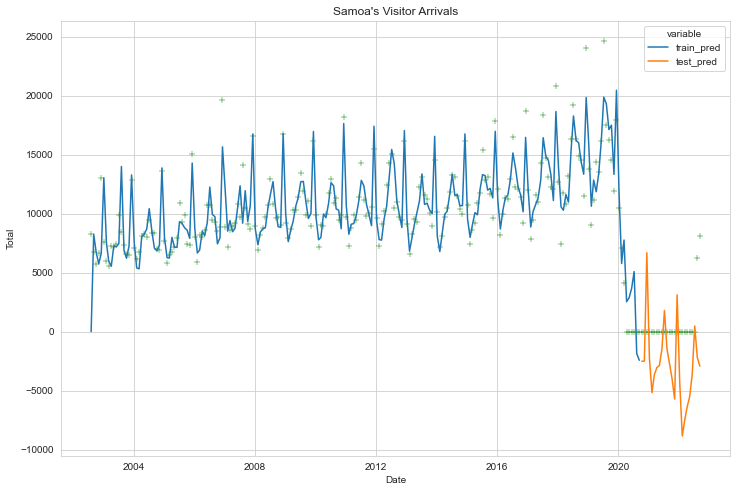

In [16]:
viz_df = samoa_stats[["Date", "train_pred", "test_pred"]].melt(id_vars=["Date"])
viz_df["Date"] = pd.to_datetime(viz_df["Date"])

plt.figure(figsize=(12,8))
sns.set_style("whitegrid")
sns.scatterplot(x="Date", y="Total", data=samoa_stats, color="green", marker="+")
sns.lineplot(data=viz_df, x="Date", y="value", hue="variable")
plt.title("Samoa's Visitor Arrivals")